# Ultimate 25k+ Football Matches Football Project

## About the dataset

This project deals with Ultimate 25k+ Football Matches Football dataset.\
It contains:
- +25,000 matches
- +10,000 players
- 11 European Countries with their lead championship
- Seasons 2008 to 2016
- Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates - - Team line up with squad formation (X, Y coordinates)
- Betting odds from up to 10 providers
- Detailed match events (goal types, possession, corner, cross, fouls, cards etc…) for +10,000 matches

The data was scraped from across various webpages on the internet.

## About this project

In this project the ultimate goals are to model the **goals scored** and the **outcome of the game**.\
**At first**, exploritory questions such as which leagues are in which countries, which leagues score the most/fewest goals, who are the top scorers in each team and league, is there such a thing as home advantage, will be raised and analysis will be conducted to answer them.\
**Second**, statistical inference will be conducted on hypotheses arising from the previous part.\
**Lastly**, we will attempt to model the aformentioned targets.

In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import scipy.stats as stats
import statsmodels.api as sm
from helpers import calc_vif, find_outliers
import warnings
import duckdb

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
}

sns.set_theme(context="notebook", style="whitegrid", rc=custom_params)

pd.set_option("display.precision", 2)

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Loading the data

## Tables

In [2]:
with sqlite3.connect('database.sqlite') as con:
    tables = list(pd.read_sql_query(
        "select name from sqlite_master where type='table';", con)['name'])
tables

['sqlite_sequence',
 'Player_Attributes',
 'Player',
 'Match',
 'League',
 'Country',
 'Team',
 'Team_Attributes']

## Schema

In [3]:
print(*list(f'{i} table:\n {list(pd.read_sql_query(f"select * from {i} limit 0", con).columns)}'
        for i in tables), sep='\n\n\n')

sqlite_sequence table:
 ['name', 'seq']


Player_Attributes table:
 ['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']


Player table:
 ['id', 'player_api_id', 'player_name', 'player_fifa_api_id', 'birthday', 'height', 'weight']


Match table:
 ['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2'

## Constructing the Dataframe

In [4]:
with open('query.sql', 'r') as file:
    sql_query = file.read()

df_wide = pd.read_sql_query(sql_query, con)

# Data Exploration

# Countries and Leagues

In [5]:
countries_leagues = pd.read_sql_query("""
select c.name country, l.name league
from country c
join league l
on c.id = l.country_id
""", con)

In [6]:
countries_leagues

country                    league
0       Belgium    Belgium Jupiler League
1       England    England Premier League
2        France            France Ligue 1
3       Germany     Germany 1. Bundesliga
4         Italy             Italy Serie A
5   Netherlands    Netherlands Eredivisie
6        Poland        Poland Ekstraklasa
7      Portugal  Portugal Liga ZON Sagres
8      Scotland   Scotland Premier League
9         Spain           Spain LIGA BBVA
10  Switzerland  Switzerland Super League

This dataset contains games from 11 leagues where each league is the top division league of respective country.

## League Scoring Summary

Checking if all of the id's and scores are there:

In [7]:
pd.read_sql_query("""
select *
from match
where home_team_api_id is null
or away_team_api_id is null
or home_team_goal is null
or away_team_goal is null
""", con)

Empty DataFrame
Columns: [id, country_id, league_id, season, stage, date, match_api_id, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal, home_player_X1, home_player_X2, home_player_X3, home_player_X4, home_player_X5, home_player_X6, home_player_X7, home_player_X8, home_player_X9, home_player_X10, home_player_X11, away_player_X1, away_player_X2, away_player_X3, away_player_X4, away_player_X5, away_player_X6, away_player_X7, away_player_X8, away_player_X9, away_player_X10, away_player_X11, home_player_Y1, home_player_Y2, home_player_Y3, home_player_Y4, home_player_Y5, home_player_Y6, home_player_Y7, home_player_Y8, home_player_Y9, home_player_Y10, home_player_Y11, away_player_Y1, away_player_Y2, away_player_Y3, away_player_Y4, away_player_Y5, away_player_Y6, away_player_Y7, away_player_Y8, away_player_Y9, away_player_Y10, away_player_Y11, home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6, home_player_7, home_player_8, home_player_9, home_player_10, home_player_11, away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6, away_player_7, away_player_8, away_player_9, away_player_10, away_player_11, goal, shoton, shotoff, foulcommit, card, cross, corner, possession, B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA, LBH, LBD, LBA, PSH, PSD, PSA, ...]
Index: []

[0 rows x 115 columns]

Checking for duplicated matches:

In [8]:
pd.read_sql_query("""
select date, home_team_api_id, away_team_api_id, count(*) count
from match
group by date, home_team_api_id, away_team_api_id
having count(*) > 1
""", con)

Empty DataFrame
Columns: [date, home_team_api_id, away_team_api_id, count]
Index: []

Average total goals per match:

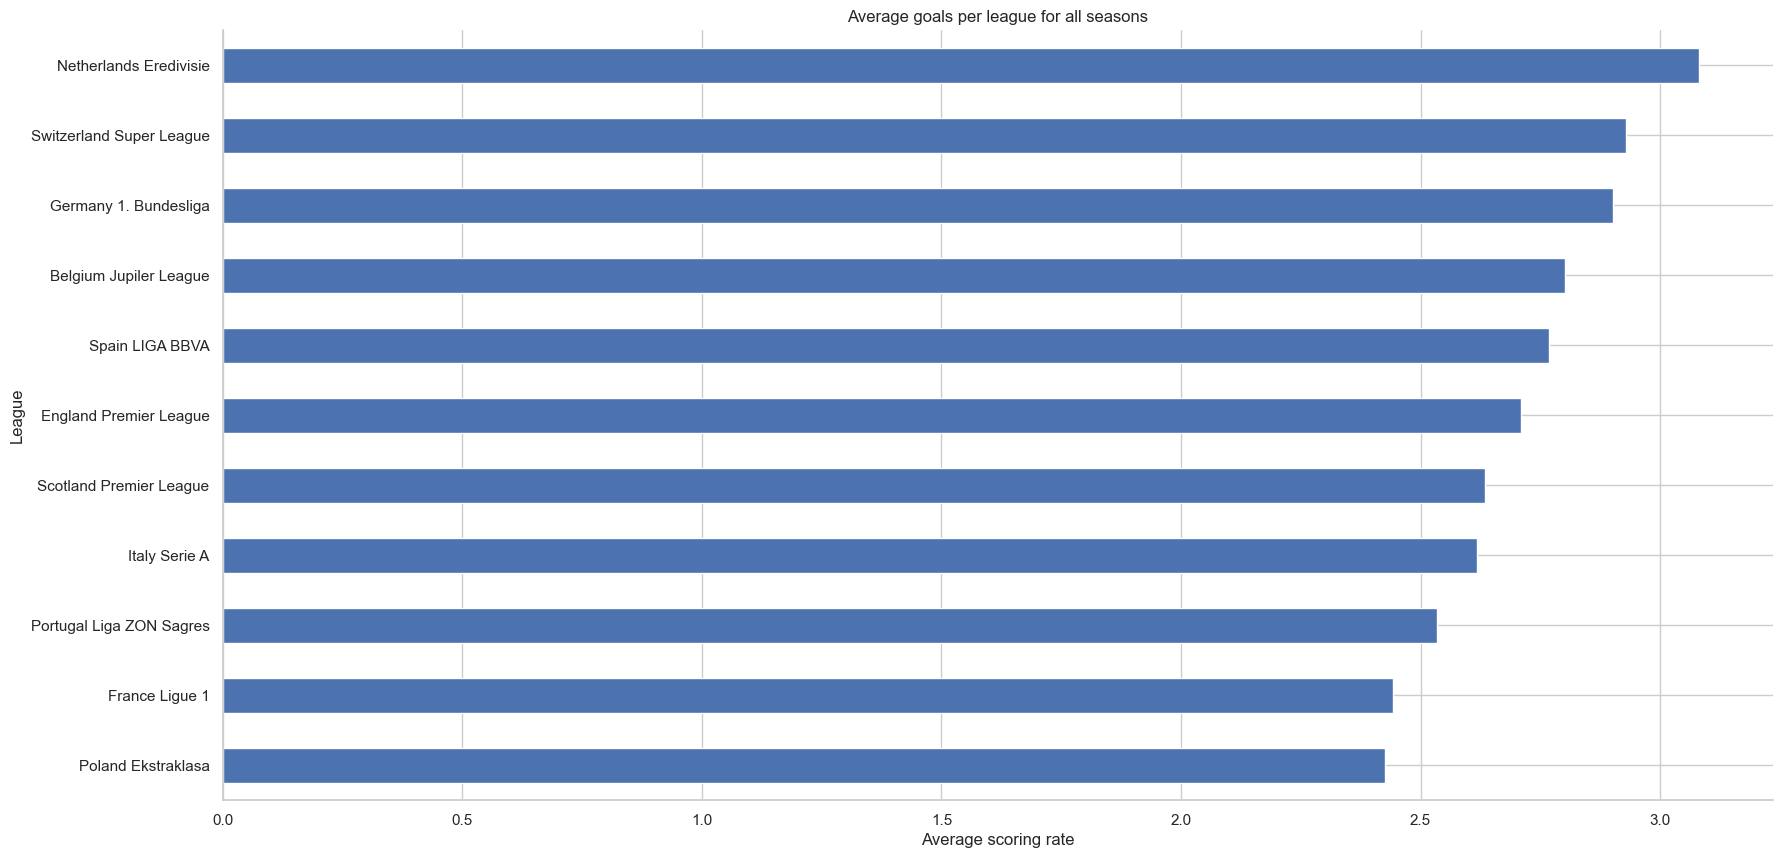

In [9]:
league_avg_goals = (pd.read_sql_query(f"""
select l.name,
avg(home_team_goal + away_team_goal) avg_scoring_rate
from match m
join league l
on l.id = m.league_id
group by l.name
order by avg_scoring_rate
""", con)
 .set_index('name')
 .plot(kind='barh', legend=False, figsize=(20,10),
       xlabel='Average scoring rate', ylabel='League', title='Average goals per league for all seasons')
);

Netherlands', Switzerland's and Germany's leagues seem to be most active in scoring. This could possibly suggest:
- Team strength imbalance.
- Agressive style of playing in the league.

## Average scoring by season

In [10]:
avg_league_season_scoring = pd.read_sql_query(f"""
select l.name, m.season, avg(home_team_goal + away_team_goal) avg_goals
from match m
join league l
on l.id = m.league_id
group by l.name, m.season
""", con)

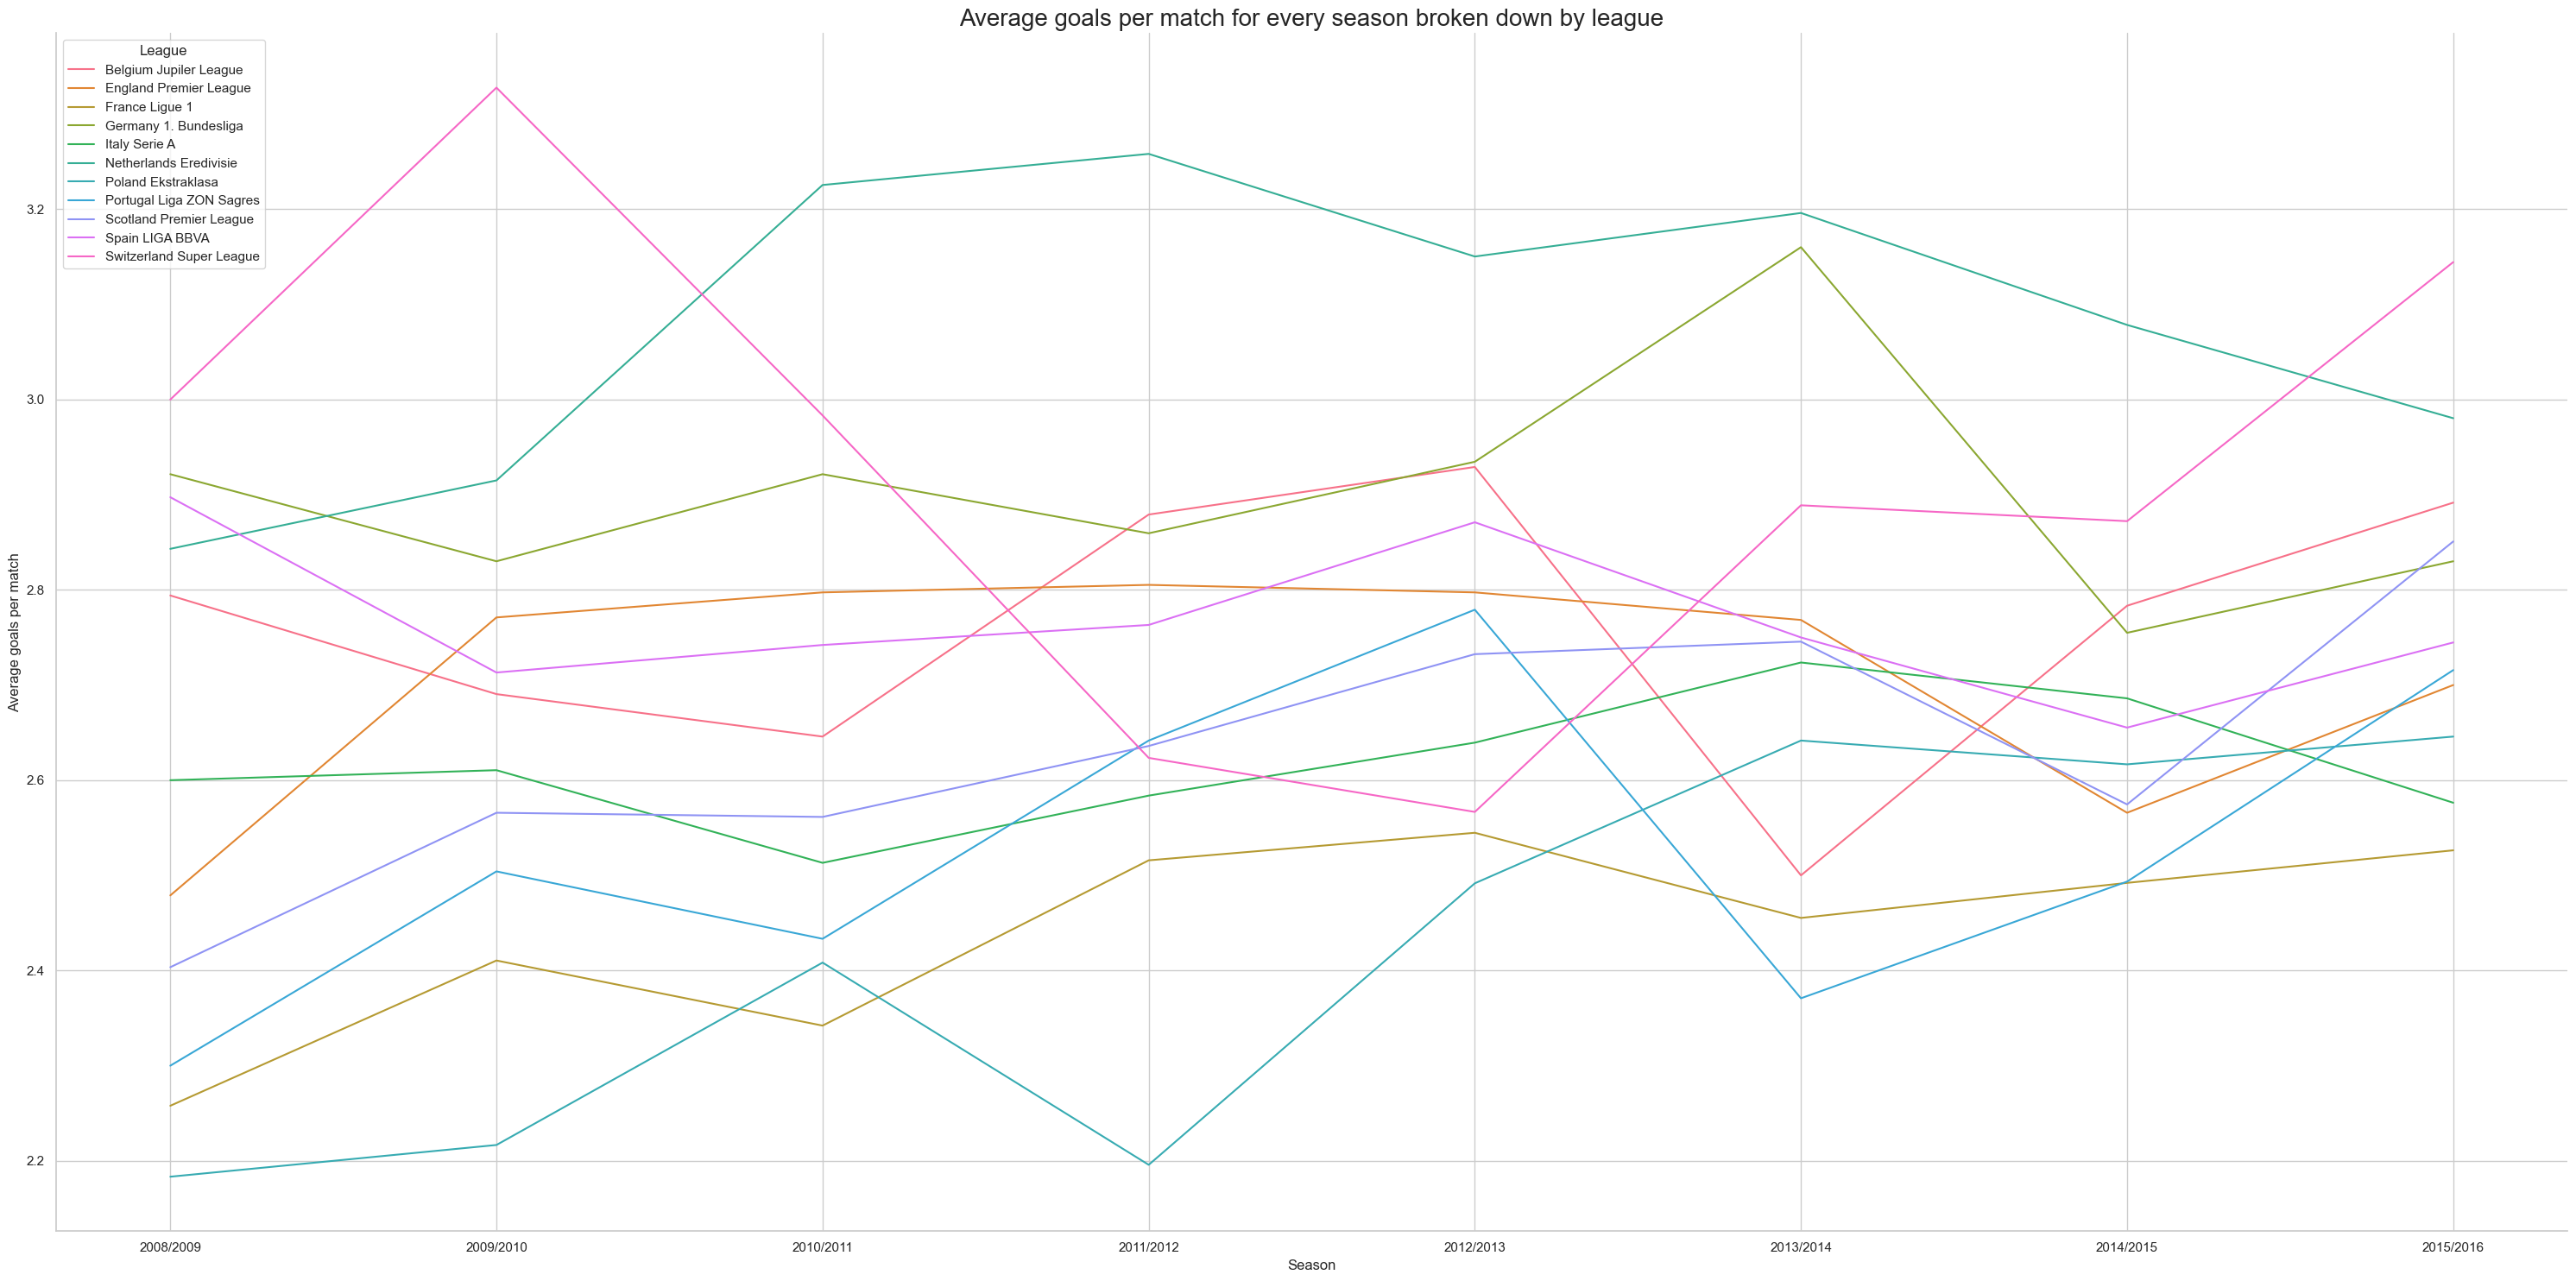

In [11]:
plt.figure(figsize=(30, 15))
ax = sns.lineplot(avg_league_season_scoring, x='season', y='avg_goals', hue='name')
plt.title('Average goals per match for every season broken down by league', fontsize=20)
ax.legend(title='League')
ax.set_ylabel('Average goals per match')
ax.set_xlabel('Season')
plt.tight_layout();

We do in fact see that in the Netherland's league games seem to consistently have the top match score average.

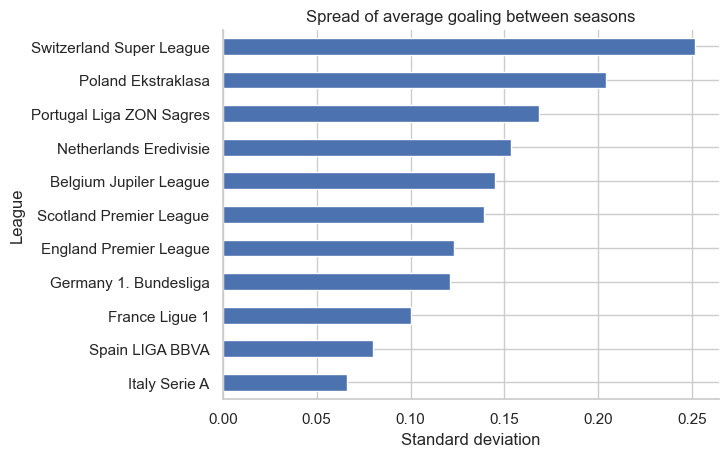

In [12]:
avg_league_season_scoring.groupby('name')['avg_goals'].std().sort_values().plot(kind='barh')
ax = plt.gca()
ax.set_title('Spread of average goaling between seasons')
ax.set_ylabel('League')
ax.set_xlabel('Standard deviation');

- Switzerland's, Poland's average goals deviate relatively strongly per season compared to the rest of the leagues.
- Italy's and Spain's leagues behave similarly season by season in this respect.
- Considering averages of all seasons there seem to be different tendancies in goal occurances between leagues.

# Distribution of Goals

In [13]:
home_team_count = df_wide['home_team_goal'].value_counts().sort_index()
away_team_count = df_wide['away_team_goal'].value_counts().sort_index()

In [14]:
goal_counts = pd.DataFrame({
    'Home Goals': home_team_count,
    'Away Goals': away_team_count
}).fillna(0)

In [15]:
goal_counts = goal_counts.reset_index()

In [16]:
gc_melt = pd.melt(goal_counts, id_vars = 'index', value_vars=['Home Goals', 'Away Goals'])

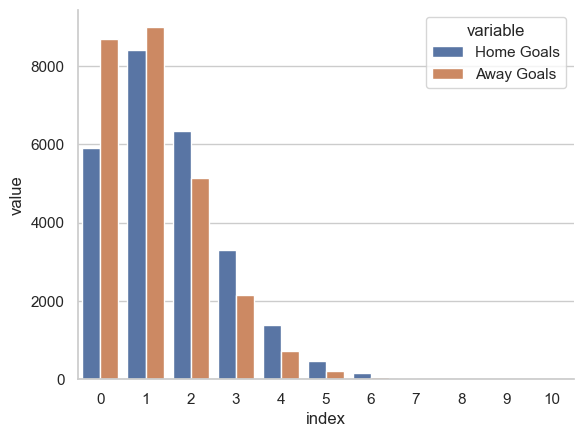

In [17]:
sns.barplot(gc_melt, x='index', y='value', hue='variable');

- Much higher rate of 0 goals scored for away teams.

## Consistency of distribution across leagues

Since we might want to add league as a predictor for modeling amount of goals scored, or to create separate models for each league, we need to know if the distribution is consistent across all leagues.

In [18]:
df_melted = df_wide[['home_team_goal', 'away_team_goal', 'league']].melt(id_vars=['league'], value_vars=['home_team_goal', 'away_team_goal'])
df_melted.columns = ['League', 'Team Type', 'Goals']
goal_counts = df_melted.groupby(['League', 'Team Type', 'Goals']).size().reset_index(name='Occurrences')
goal_counts

League       Team Type  Goals  Occurrences
0      Belgium Jupiler League  away_team_goal      0          537
1      Belgium Jupiler League  away_team_goal      1          612
2      Belgium Jupiler League  away_team_goal      2          382
3      Belgium Jupiler League  away_team_goal      3          132
4      Belgium Jupiler League  away_team_goal      4           46
..                        ...             ...    ...          ...
177  Switzerland Super League  home_team_goal      3          214
178  Switzerland Super League  home_team_goal      4          100
179  Switzerland Super League  home_team_goal      5           29
180  Switzerland Super League  home_team_goal      6           14
181  Switzerland Super League  home_team_goal      7            2

[182 rows x 4 columns]

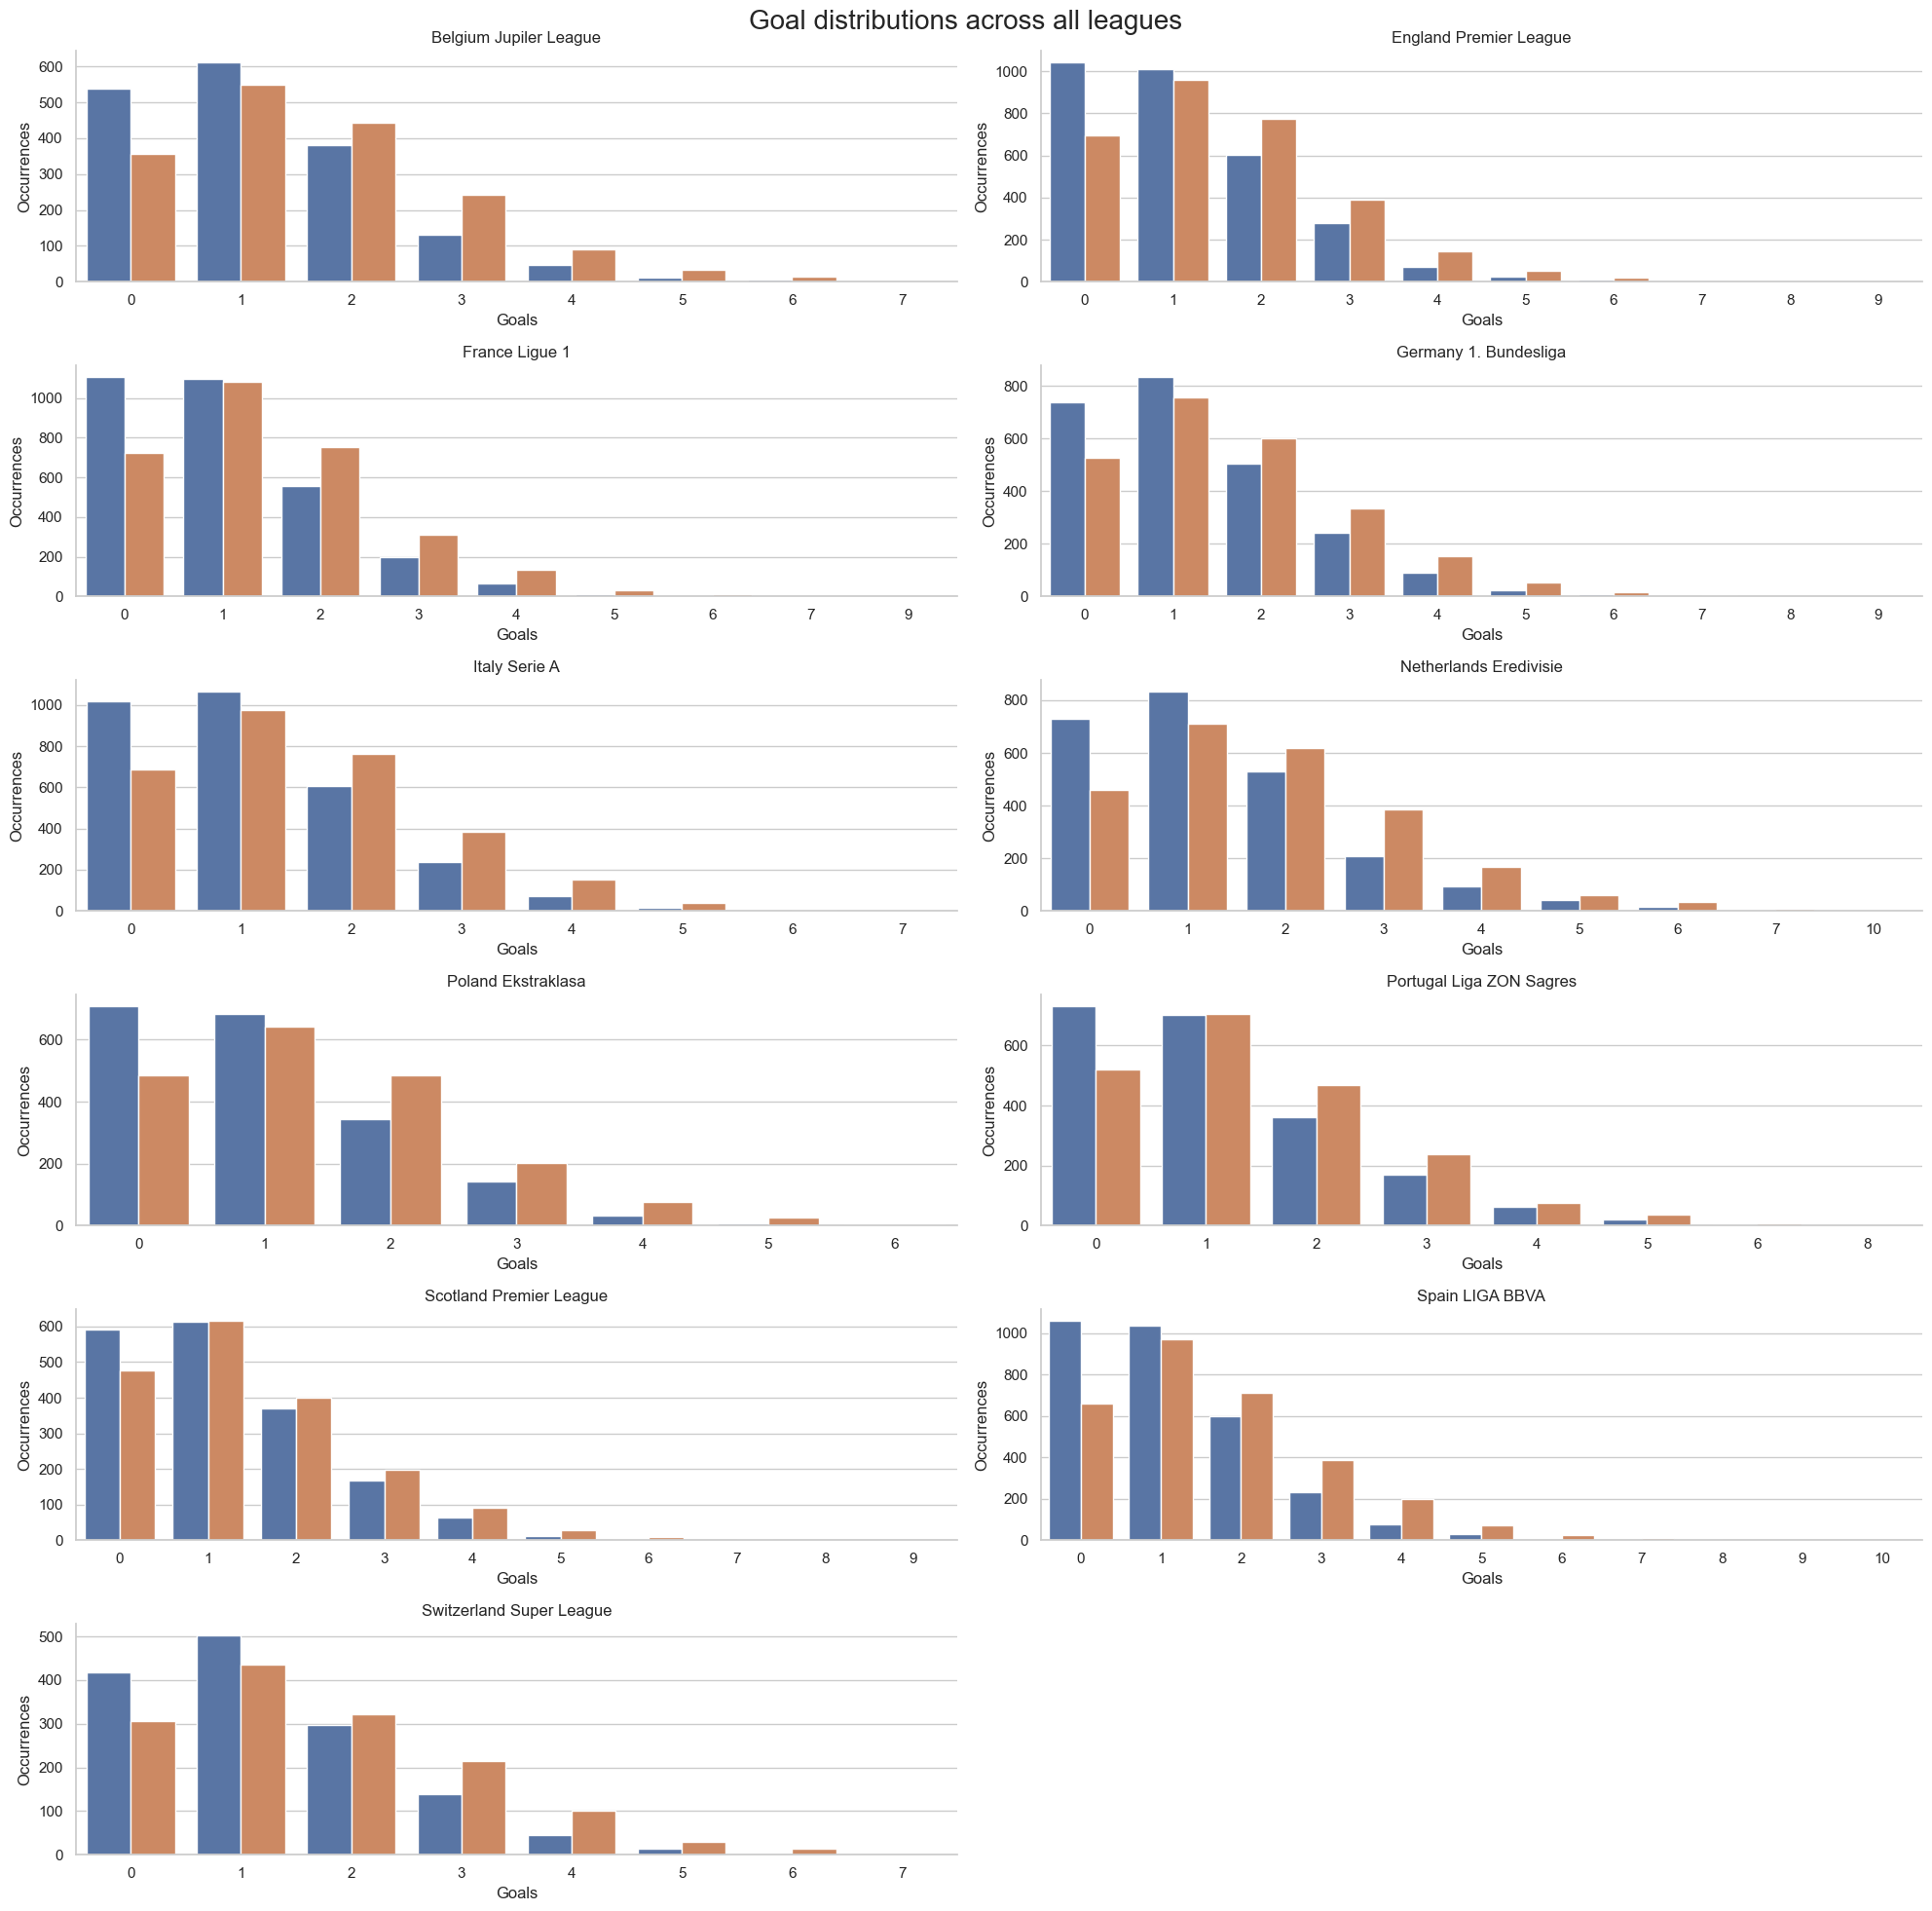

In [19]:
unique_leagues = goal_counts.League.unique()
fig, axs = plt.subplots(6, 2, figsize=(20,20))
axs_flat = axs.flatten()
for axnum, league in enumerate(unique_leagues):

    sns.barplot(goal_counts[goal_counts['League'] == league],
    y='Occurrences', x='Goals', hue='Team Type', ax=axs_flat[axnum], legend=False)
    axs_flat[axnum].set_title(league)
    
for ax in axs_flat:
    if not ax.has_data():
        ax.set_visible(False)
        
plt.suptitle('Goal distributions across all leagues', fontsize=20)
plt.tight_layout()

- Similar trend across leagues.

# Top scoring players

In [20]:
from bs4 import BeautifulSoup

In [21]:
entries_with_goal_info = df_wide[df_wide.goal.notna()].goal
len(entries_with_goal_info)

14217

In [22]:
soup = BeautifulSoup(df_wide[df_wide.goal.notna()].head(1).goal.values[0])
print(soup.prettify())

<html>
 <body>
  <goal>
   <value>
    <comment>
     n
    </comment>
    <stats>
     <goals>
      1
     </goals>
     <shoton>
      1
     </shoton>
    </stats>
    <event_incident_typefk>
     406
    </event_incident_typefk>
    <elapsed>
     22
    </elapsed>
    <player2>
     38807
    </player2>
    <subtype>
     header
    </subtype>
    <player1>
     37799
    </player1>
    <sortorder>
     5
    </sortorder>
    <team>
     10261
    </team>
    <id>
     378998
    </id>
    <n>
     295
    </n>
    <type>
     goal
    </type>
    <goal_type>
     n
    </goal_type>
   </value>
   <value>
    <comment>
     n
    </comment>
    <stats>
     <goals>
      1
     </goals>
     <shoton>
      1
     </shoton>
    </stats>
    <event_incident_typefk>
     393
    </event_incident_typefk>
    <elapsed>
     24
    </elapsed>
    <player2>
     24154
    </player2>
    <subtype>
     shot
    </subtype>
    <player1>
     24148
    </player1>
    <sortorder>
     4
   

Out of 25k+ matches there are around 14k+ rows of info on players who scored the goal. It seems like player 1 represents the player that scored the goal while player 2 the player that assisted.

In [23]:
def extract_from_xml(row, tag):
    return [player.text for player in BeautifulSoup(row).find_all(tag)]

In [24]:
goal_player_rows = entries_with_goal_info.apply(lambda x: extract_from_xml(x, 'player1'))

In [25]:
ids = list()
for id_list in goal_player_rows.values:
    for player_id in id_list:
        ids.append(player_id)

In [26]:
players = pd.read_sql_query('select * from player', con)
players.player_api_id = players.player_api_id.astype(int)

In [27]:
from collections import Counter
ids_counted = Counter(ids)
ids_counted_df = pd.DataFrame(ids_counted.items(), columns=['player_api_id', 'goal_count'])
ids_counted_df.player_api_id = ids_counted_df.player_api_id.astype(int)
player_goals = ids_counted_df.merge(players, how='left', on='player_api_id')

In [28]:
player_goals.head(1)

player_api_id  goal_count      id      player_name  player_fifa_api_id  \
0          37799          22  8079.0  Obafemi Martins            137494.0   

              birthday  height  weight  
0  1984-10-28 00:00:00  170.18   161.0

In [29]:
na_player_goals = player_goals[player_goals.player_name.isna()]
na_player_goals

player_api_id  goal_count  id player_name  player_fifa_api_id birthday  \
158           40611           3 NaN         NaN                 NaN      NaN   
209           39647           4 NaN         NaN                 NaN      NaN   
212           24413           3 NaN         NaN                 NaN      NaN   
488           40553           1 NaN         NaN                 NaN      NaN   
533           96958           1 NaN         NaN                 NaN      NaN   
...             ...         ...  ..         ...                 ...      ...   
4014         171172           1 NaN         NaN                 NaN      NaN   
4095         517295           1 NaN         NaN                 NaN      NaN   
4256         610184           1 NaN         NaN                 NaN      NaN   
4271          66910           1 NaN         NaN                 NaN      NaN   
4309         402776           1 NaN         NaN                 NaN      NaN   

      height  weight  
158      NaN     NaN  
209      NaN     NaN  
212      NaN     NaN  
488      NaN     NaN  
533      NaN     NaN  
...      ...     ...  
4014     NaN     NaN  
4095     NaN     NaN  
4256     NaN     NaN  
4271     NaN     NaN  
4309     NaN     NaN  

[77 rows x 8 columns]

77 players id's coldn't be linked. Their total goal counts are not large, therefore it works for our purposes.

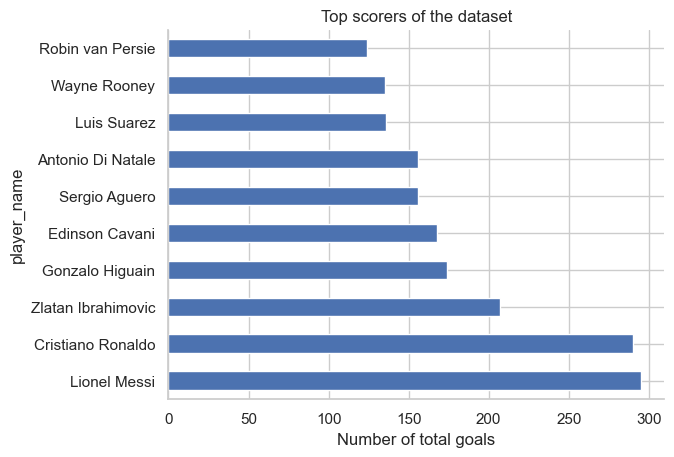

In [30]:
player_goals_sorted = player_goals.sort_values('goal_count', ascending=False)
(player_goals_sorted[['player_name', 'goal_count']]
 .set_index('player_name')
 .head(10)
 .plot(kind='barh', title='Top scorers of the dataset', legend=False, xlabel='Number of total goals')
);

Large amount of data on goals is missing. Though, from what is available it seems that Christiano Ronaldo and Lionel Messi are overwhelmingly dominant players in terms of scoring.

## Top league-wise scorers

Proportions of missing goal data for each league:

In [31]:
for league in df_wide.league.unique():
    print(league, df_wide[df_wide.league == league].goal.isna().sum() / (df_wide[df_wide.league == league].goal.isna().sum() + 
df_wide[df_wide.league == league].goal.notna().sum()))

Belgium Jupiler League 1.0
England Premier League 0.0
France Ligue 1 0.3335526315789474
Germany 1. Bundesliga 0.0
Italy Serie A 0.0009943652635067948
Netherlands Eredivisie 0.7834967320261438
Poland Ekstraklasa 0.9963541666666667
Portugal Liga ZON Sagres 1.0
Scotland Premier League 0.9928728070175439
Spain LIGA BBVA 0.0003289473684210526
Switzerland Super League 0.929676511954993


In [32]:
loi = ['England Premier League', 'France Ligue 1',
       'Germany 1. Bundesliga', 'Italy Serie A', 'Spain LIGA BBVA']

Many leagues have the majority of the data missing, which means, only some of the leagues can be used.

In [33]:
top_scorer_leagues = df_wide.iloc[goal_player_rows.index].league

In [34]:
league_scorers = pd.concat([goal_player_rows, top_scorer_leagues], axis=1)

In [35]:
league_scorers_exp = league_scorers.explode('goal')
league_scorers_exp.columns = ['player_api_id', 'league']
league_scorers_exp_filtered = league_scorers_exp[league_scorers_exp.player_api_id.notna()].copy()
league_scorers_exp_filtered.player_api_id = league_scorers_exp_filtered.player_api_id.astype(int)

In [36]:
scorers_leagues = league_scorers_exp_filtered.merge(players, on='player_api_id', how='left')

In [37]:
top_scorers = (scorers_leagues
               .groupby(['league', 'player_name'])
               .size()
               .reset_index(name='score')
               .sort_values(['league', 'score'], ascending=[True, False])
               .groupby('league')
               .head(5)
              )
top_scorers = top_scorers[top_scorers['league'].isin(loi)]

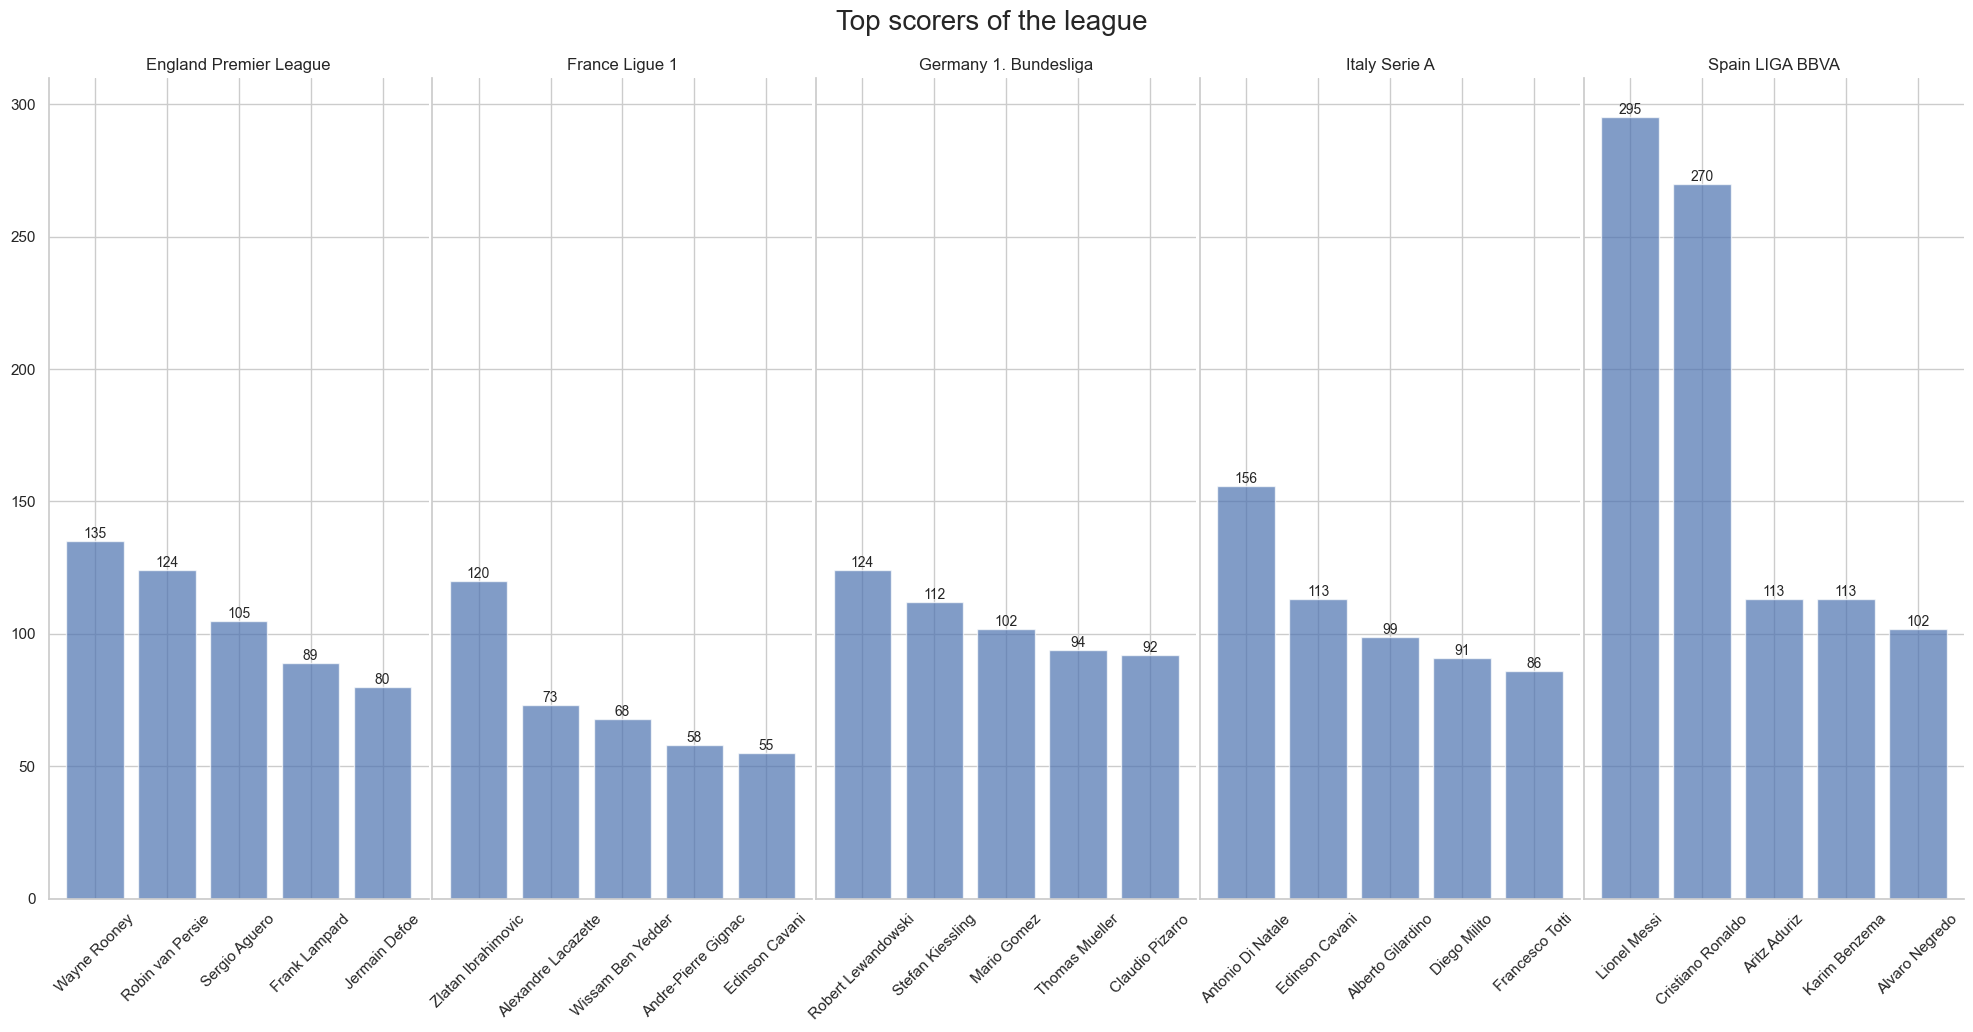

In [38]:
leagues = top_scorers.league.unique()
fig, ax = plt.subplots(1, 5, figsize=(20,10), sharey=True)
count = 0
for i in range(5):
    ax[i].bar(top_scorers[top_scorers.league == leagues[count]]['player_name'], 
            top_scorers[top_scorers.league == leagues[count]]['score'], alpha=0.7)
    ax[i].set_title(f'{leagues[count]}')
    ax[i].tick_params(axis='x', rotation=45)
    ax[i].bar_label(ax[i].containers[0], fontsize=10)
    count += 1
plt.tight_layout()
fig.subplots_adjust(wspace=0.01)
fig.suptitle('Top scorers of the league', y=1.03, fontsize=20);

- Lionel Messi and Christiano Ronaldo have overwhelmingly more total goals score (by 150+) compared to their league mates and players from other leagues likewise.
- Lionel Messi, Christiano Ronaldo, Antonio Di Natale and Zlatan Ibrahimovic all have considerably higher scoring record compared to their league mates.

## Top scorers per season

We will consider only England's, Germany's, Italy's and Spain's premiere leagues, since we have full data for these. We will be dropping 77 players that cannot be merged but as seen before they aren't top scorers by any standard, therefore, the results are not going to be skewed.

In [39]:
scorers_by_season = pd.concat([league_scorers, df_wide.iloc[league_scorers.index]['season']], axis=1)

In [40]:
scorers_by_season_exp = scorers_by_season.explode('goal')
scorers_by_season_filt = (scorers_by_season_exp[scorers_by_season_exp['league']
                          .isin(['England Premier League', 'Germany 1. Bundesliga',
                                 'Italy Serie A', 'Spain LIGA BBVA'])]).copy()

In [41]:
scorers_by_season_filt.columns = ['player_api_id', 'league', 'season']

In [42]:
scorers_by_season_filt.dropna(subset='player_api_id', inplace=True)
scorers_by_season_filt.player_api_id = scorers_by_season_filt.player_api_id.astype(int)
scorers_by_season_merged = scorers_by_season_filt.merge(players, how='left', on='player_api_id')

In [43]:
top_scorers_by_season = (scorers_by_season_merged
 .groupby(['season', 'league'])['player_name']
 .value_counts()
 .groupby(['season', 'league'])
 .head(1)
 .reset_index()
)

In [44]:
top_scorers_by_season['x'] = top_scorers_by_season['season'].rank(method='dense')
top_scorers_by_season['x'] = top_scorers_by_season['x'] - 1
top_scorers_by_season['y'] = top_scorers_by_season['count']
ind = top_scorers_by_season[top_scorers_by_season[['x', 'y']].duplicated()].index
top_scorers_by_season.loc[ind, 'y'] = top_scorers_by_season.loc[ind, 'y'] + 1 # Making sure none of the label coordinates overlap

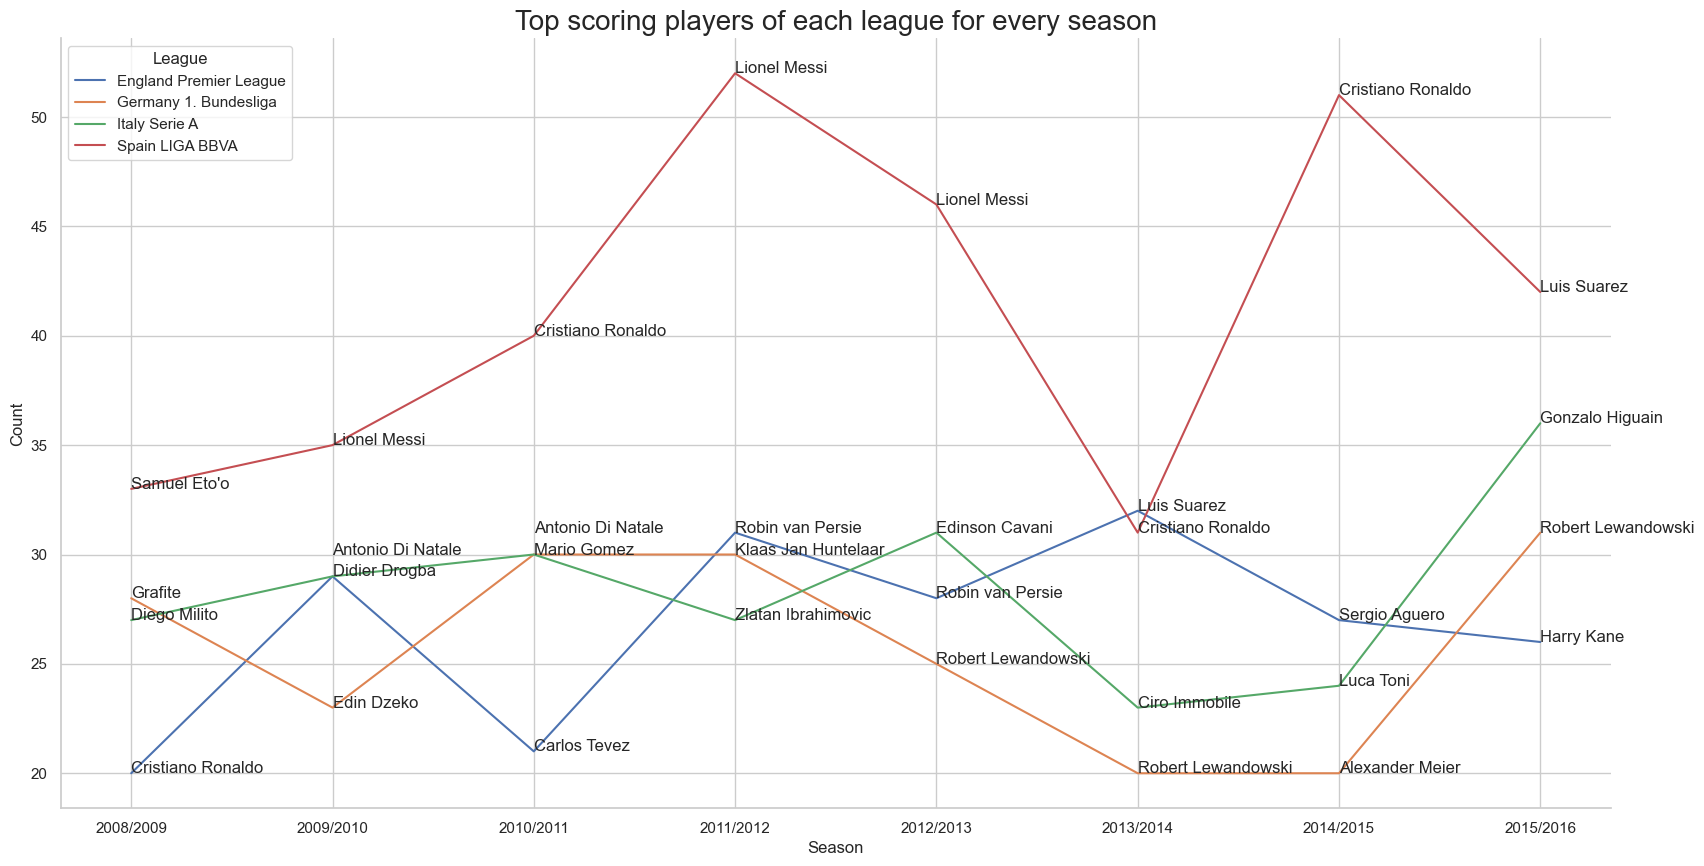

In [45]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(top_scorers_by_season, x='season', y='count', hue='league')
for i in range(len(top_scorers_by_season)):
    ax.text(x=top_scorers_by_season.loc[i, 'x'],
           y=top_scorers_by_season.loc[i, 'y'],
           s=top_scorers_by_season.loc[i, 'player_name'])
ax.set_ylabel('Count')
ax.set_xlabel('Season')
ax.set_title('Top scoring players of each league for every season', fontsize=20)
ax.legend(title='League');

- Except for 2013 season, Spain's league constantly holds the most scoring players with mostly Lionel Messi and Christiano Ronaldo contributing to this gap.

## Top scoring teams

In [46]:
home_df = df_wide[['home_team', 'home_team_goal', 'league', 'season']]
away_df = df_wide[['away_team', 'away_team_goal', 'league', 'season']]
new_cols = ['team', 'goals', 'league', 'season']
home_df.columns = new_cols
away_df.columns = new_cols
all_team_goals = pd.concat([home_df, away_df], ignore_index=True)

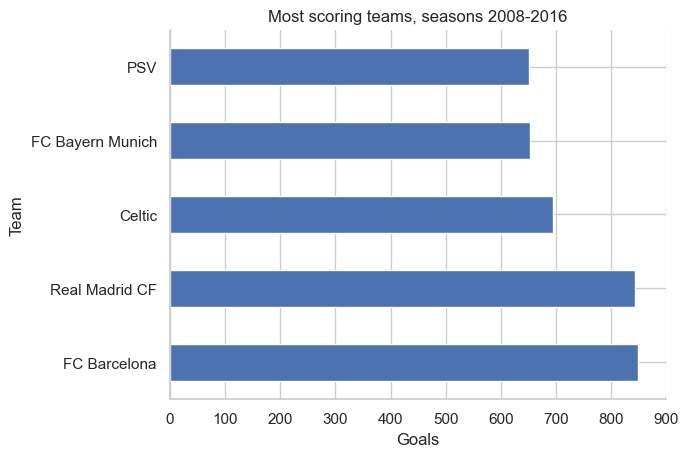

In [47]:
(all_team_goals
 .groupby('team')
 ['goals']
 .sum()
 .sort_values(ascending=False)
 [:5]
 .plot(kind='barh', xlim=(0,900), ylabel='Team', xlabel='Goals',
      title='Most scoring teams, seasons 2008-2016')
);

Barcelona and Real Madrid are the most dominant scorers, with Real Madrid only behind Barcelona by 6 goals.

## Most scoring teams of each league

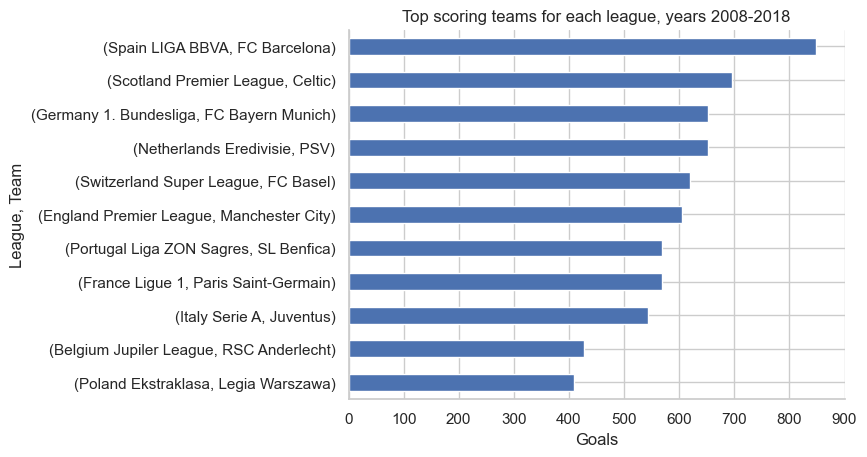

In [48]:
(all_team_goals
 .groupby(['league', 'team'])
 ['goals']
 .sum()
 .groupby('league')
 .nlargest(n=1)
 .sort_values(ascending=True)
 .pipe(lambda x: x.droplevel(0))
 .plot(kind='barh', ylabel='League, Team', xlabel='Goals',
  xlim=(0, 900), title='Top scoring teams for each league, years 2008-2018')
);

Top 3 teams in terms of scoring of the top scoring teams in each league:
1. FC Barcelona
2. Celtic
3. FC Bayern Munich

## Top scoring team seasonally

In [49]:
top_scoring_teams_seasonally = (
all_team_goals
 .groupby(['season', 'league', 'team'])
 .goals
 .sum()
 .groupby(['season', 'league'])
 .nlargest(n=1)
 .pipe(lambda x: x.droplevel([0, 1]))
 .reset_index()
)

In [50]:
top_scoring_teams_seasonally['x'] = top_scoring_teams_seasonally['season'].rank(method='dense') - 1
top_scoring_teams_seasonally['y'] = top_scoring_teams_seasonally['goals']
ind2 = top_scoring_teams_seasonally[top_scoring_teams_seasonally[['x', 'y']].duplicated()].index
top_scoring_teams_seasonally.loc[ind2, 'y'] = top_scoring_teams_seasonally.loc[ind2, 'y'] + 1
ind3 = top_scoring_teams_seasonally[top_scoring_teams_seasonally[['x', 'y']].duplicated()].index
top_scoring_teams_seasonally.loc[ind3, 'x'] = top_scoring_teams_seasonally.loc[ind3, 'x'] + 0.35
top_scoring_teams_seasonally.loc[ind3, 'y'] = top_scoring_teams_seasonally.loc[ind3, 'y'] + 1

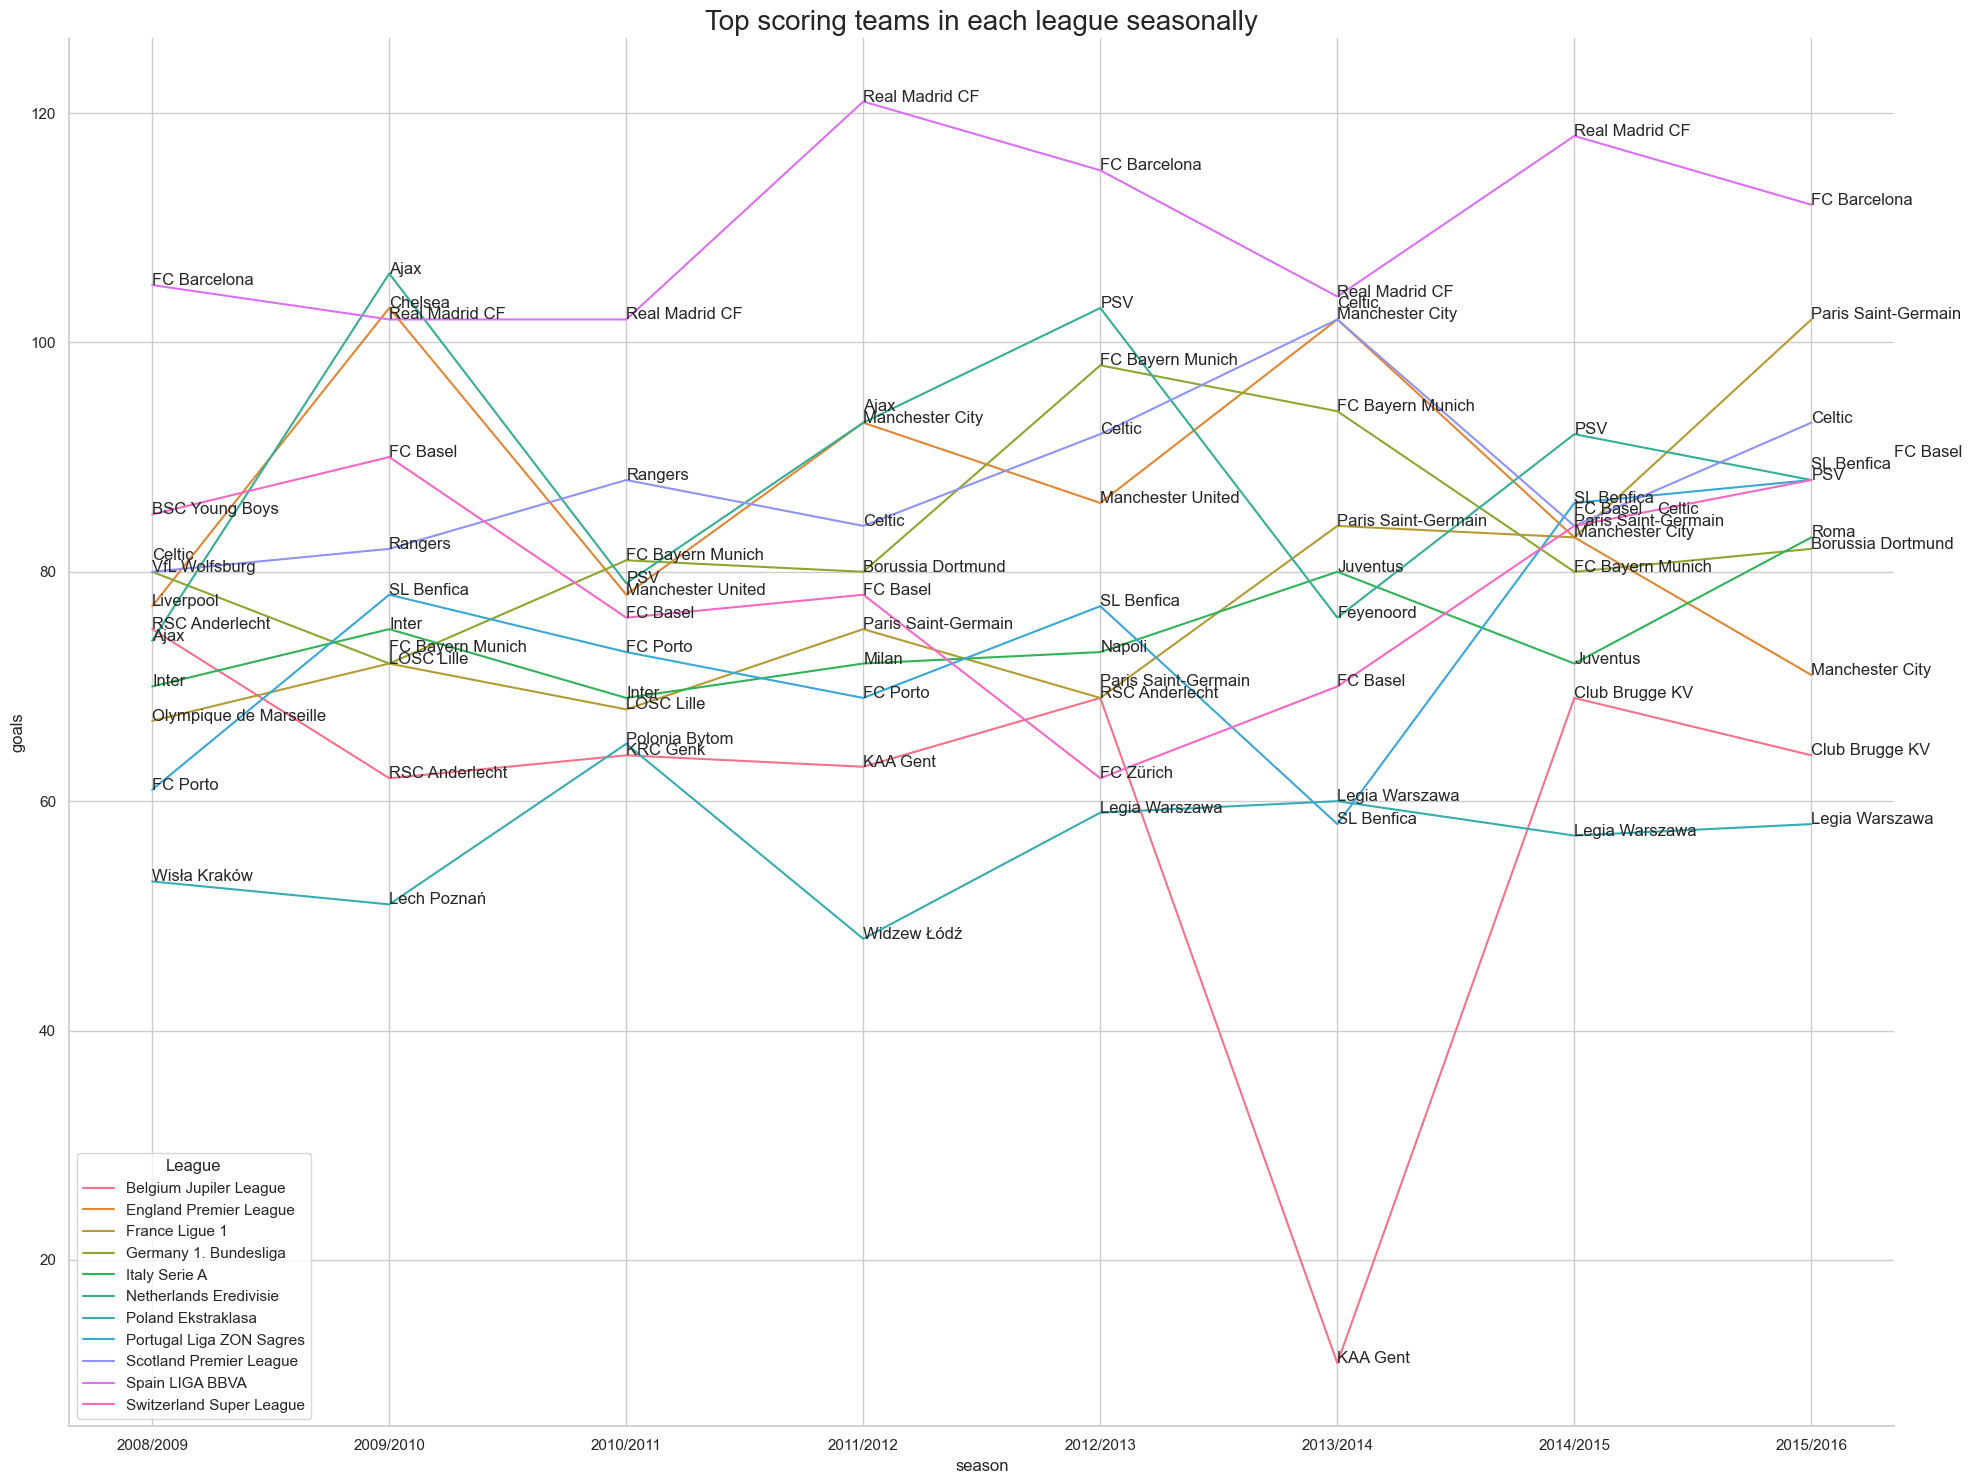

In [51]:
plt.figure(figsize=(20,15))
ax = sns.lineplot(top_scoring_teams_seasonally, x='season', y='goals', hue='league')
for i in range(len(top_scoring_teams_seasonally)):
    ax.text(x=top_scoring_teams_seasonally.loc[i, 'x'],
           y=top_scoring_teams_seasonally.loc[i, 'y'],
           s=top_scoring_teams_seasonally.loc[i, 'team'])
ax.set_title('Top scoring teams in each league seasonally', fontsize=20)
ax.legend(loc='lower left', title='League')
plt.tight_layout();

Spanish league once again holds the top scorers, now in terms of teams with FC Barcelona and Real Madrid interchangibly taking the top.

## Top scorers of top scoring teams

In this case, again, we can only evaluate 4 leagues: 
- England Premier League 
- Germany 1. Bundesliga
- Italy Serie A
- Spain LIGA BBVA.

We will constrain ourselves with only the last season (2015/2016) since its the most recent and the top 5 teams in aforementioned leagues.

In [52]:
loi = ['England Premier League',
 'Germany 1. Bundesliga',
 'Italy Serie A',
 'Spain LIGA BBVA']

In [53]:
teams = pd.read_sql_query(
"""select team_api_id, team_long_name
   from team
""", con)

In [54]:
eng_2016_goals = (df_wide[(df_wide['league'].isin(loi))
                  & (df_wide['season'] == '2015/2016')]['goal'])

goal_player_team_ids = pd.concat([eng_2016_goals.apply(lambda x: extract_from_xml(x, 'player1')),
          eng_2016_goals.apply(lambda x: extract_from_xml(x, 'team'))], axis=1)
goal_player_team_ids['league'] = df_wide.iloc[goal_player_team_ids.index]['league']
goal_player_team_ids.columns = ['players', 'teams', 'league']

ids_mask = (goal_player_team_ids
            .players
            .apply(lambda x: len(x))
            .ne(
                (goal_player_team_ids
                .teams
                .apply(lambda x: len(x)
                      )
                )
            )
           )

goal_player_team_ids.drop(goal_player_team_ids[ids_mask].index, inplace=True)

players_teams_ids_exp = goal_player_team_ids.explode(['players', 'teams']).dropna()
players_teams_ids_exp.reset_index(drop=True, inplace=True)
players_teams_ids_exp['players'] = players_teams_ids_exp['players'].astype(int)
players_teams_ids_exp['teams'] = players_teams_ids_exp['teams'].astype(int)

eng_scorers_teams_merged = (
 players_teams_ids_exp
 .merge(players, left_on='players', right_on='player_api_id')
 .merge(teams, left_on='teams', right_on='team_api_id')
)

In [55]:
top_5_2016_teams = (eng_scorers_teams_merged
 .groupby(['league', 'team_long_name'])
 ['team_long_name']
 .agg(count='count')
 ['count']
 .groupby('league')
 .nlargest(5)
 .droplevel(0)
 .reset_index()
 .team_long_name)

players_of_top_5_2016 = eng_scorers_teams_merged[eng_scorers_teams_merged['team_long_name'].isin(top_5_2016_teams)]

top_of_top_5 = (players_of_top_5_2016
 .groupby('team_long_name')
 [['player_name', 'league']]
 .value_counts()
 .groupby('team_long_name')
 .nlargest(1)
 .droplevel(0)
 .reset_index()
 .sort_values('count', ascending=False)
               )
top_of_top_5['team_player'] = top_of_top_5[['player_name', 'team_long_name']].agg(', '.join, axis=1)

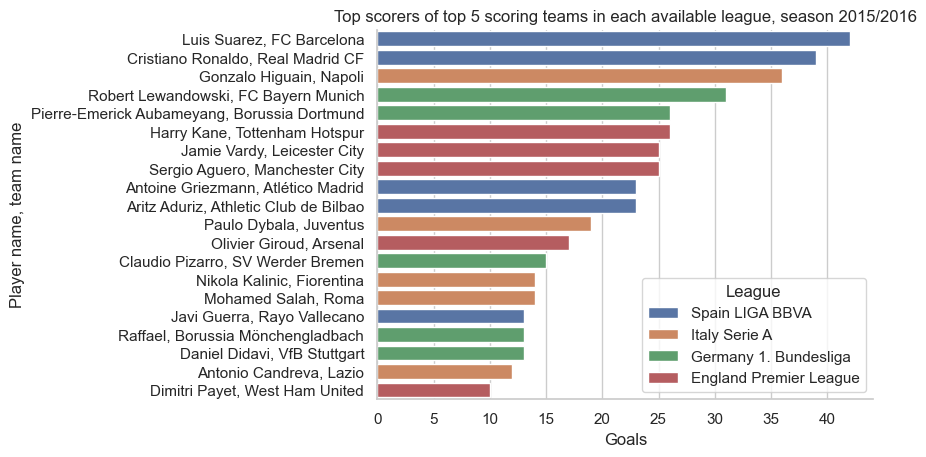

In [56]:
sns.barplot(data=top_of_top_5, x='count', y='team_player', hue='league')
ax = plt.gca()
ax.set_title('Top scorers of top 5 scoring teams in each available league, season 2015/2016')
ax.set_ylabel('Player name, team name')
ax.set_xlabel('Goals')
ax.legend(title='League');

- We see that Ronaldo and Suarez were the critical leaders within their teams in 2015/2016 season.

# Home advantage

Is there such a thing as home advantage?

## Goals

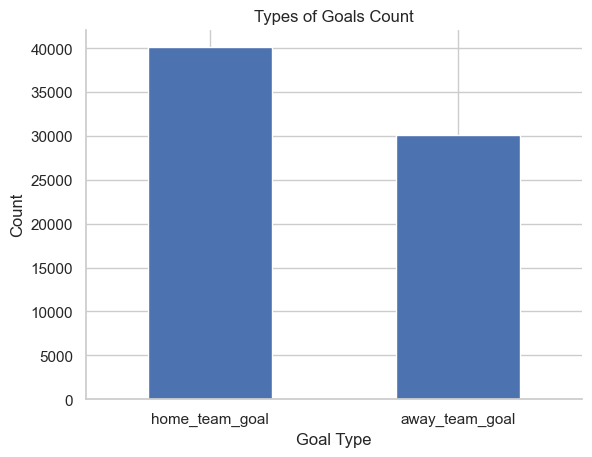

In [57]:
(df_wide
 [['home_team_goal', 'away_team_goal']]
 .sum(axis=0)
 .plot(kind='bar', rot=0,
      ylabel='Count', xlabel='Goal Type',
      title='Types of Goals Count')
);

- Across the whole dataset, home teams seem to score significantly more goals compared with away teams.

Converting goals to results:

## Match outcomes

In [58]:
def win_loss_draw(row):
    if row.home_team_goal > row.away_team_goal:
        return 'Win'
    elif row.home_team_goal < row.away_team_goal:
        return 'Loss'
    return 'Draw'

df_wide['match_result'] = df_wide.apply(win_loss_draw, axis=1)

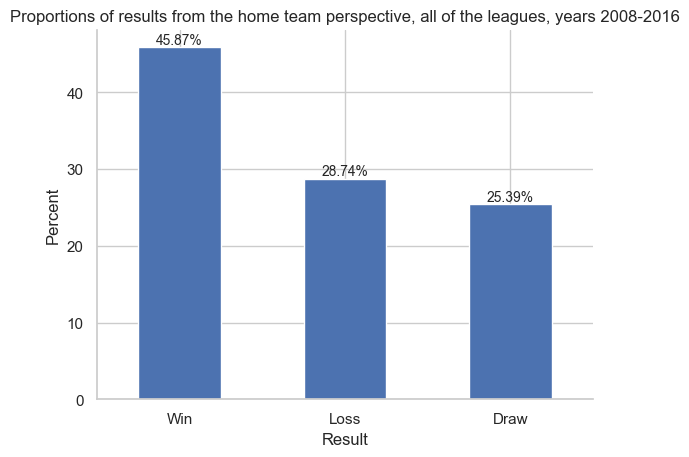

In [59]:
ax = (df_wide
 .match_result
 .value_counts(normalize=True)
 .mul(100)
 .plot(kind='bar', rot=0,
      title='Proportions of results from the home team perspective, all of the leagues, years 2008-2016',
      ylabel='Percent', xlabel='Result')
)
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:.2f}%');

- It does seem like there might be a home advantage, but the results seem too radical. We need to explore them further to see if there could be another reason for this discrepancy.

## Seasonal outcomes

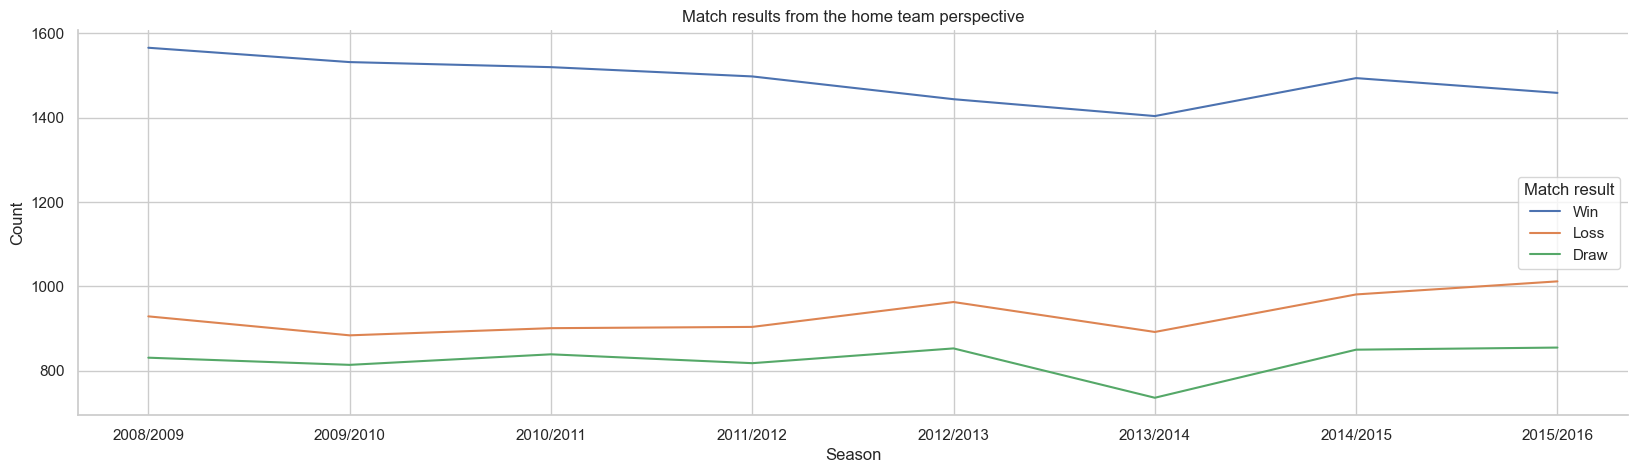

In [60]:
seasonal_mr = (df_wide
 [['season', 'match_result']]
 .groupby('season')
 .match_result
 .value_counts()
 .reset_index()
)

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(seasonal_mr, x='season', y='count', hue='match_result', ax=ax)
ax.set_title('Match results from the home team perspective')
ax.set_ylabel('Count')
ax.set_xlabel('Season')
ax.legend(title='Match result');

- The trend follows through all of the seasons.
- The gap seems to get a little smaller with time.

Having some idea of proportions of outcomes is already valuable information that could potentially be used to inform a betting strategy. We should also quantify how much these numbers deviate per specific league.

## Outcomes by league

In [61]:
league_mr = (df_wide
 [['league', 'match_result']]
 .groupby('league')
 .match_result
 .value_counts(normalize=True)
 .mul(100)
 .reset_index()
)

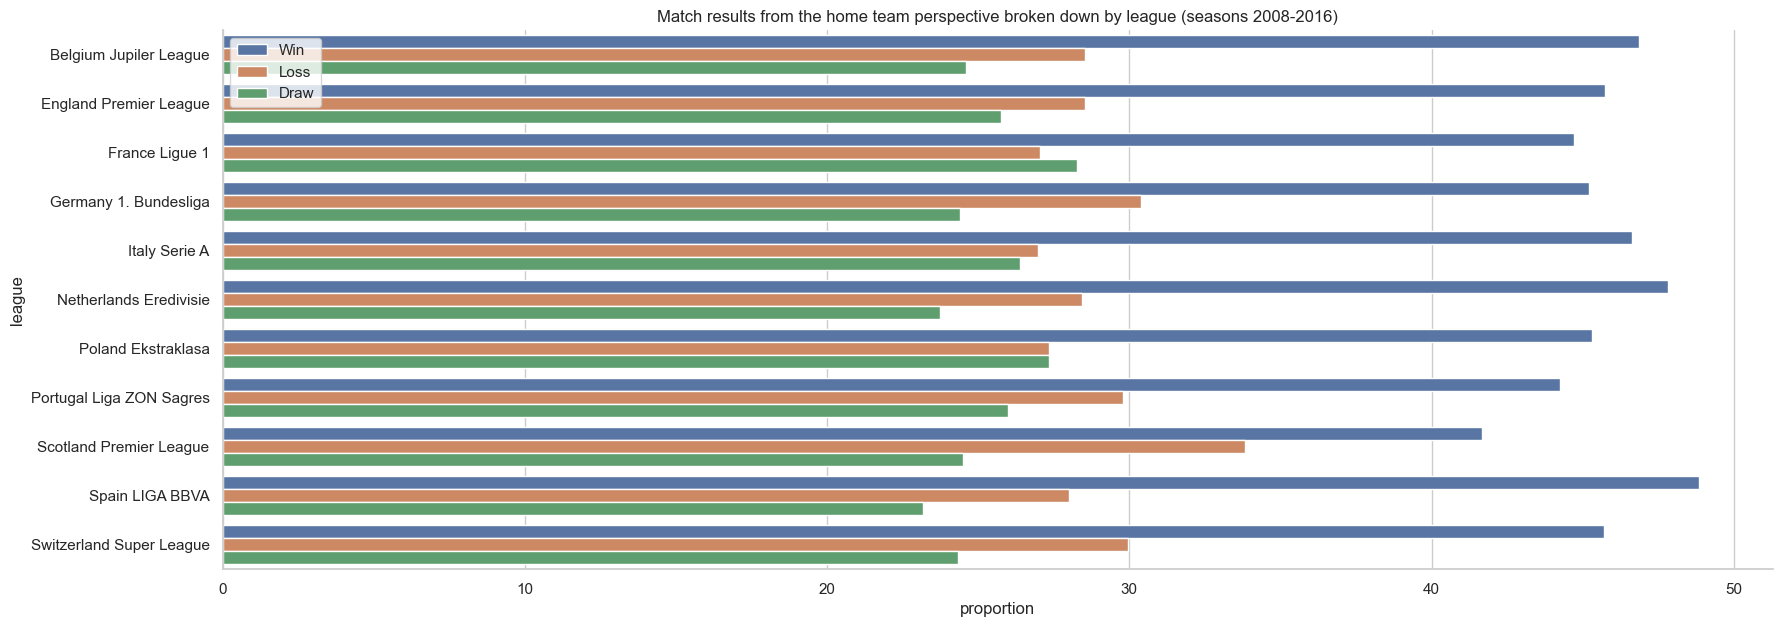

In [62]:
plt.figure(figsize=(20, 7))
ax = sns.barplot(league_mr, y='league', x='proportion', hue='match_result')
ax.legend(loc='upper left')
ax.set_title('Match results from the home team perspective broken down by league (seasons 2008-2016)');

- In all of the cases it seems that the home team is more substantially likely to win.

## Team attribute comparison

We can futher inspect the manifestation of home advantage in team attributes. The team attributes were merged by the closest date to the match so this comes with potential error, especially given that we want the exact measurements on the day of the match in this case. However, this might still help us in raising questions.

In [63]:
coloi = ['buildUpPlaySpeed', 'buildUpPlayPassing', 'chanceCreationPassing',
 'chanceCreationCrossing', 'chanceCreationShooting', 'defencePressure', 'defenceAggression']

home_cols = [f'home_{i}' for i in coloi]
away_cols = [f'away_{i}' for i in coloi]

We include only the numeric columns. buildUpPlayDribbling will be dropped because most of the data is missing.

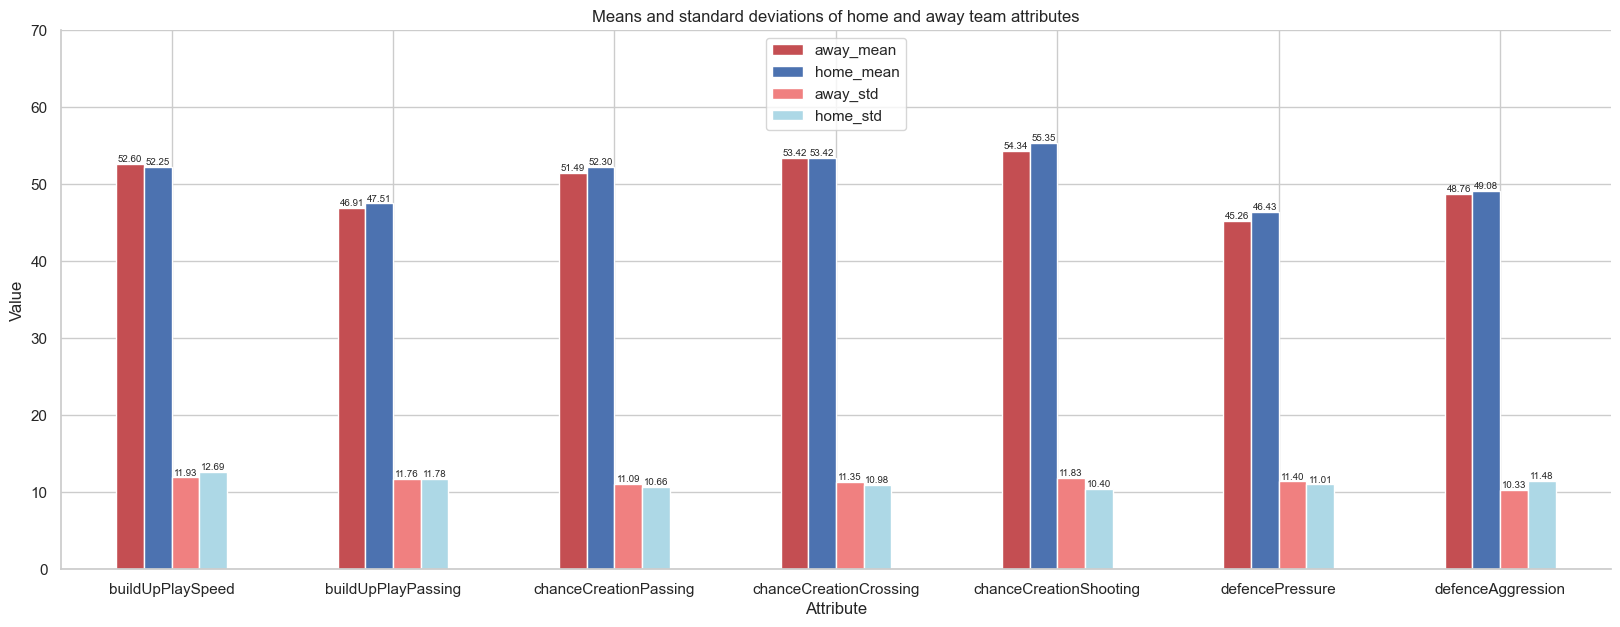

In [64]:
ta_stats = pd.DataFrame({'attribute': coloi,
              'away_mean': df_wide[away_cols].dropna().mean().values,
             'home_mean': df_wide[home_cols].dropna().mean().values,
             'away_std': df_wide[away_cols].dropna().std().values,
             'home_std': df_wide[home_cols].dropna().std().values})

ax = ta_stats.plot.bar(x='attribute', figsize=(20,7), rot=0,
    color=['r', 'b', 'lightcoral', 'lightblue'], ylabel='Value', xlabel='Attribute')

ax.legend(loc = 'upper center')
ax.bar_label(ax.containers[0], fontsize=7, fmt='{:.2f}')
ax.bar_label(ax.containers[1], fontsize=7, fmt='{:.2f}')
ax.bar_label(ax.containers[2], fontsize=7, fmt='{:.2f}')
ax.bar_label(ax.containers[3], fontsize=7, fmt='{:.2f}')
ax.set_title('Means and standard deviations of home and away team attributes')
ax.set_ylim(0, 70);

- The differences are very slight, however, again, this data is not very reliable.

# Winning

One of the rudimentry pieces of insight would follow from the question: which teams win the most games?

In [65]:
df_wide['winner'] = df_wide.apply((lambda row: row['home_team'] 
                                   if row['match_result'] == 'Win' 
                                   else 
                                   (row['away_team'] 
                                    if row['match_result'] == 'Loss' 
                                    else None)),
                                  axis=1)

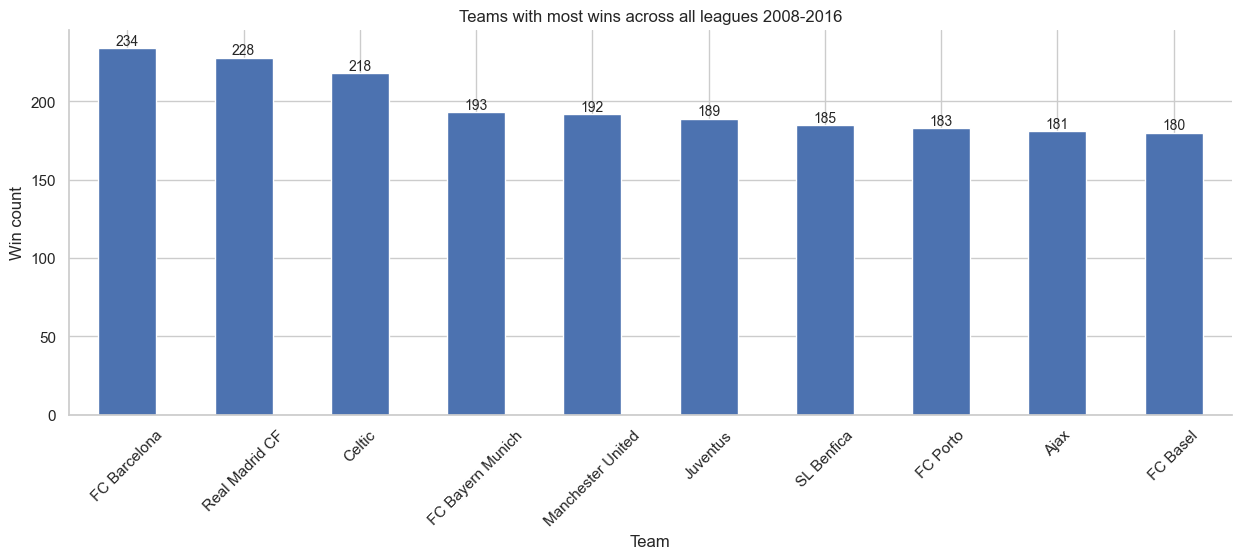

In [66]:
top10_winners = df_wide['winner'].value_counts().nlargest(10)
ax = top10_winners.plot(kind='bar', figsize=(15,5), rot=45)
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_title('Teams with most wins across all leagues 2008-2016')
ax.set_xlabel('Team')
ax.set_ylabel('Win count');

- FC Barcelona, Real Madrid and Celtic are the most dominant teams of all of the leagues.

# Betting Odds

## General summary

In [67]:
betting_companies = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD',
                     'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA',
                     'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
                     'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH',
                     'GBD', 'GBA', 'BSH', 'BSD', 'BSA']

There are 10 betting companies with home win, draw and away win odds.

## Missing values

Grouping by league and season to see what proportion of data is missing in those respects:

In [68]:
index_array = np.r_[betting_companies, ['league', 'season']]
bet_cols_l_s = df_wide.loc[:, index_array]

In [69]:
percent = lambda x: x.isna().sum() / (x.notna().sum() + x.isna().sum()) * 100

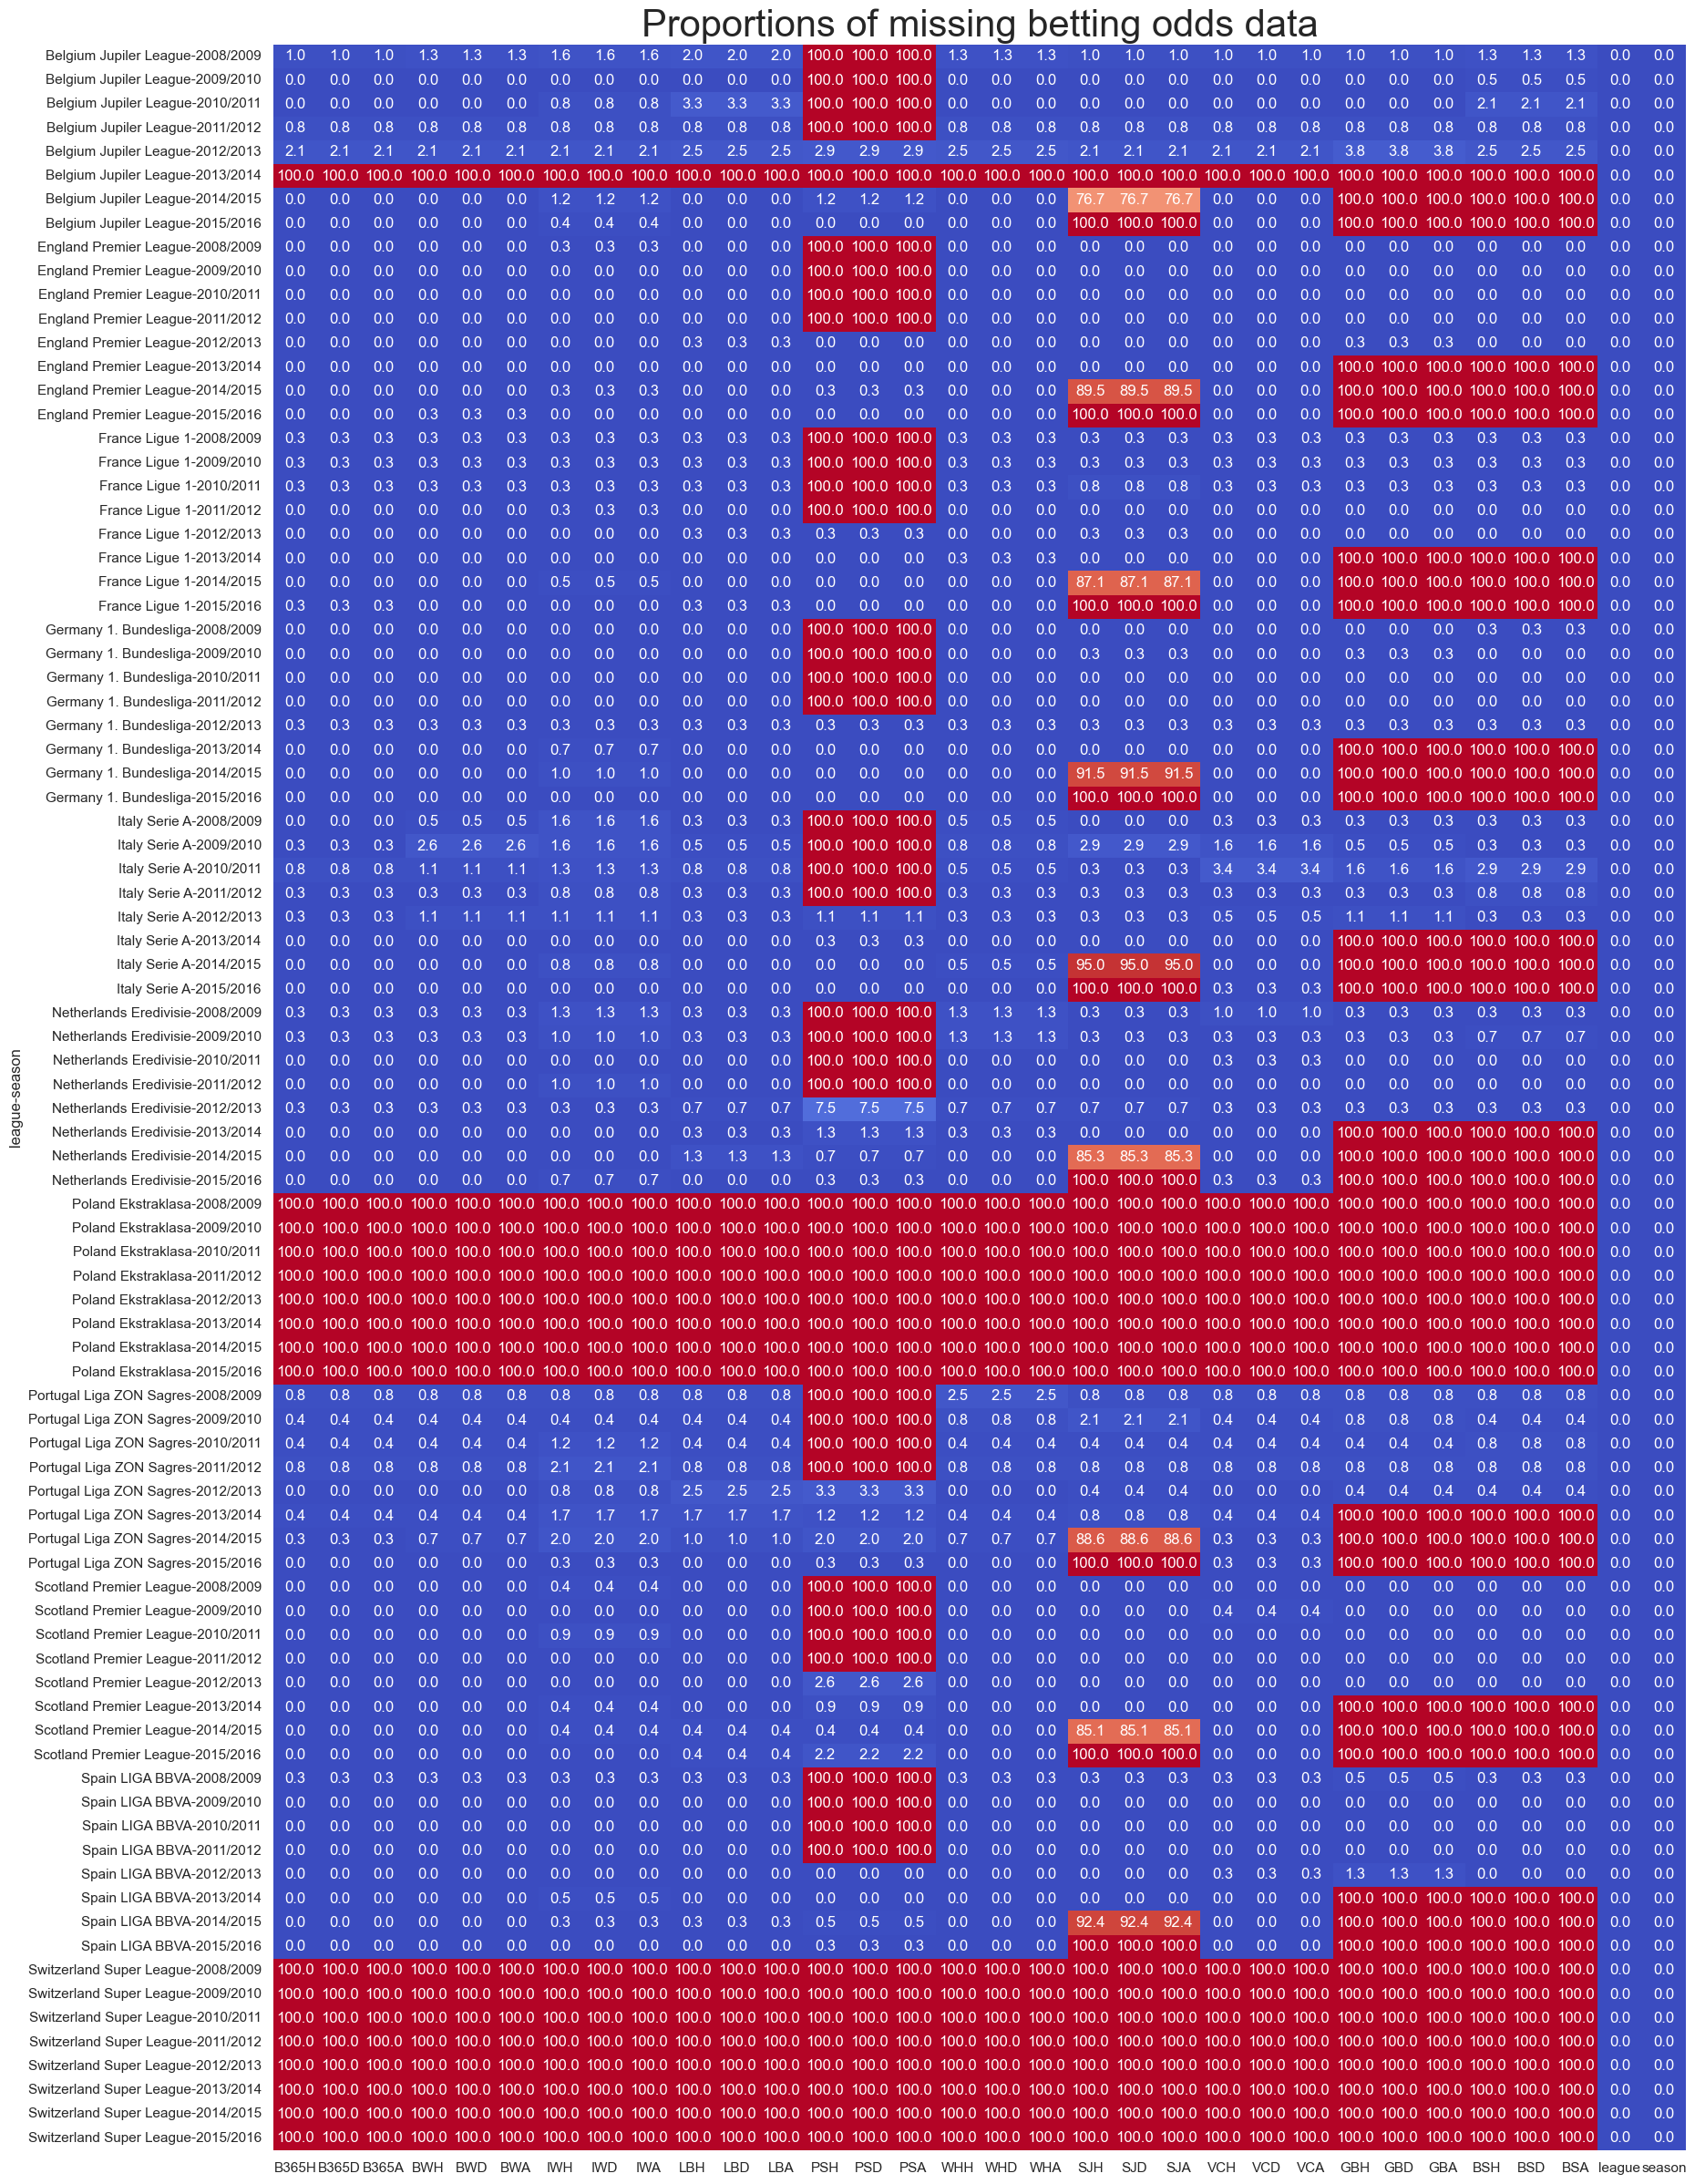

In [70]:
plt.figure(figsize=(20, 30))
ax = sns.heatmap((bet_cols_l_s.groupby(['league', 'season'])[bet_cols_l_s.columns]
                  .apply(percent)), annot=True, fmt=".1f", cbar=False, cmap='coolwarm')
ax.set_title('Proportions of missing betting odds data', fontsize=30);

Poland's and Switzerland's leagues have no betting odds data. There are quite a large amount of data missing for specific betting companies. We also see that for certain seasons data from certain odds is totally or nearly totally missing.

## Odd accuracy

If we were to use this data to better understand how to run a betting company, the most useful insight could be derived from betting odds. We can use the lowest odd for the outcome to understand which of the possible match outcomes the company is betting on the most. Again we are viewing everything from the home team perspective.

In [71]:
index_array

array(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD',
       'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD',
       'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD',
       'GBA', 'BSH', 'BSD', 'BSA', 'league', 'season'], dtype='<U6')

In [72]:
odds = (
    df_wide
 .loc[:, np.r_[index_array, ['match_result']]]
        .copy()
)

In [73]:
odds['temp_id'] = range(len(odds))

In [74]:
odds = pd.melt(odds, id_vars=['match_result', 'league', 'season', 'temp_id'],
               var_name='bookmaker_odds', value_name='odds') # Melting to avoid declaring everything

In [75]:
odds.dropna(subset='odds', inplace=True)

In [76]:
odds['bookmaker'] = odds['bookmaker_odds'].str[:-1]

In [77]:
idx = odds.groupby(['temp_id', 'bookmaker'])['odds'].idxmin().values
min_odds = odds.loc[idx] 

In [78]:
def odd_correct(row):
    
    if row['bookmaker_odds'].endswith('H') and row['match_result'] == 'Win':
        return 'Correct'
    if row['bookmaker_odds'].endswith('D') and row['match_result'] == 'Draw':
        return 'Correct'
    if row['bookmaker_odds'].endswith('A') and row['match_result'] == 'Loss':
        return 'Correct'
    else:
        return 'Incorrect'

In [79]:
min_odds['odd_correct'] = min_odds.apply(odd_correct, axis=1)

In [80]:
correct_ind_count = (pd.DataFrame(
    min_odds
    .groupby('bookmaker')['odd_correct']
    .value_counts(normalize=True)
    .mul(100)
 .reset_index())
)

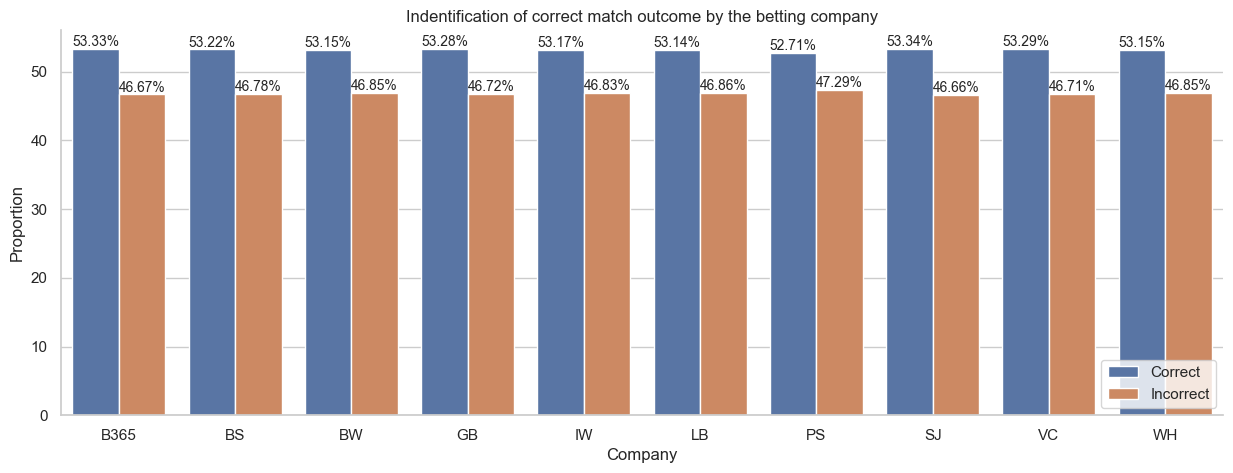

In [81]:
plt.figure(figsize=(15,5))
ax = sns.barplot(correct_ind_count, x='bookmaker', y='proportion', hue='odd_correct', legend='brief')
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:.2f}%')
ax.bar_label(ax.containers[1], fontsize=10, fmt='{:.2f}%')
ax.legend(loc='lower right')
ax.set_title('Indentification of correct match outcome by the betting company')
ax.set_ylabel('Proportion')
ax.set_xlabel('Company');

- All of the betting companies identify the most likely outcome correctly around 53% of the time(PS is slightly lower, however, there is a good chunk of data missing). This number is solely derived from bookmakers setting the lowest odds for the correct outcome and does not encapsulate the degree to which that number is set to.
- SJ and B365 seem to set the lowest odds the most correctly, though in SJ's case a sizeable chunk of data was dropped.

The next step could be to to evaluate how the accuracy of the outcome prediction evolves. Perhaps factors like the development of technology and use of data-driven tactics would give bookmakers an edge in predicting the most probable match outcome?

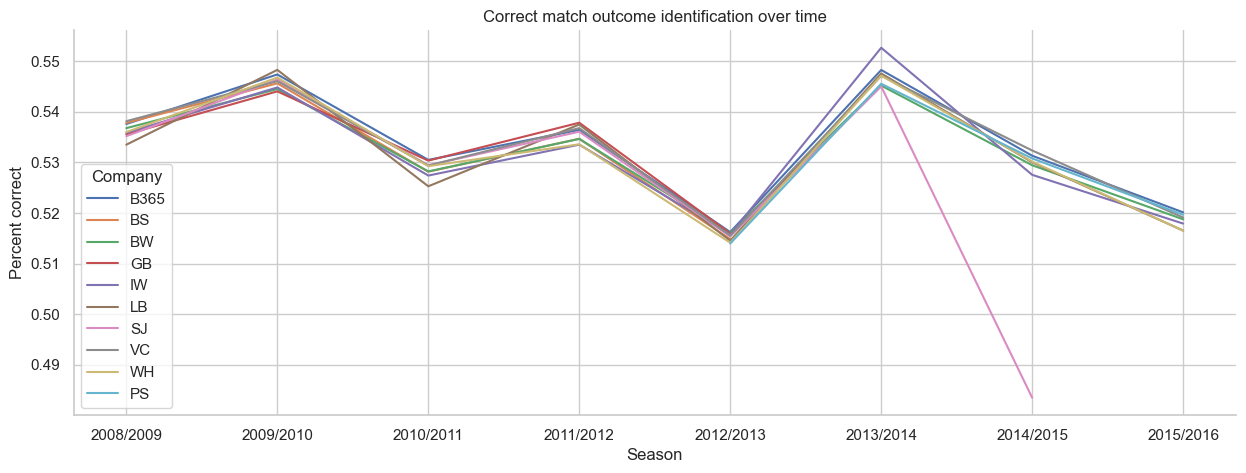

In [82]:
plt.figure(figsize=(15,5))
timewise_odd_corr = (min_odds
 .groupby(['season', 'bookmaker'])
 ['odd_correct']
 .value_counts(normalize=True)
 .reset_index()
)
timewise_odd_corr = timewise_odd_corr[timewise_odd_corr['odd_correct'] == 'Correct']
ax = sns.lineplot(timewise_odd_corr, x='season', hue='bookmaker', y='proportion', legend='brief')
ax.set_title('Correct match outcome identification over time')
ax.set_ylabel('Percent correct')
ax.set_xlabel('Season')
ax.legend(title='Company');

Looking back at the heatmap, a lot of data on SJ is missing, therefore, explaining the spike down.
- No specific discernable trend is found over this period of time.

Next, we could identify, in which scenarios betting companies set the lowest odd wrong.

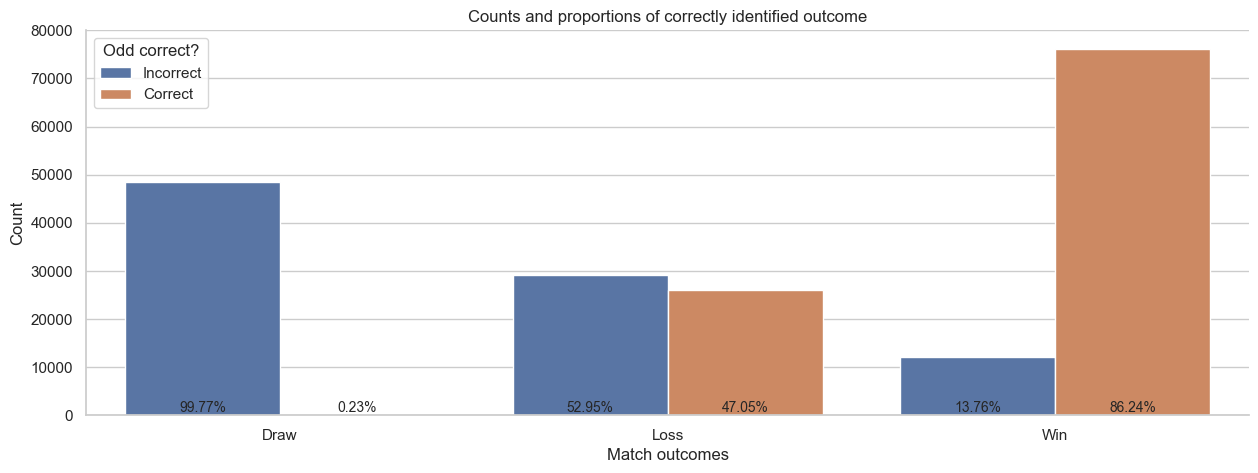

In [83]:
corr_type = (min_odds
 .groupby('match_result')['odd_correct']
 .value_counts()
 .reset_index()
            )

corr_type['percentage'] = (corr_type
                           .groupby('match_result')['count']
                           .apply(lambda x: x / x.sum() * 100)
                           .values
                          )

plt.figure(figsize=(15,5))

ax = sns.barplot(corr_type, x='match_result', y='percentage', hue='odd_correct')
sns.barplot(corr_type, x='match_result', y='count', hue='odd_correct', legend=False)

ax.bar_label(ax.containers[0], fontsize=10, fmt='{:.2f}%')
ax.bar_label(ax.containers[1], fontsize=10, fmt='{:.2f}%')

ax.set_title('Counts and proportions of correctly identified outcome')
ax.legend(title='Odd correct?')
ax.set_ylabel('Count')
ax.set_xlabel('Match outcomes')
ax.set_ylim(0, 80000);

- We see that betting companies very rarely bet on the teams drawing, even though, as we saw before, the amount of drawn games in the dataset is over 25%.
- Companies predict home wins much better (86.24% accuracy) than the rest of scenarios.

We can further break this down by individual company.

In [84]:
odds_by_bm = (min_odds
 .groupby(['match_result', 'bookmaker'])['odd_correct']
 .value_counts(normalize=True)
 .mul(100)
 .reset_index())

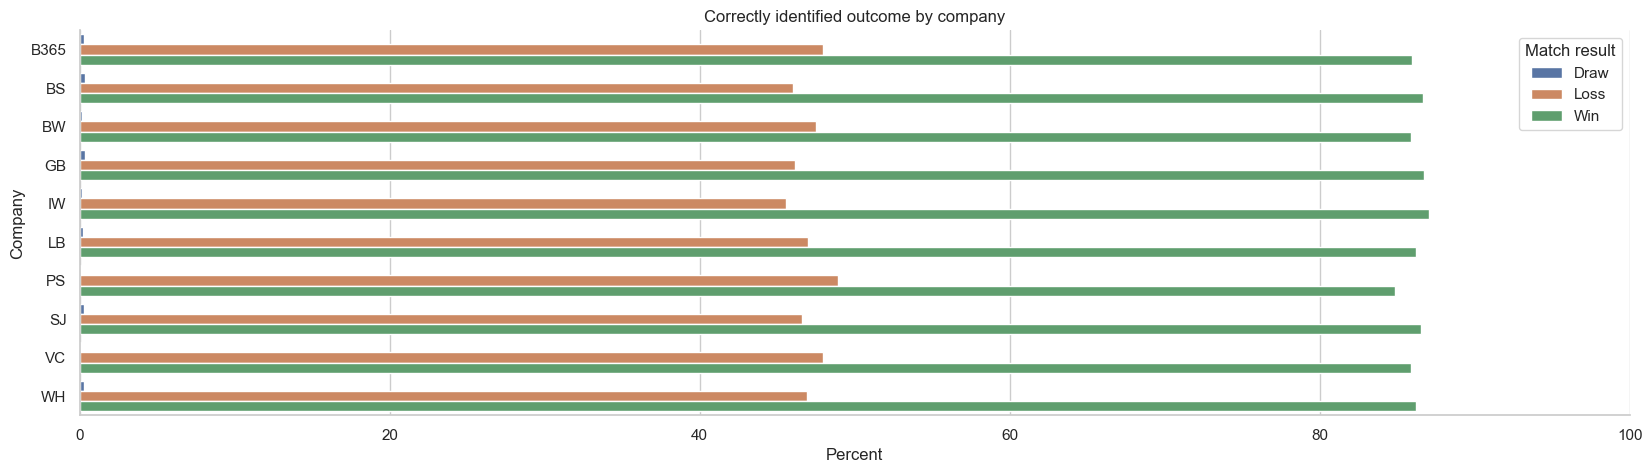

In [85]:
plt.figure(figsize=(20, 5)) 
corr_bm = odds_by_bm[odds_by_bm['odd_correct'] == 'Correct']
ax = sns.barplot(corr_bm, y='bookmaker', x='proportion', hue='match_result')
ax.set_xlabel('Percent')
ax.set_ylabel('Company')
ax.set_xlim(0, 100)
ax.set_title('Correctly identified outcome by company')
ax.legend(title='Match result');

- Similar trends follow for all of the bookmakers.

## Brier's score

While examining the lowest odd helps us to understand the sentiment of the bookmaker, it doesn't account for the degree to which the odds are set falsely, nor for how close or spread apart the odds are. We can use Brier's score to encapsulate this degree better.

$$\text{Brier Score (BS)} = \frac{1}{N} \sum_{i=1}^N (p_i - o_i)^2$$

In [86]:
min_odds['probability'] = 1 / min_odds['odds'] # Converting odds to probabilities

In [87]:
min_odds['bs'] = (min_odds # Brier score for each odd
                  .apply(
                      lambda x: (x['probability'] - 1) ** 2
                      if x['odd_correct'] == 'Correct'
                      else  x['probability'] ** 2, axis=1)
                 )

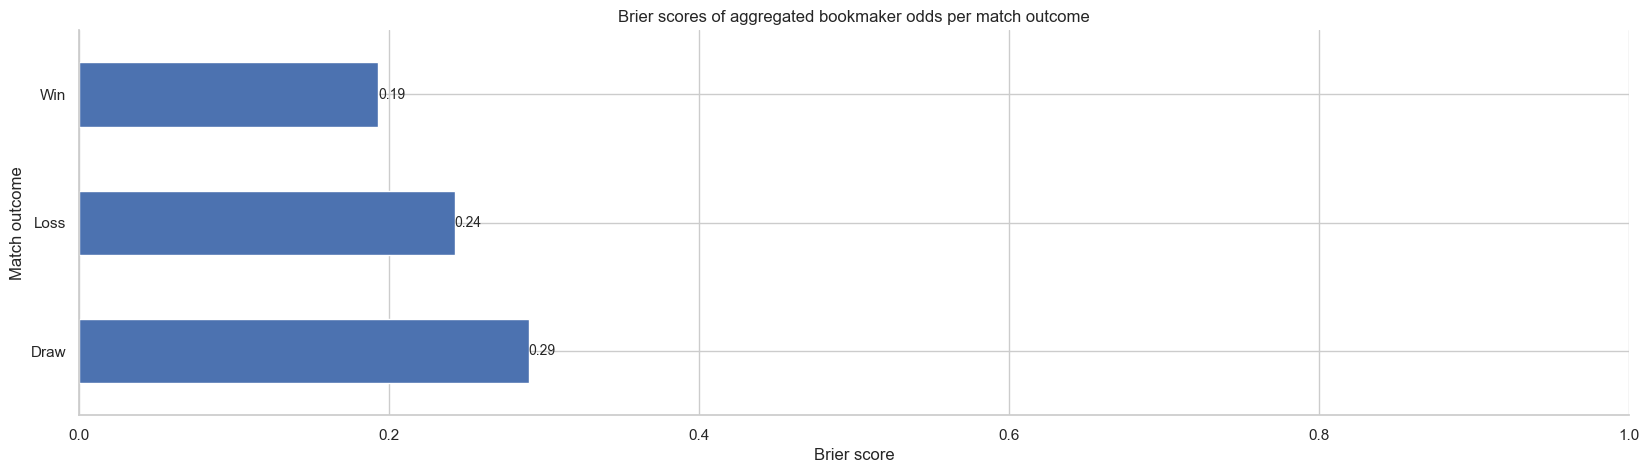

In [88]:
plt.figure(figsize=(20,5))
ax = min_odds.groupby('match_result')['bs'].mean().plot(kind='barh') # Plotting mean Brier scores
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:.2f}')
ax.set_xlim(0,1)
ax.set_title('Brier scores of aggregated bookmaker odds per match outcome')
ax.set_ylabel('Match outcome')
ax.set_xlabel('Brier score');

The lower the Brier score the less error there is in forcast odds, with score of 0 meaning perfect forcasting and 1 the opposite. We see that, in terms of magnitude that the odds are cast forth, differences in accuracy per each outcome are not nearly as radical as in previous analysis of lowest-set odd. \
We could try to see if a specific bookmaker fails to set correct odd ratios:

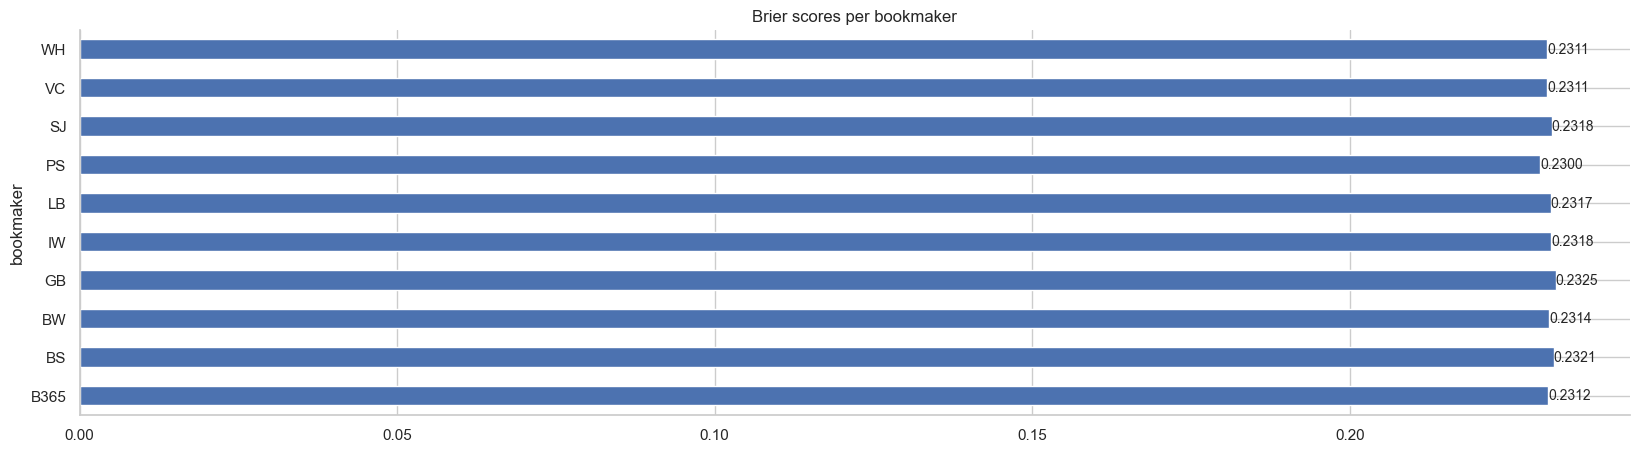

In [89]:
plt.figure(figsize=(20,5))
bookmaker_bs_means = min_odds.groupby('bookmaker')['bs'].mean()
ax = bookmaker_bs_means.plot(kind='barh') 
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:.4f}')
ax.set_title('Brier scores per bookmaker');

In [90]:
bookmaker_bs_means.idxmin(), bookmaker_bs_means.idxmax()

('PS', 'GB')

There is very little difference in error between bookmakers over all outcomes. Though PS and GB have the minimum and maximum error respectively.

We can next examine how bookmakers deal with setting odds for each match outcome:

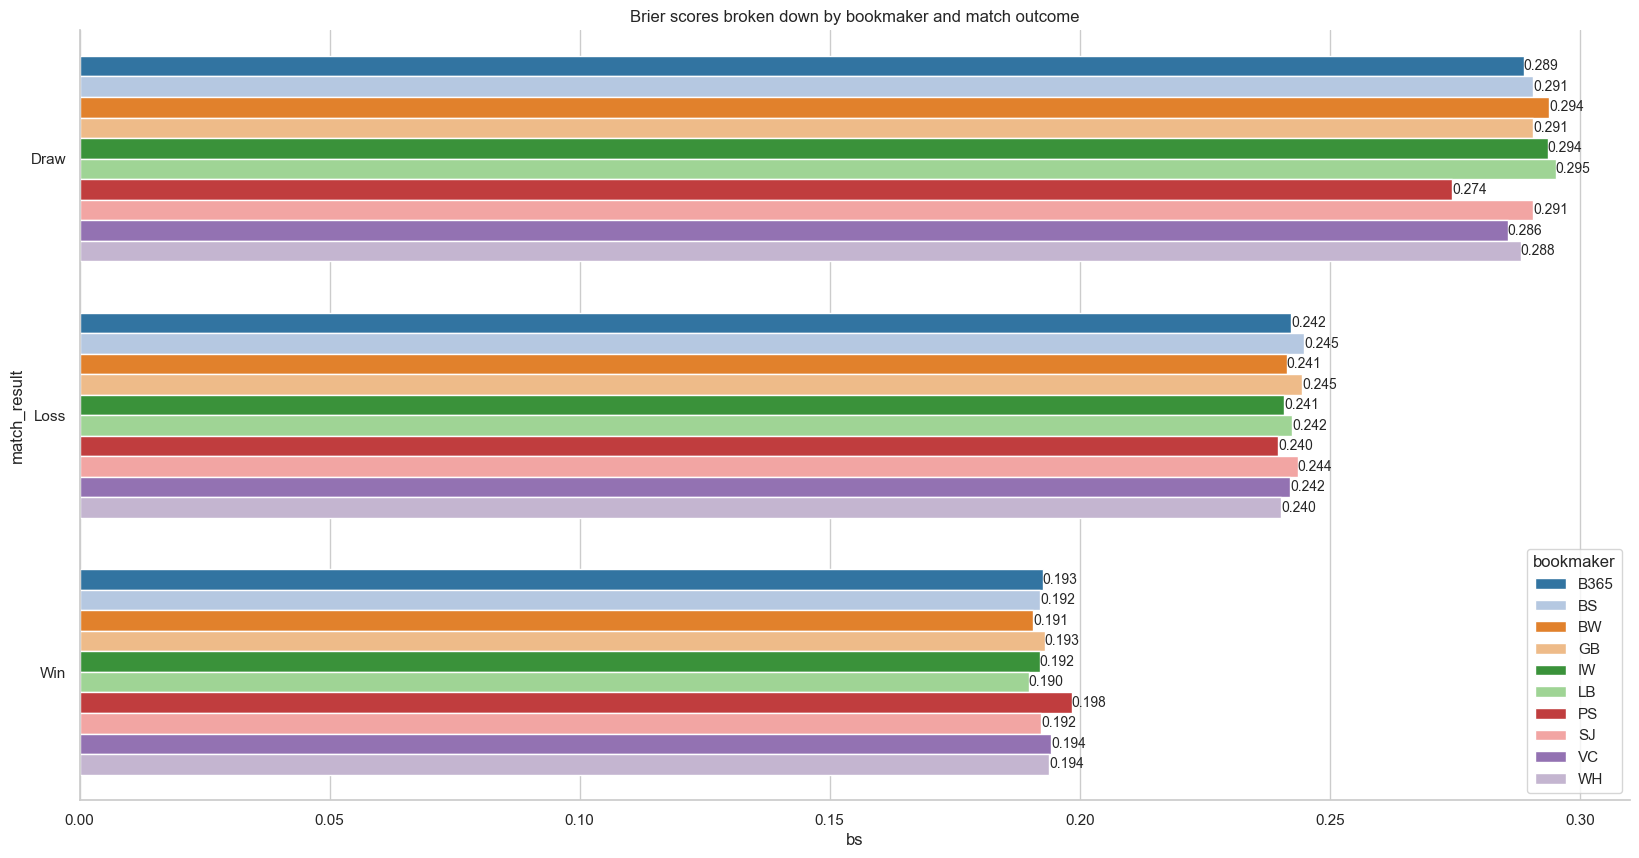

In [91]:
plt.figure(figsize=(20,10))
bm_res_bs = min_odds.groupby(['bookmaker', 'match_result'])['bs'].mean().reset_index()
ax = sns.barplot(bm_res_bs, y='match_result', x='bs', hue='bookmaker', palette='tab20')
for i in range(len(bm_res_bs.bookmaker.unique())):
    ax.bar_label(ax.containers[i], fontsize=10, fmt='{:.3f}')
ax.set_title('Brier scores broken down by bookmaker and match outcome');

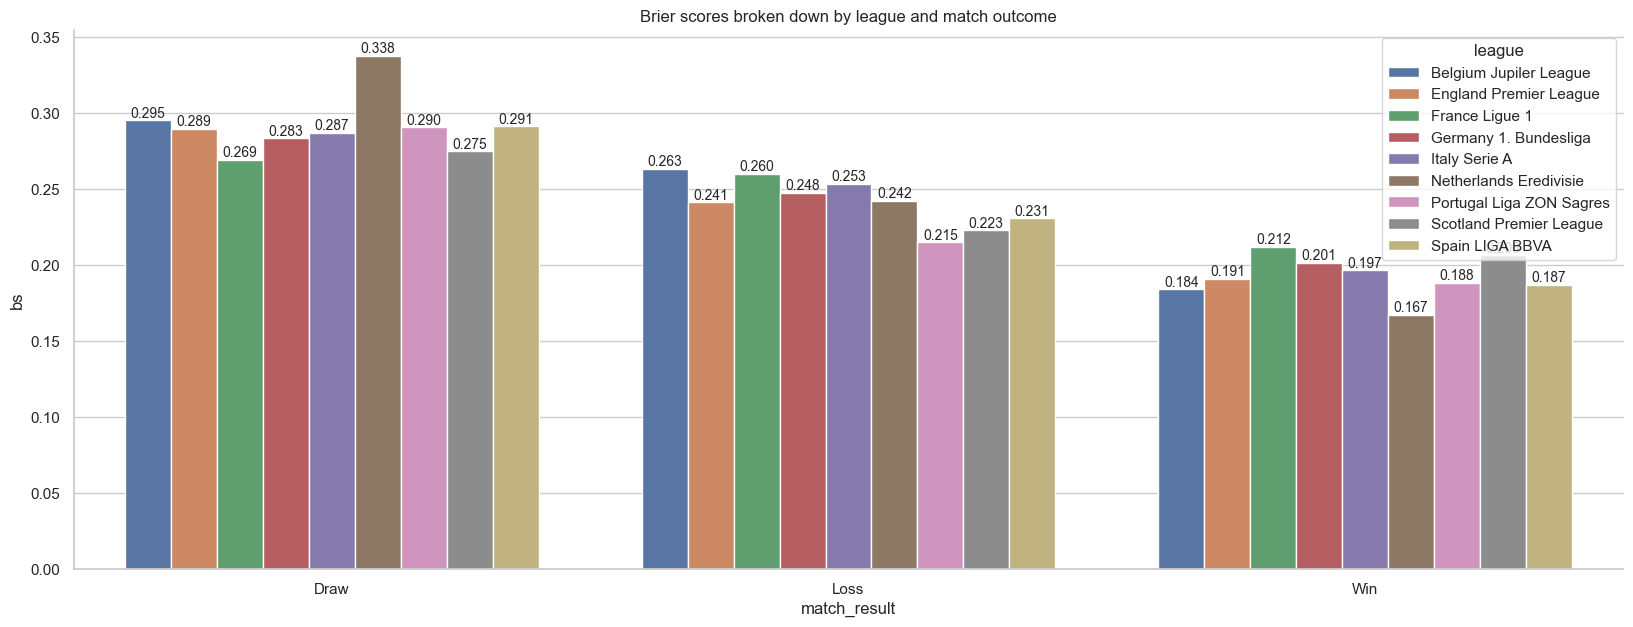

In [92]:
plt.figure(figsize=(20, 7))
ax = sns.barplot((min_odds
             .groupby(['league','match_result'])['bs']
             .mean()
             .reset_index()
            ), x='match_result', y='bs', hue='league')
for i in range(len(min_odds.league.unique())):
    ax.bar_label(ax.containers[i], fontsize=10, fmt='{:.3f}')
ax.set_title('Brier scores broken down by league and match outcome');

- Bookmakers make considerably more error for Netherland's league when setting odds for drawn matches, on the other hand, considerably less for wins.

# Team attributes

## Team attribute comparison

In [93]:
coi3 = ['home_buildUpPlaySpeed', 'home_buildUpPlayDribbling',
        'home_buildUpPlayPassing','home_chanceCreationPassing',
       'home_chanceCreationCrossing', 'home_chanceCreationShooting',
        'home_defencePressure', 'home_defenceAggression', 'home_team_goal', 'home_team']

In [94]:
team_attributes_h = df_wide[coi3].copy()

buildUpPlayDribbling has most of the data missing, therefore unusable. The rest of the columns have a negligible amount of data missing.

In [95]:
team_attributes_h.drop('home_buildUpPlayDribbling', axis=1, inplace=True)

In [96]:
team_attributes_h.dropna(inplace=True)

In [97]:
coi4 = [i.replace('home', 'away') for i in coi3]
team_attributes_a = df_wide[coi4].copy()
team_attributes_a.drop('away_buildUpPlayDribbling', axis=1, inplace=True)
team_attributes_a.dropna(inplace=True)

In [98]:
team_attributes_hs = team_attributes_h.copy()
team_attributes_as = team_attributes_a.copy()
team_attributes_hs.columns = [i.replace('home_', '') for i in team_attributes_hs.columns]
team_attributes_as.columns = [i.replace('away_', '') for i in team_attributes_as.columns]

In [99]:
team_attributes_s = pd.concat([team_attributes_hs, team_attributes_as], ignore_index=True)

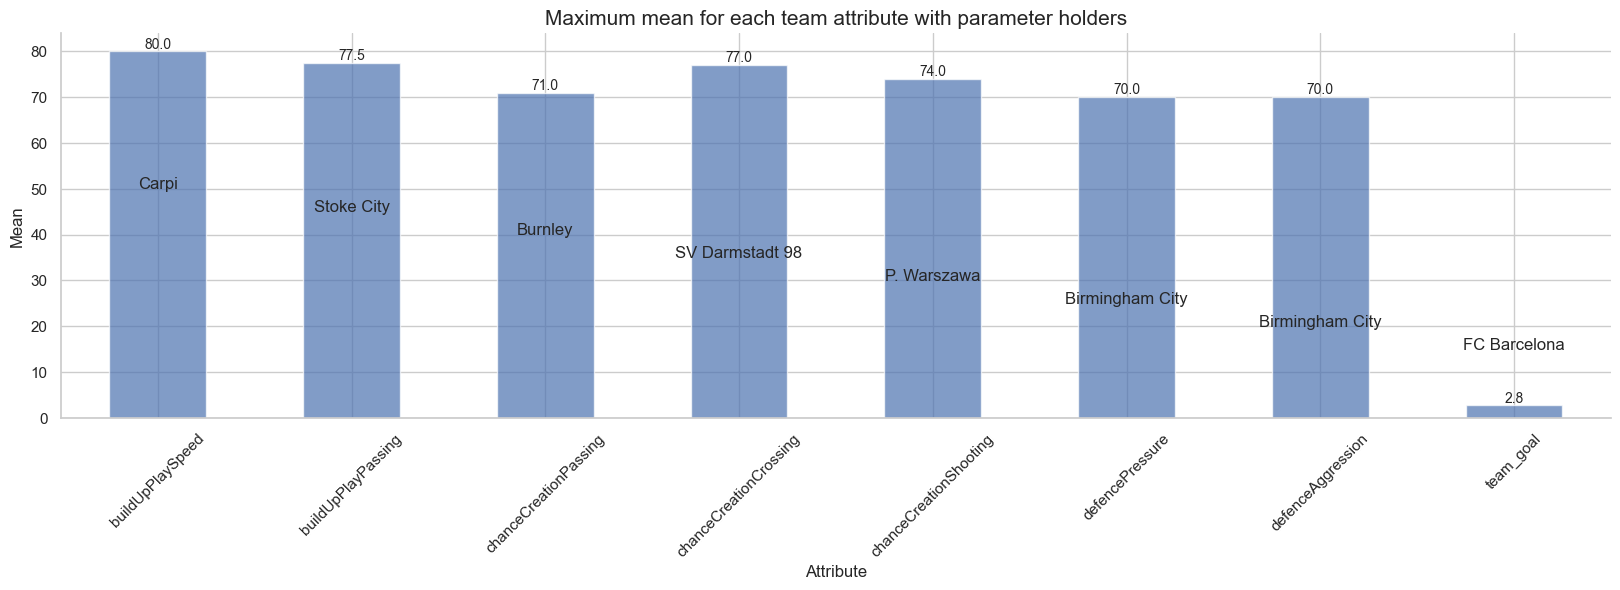

In [100]:
ta_stats = pd.concat(
    [team_attributes_s.groupby('team').mean().max(),
     team_attributes_s.groupby('team').mean().idxmax()],
    axis=1)
ta_stats.columns = ['mean_metric', 'team']
ax = ta_stats.reset_index().plot(kind='bar', x='index', y='mean_metric', rot=45, figsize=(20,5), alpha=0.7, legend=False)
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:.1f}')
for i in range(len(ta_stats['team'])): 
    ax.text(i, 50 - i*5, ta_stats.iloc[i, 1], ha='center')
ax.set_title('Maximum mean for each team attribute with parameter holders', fontsize=15)
ax.set_ylabel('Mean')
ax.set_xlabel('Attribute');

Before, we saw most dominant teams in terms of winning out of all of the leagues. By comparing their attributes with the average we could attempt to discern some patterns.

In [101]:
tt_vs_at = pd.concat([(team_attributes_s[team_attributes_s['team']
                       .isin(top10_winners.index[:3])]
                       .select_dtypes(['number'])
                       .mean()),
          team_attributes_s.select_dtypes(['number']).mean()], axis=1)
tt_vs_at.columns = ['top_team', 'average_team']

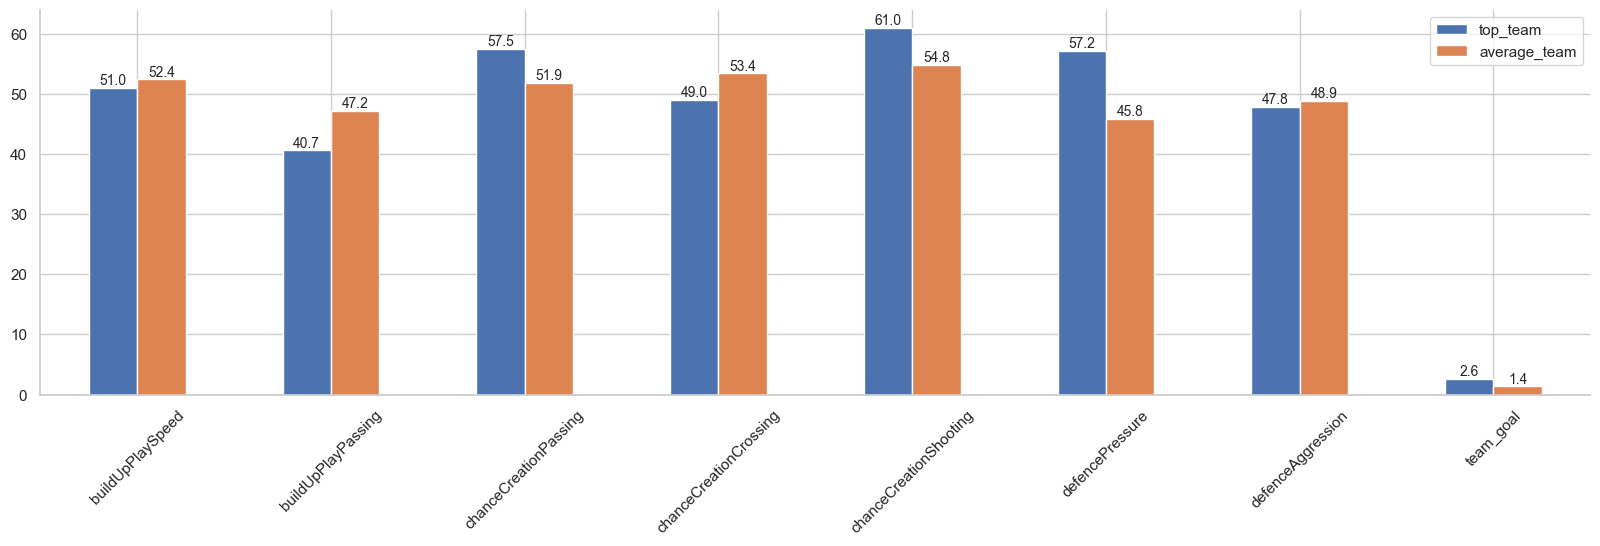

In [102]:
ax = tt_vs_at.plot(kind='bar', figsize=(20,5), rot=45)
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:.1f}')
ax.bar_label(ax.containers[1], fontsize=10, fmt='{:.1f}');

- Top 3 teams exhibit more chance creation shooting and passing and defence pressure compared to an average team.
- In terms of the other attributes top 3 teams are below average.

## Correlation of attributes with the score

We make a choice to average the team attributes and goals to reduce noise and generalize the underlying pattern.

In [103]:
team_attributes_hg = (team_attributes_h
                   .groupby('home_team')
                   .apply('mean')
                   .reset_index()
                   .drop('home_team', axis=1)
                  )

In [104]:
team_attributes_ag = (team_attributes_a
                   .groupby('away_team')
                   .apply('mean')
                   .reset_index()
                   .drop('away_team', axis=1)
                  )

Including the opposite team goals as well:

In [105]:
team_attributes_hg['away_team_goal'] = team_attributes_ag['away_team_goal']
team_attributes_ag['home_team_goal'] = team_attributes_hg['home_team_goal']

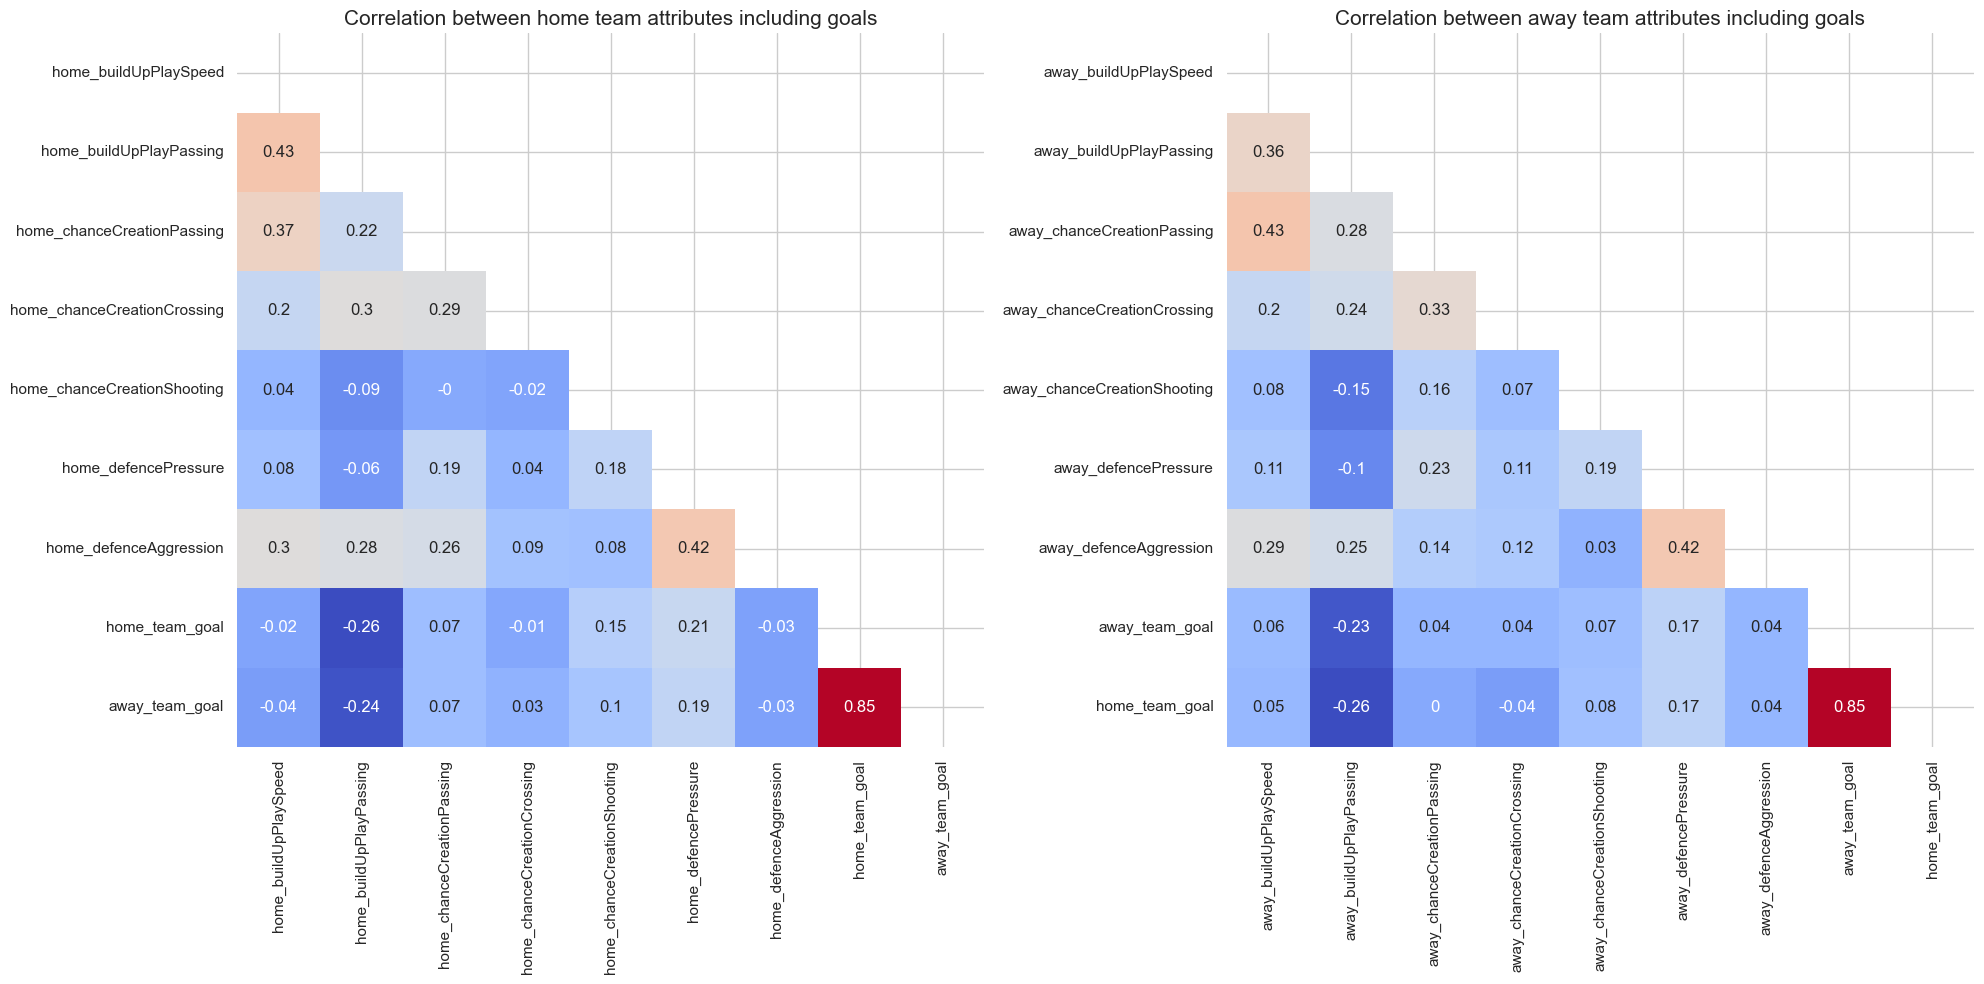

In [106]:
fig, axs = plt.subplots(1,2, figsize=(20,10), sharey=False)

ta_matrix_h = team_attributes_hg.corr().round(decimals=2)
ta_mask_h = np.triu(np.ones_like(ta_matrix_h, dtype=bool))
ax_h = sns.heatmap(ta_matrix_h, annot=True, mask=ta_mask_h, ax=axs[0], cbar=False, cmap='coolwarm')
ax_h.set_title('Correlation between home team attributes including goals', fontsize=15)

ta_matrix_a = team_attributes_ag.corr().round(decimals=2)
ta_mask_a = np.triu(np.ones_like(ta_matrix_a, dtype=bool))
ax_a = sns.heatmap(ta_matrix_a, annot=True, mask=ta_mask_a, ax=axs[1], cbar=False, cmap='coolwarm')
ax_a.set_title('Correlation between away team attributes including goals', fontsize=15)
plt.tight_layout()

- Amount of goals scored has a strong positive correlation with the amount of goals that the opposite team scores.
- Buildup play passing has a low negative correlation to scoring. Which might suggest that a slow and careful playing style with short passes is less likely to result in a goal. The correlation is slightly weaker from an away team position.
- Defence pressure has a weak positive correlation with scoring. 
- There is a weak correlation of chance creation shooting and scoring which is only present for home players but not for the away.
- The correlations are nevertheless weak and the causality is not clear.
- Away buildup play passing and defence pressure weakly negatively/positively correlate with home team goals. Though the correlation pattern is very similar for away team goals too, therefore it seems that the confounding variable of amount of goals scored is creating the effect.\
**NOTE**: These attributes were averaged across all seasons, therefore the analysis is not very granular to say the least.

# Player attributes

In [107]:
player_attributes = pd.read_sql_query(
"""
   select *
   from player_attributes pa
   join player p
   on p.player_api_id = pa.player_api_id
""", con)

In [108]:
dups = player_attributes.duplicated(subset=['player_name', 'date'])
dups.sum()

2151

In [109]:
player_attributes = player_attributes[~dups].copy()

In [110]:
(player_attributes.isna().sum()
 / (player_attributes.isna().sum()
 + player_attributes.notna().sum())
 * 100).reset_index().T

0                   1              2     3               4   \
index   id  player_fifa_api_id  player_api_id  date  overall_rating   
0      0.0                 0.0            0.0   0.0             0.0   

              5               6                    7                    8   \
index  potential  preferred_foot  attacking_work_rate  defensive_work_rate   
0            0.0             0.0                  1.3                  0.0   

             9   ...          39              40           41   42  \
index  crossing  ...  gk_kicking  gk_positioning  gk_reflexes   id   
0           0.0  ...         0.0             0.0          0.0  0.0   

                  43           44                  45        46      47  \
index  player_api_id  player_name  player_fifa_api_id  birthday  height   
0                0.0          0.0                 0.0       0.0     0.0   

           48  
index  weight  
0         0.0  

[2 rows x 49 columns]

In [111]:
player_attributes = player_attributes.dropna()

There are multiple entries for each player. We need to aggregate them, since the players who are measured more often would skew the results.

In [112]:
player_attributes = (player_attributes
                     .groupby('player_name')
                     .apply(lambda x: x.select_dtypes(include='number')
                            .mean())
                     .reset_index()
                    )

## Highest potential

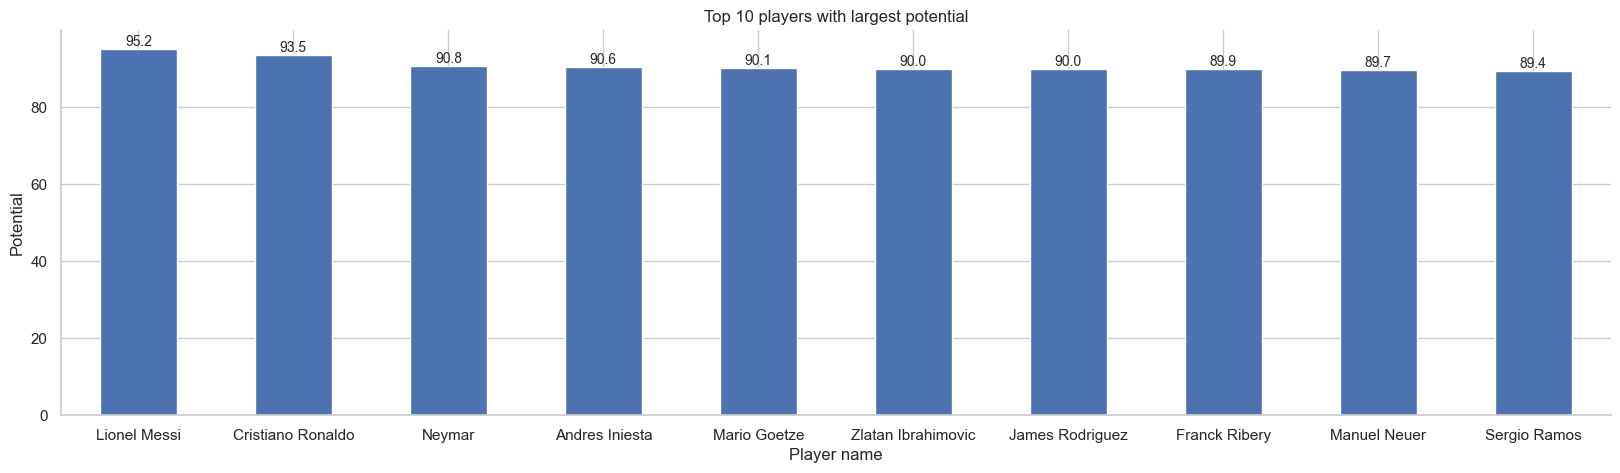

In [113]:
ax = (player_attributes
 .sort_values('potential', ascending=False)
 .head(10)
 [['player_name', 'potential']]
 .plot(kind='bar', x='player_name', y='potential', rot=0, figsize=(20,5), legend=False)
)
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:.1f}')
ax.set_title('Top 10 players with largest potential')
ax.set_ylabel('Potential')
ax.set_xlabel('Player name');

- Lionel Messi, Christiano Ronaldo and Neymar have the highest potential scores.

## Highest rating

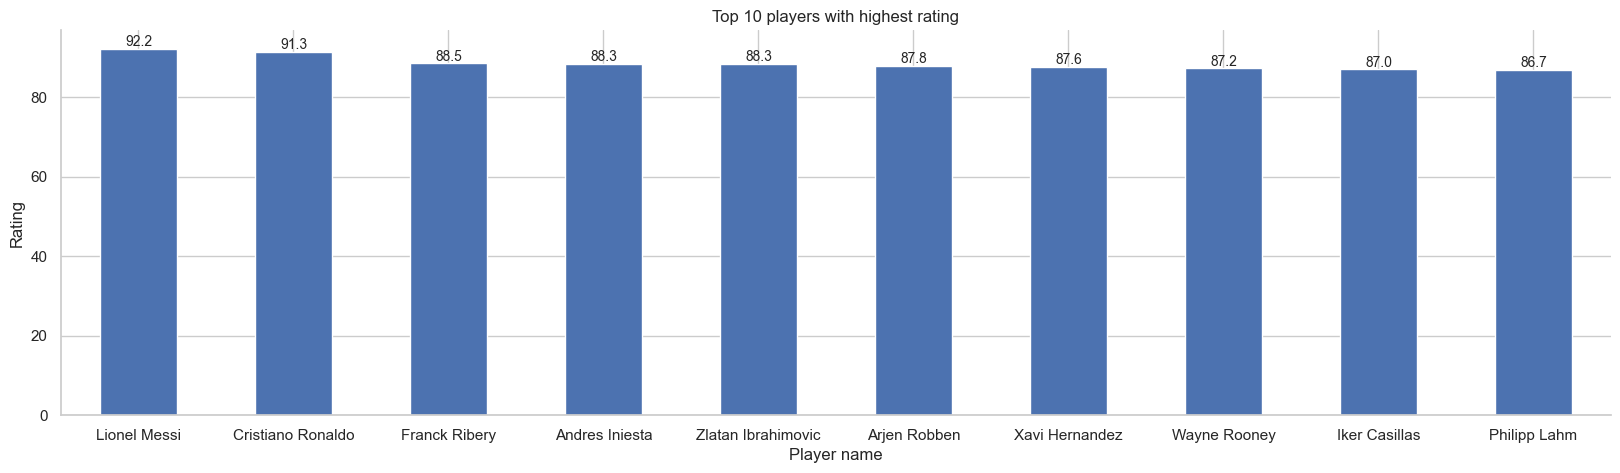

In [114]:
ax = (player_attributes
 .sort_values('overall_rating', ascending=False)
 .head(10)
 [['player_name', 'overall_rating']]
 .plot(kind='bar', x='player_name', y='overall_rating', rot=0, figsize=(20,5), legend=False)
)
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:.1f}')
ax.set_title('Top 10 players with highest rating')
ax.set_ylabel('Rating')
ax.set_xlabel('Player name');

- Messi, Ronaldo and Franck Ribery are the highest in terms of overall rating.

## Attribute comparison

The next logical step is to see which specific attributes differ most significantly between the top 10 players and the average. This could potentially provide us with insight on what exactly makes a top 10 performing player.

We will transform weight and height to BMI:

In [115]:
player_attributes['bmi'] = (player_attributes['weight'] * 0.453592) / (player_attributes['height'] * 0.1) ** 2

In [116]:
pa_cols = np.r_[player_attributes.iloc[:, 4:34].columns, ['bmi']]

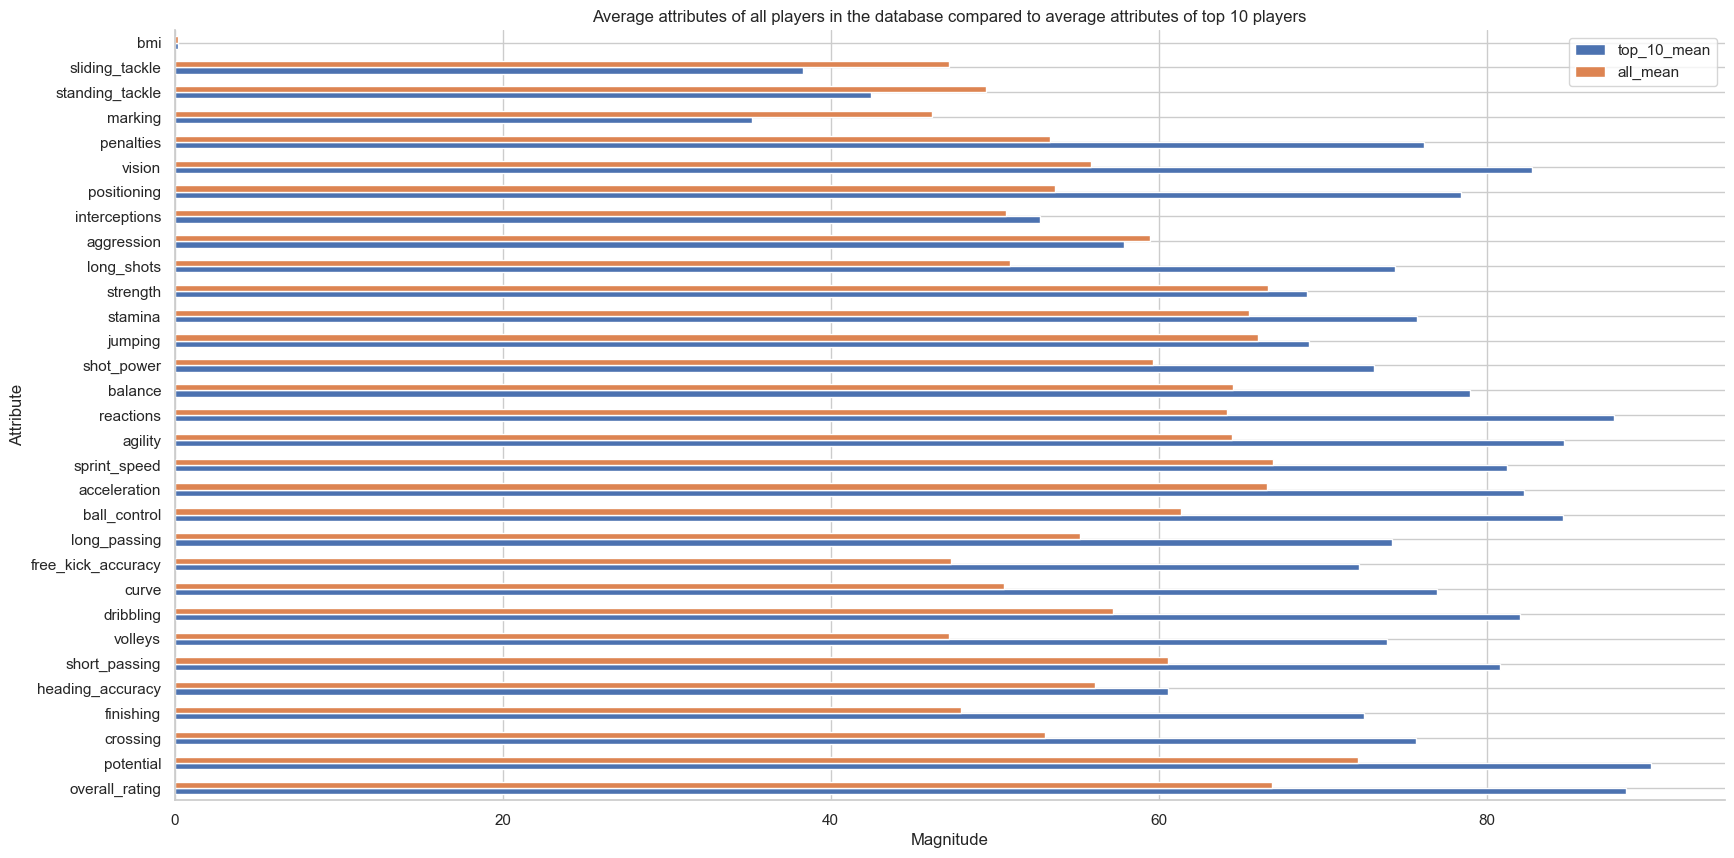

In [117]:
top_10_player_attr_mean = (
  player_attributes
 .sort_values('overall_rating', ascending=False)
 .head(10)
 [pa_cols]
 .mean()
)

player_attr_mean = player_attributes[pa_cols].mean()

(pd.DataFrame({'top_10_mean':top_10_player_attr_mean,
             'all_mean':player_attr_mean})
 .plot(kind='barh', figsize=(20, 10),
       title='Average attributes of all players in the database compared to average attributes of top 10 players',
      ylabel='Attribute', xlabel='Magnitude')
);

Largest differences:

In [118]:
pd.DataFrame((top_10_player_attr_mean - player_attr_mean).nlargest(10))

0
vision              26.87
volleys             26.70
curve               26.43
free_kick_accuracy  24.88
dribbling           24.81
positioning         24.72
finishing           24.55
reactions           23.60
long_shots          23.46
ball_control        23.26

- The biggest differences between top and average players seem to be: spacial awareness during the game, dribbling and ball handling technique, and shooting technique.
- Heading accuracy of top players is not far off the average.
- Top players are less adept at tackling, marking, interception, however this may be due to the fact that they usually play front positions which requires less agression as opposed to defensive play where the opponents attack needs to be intercepted.

## Correlations

We will use Spearman's correlation since the relationship is likely non-linear due to the nature of the data.

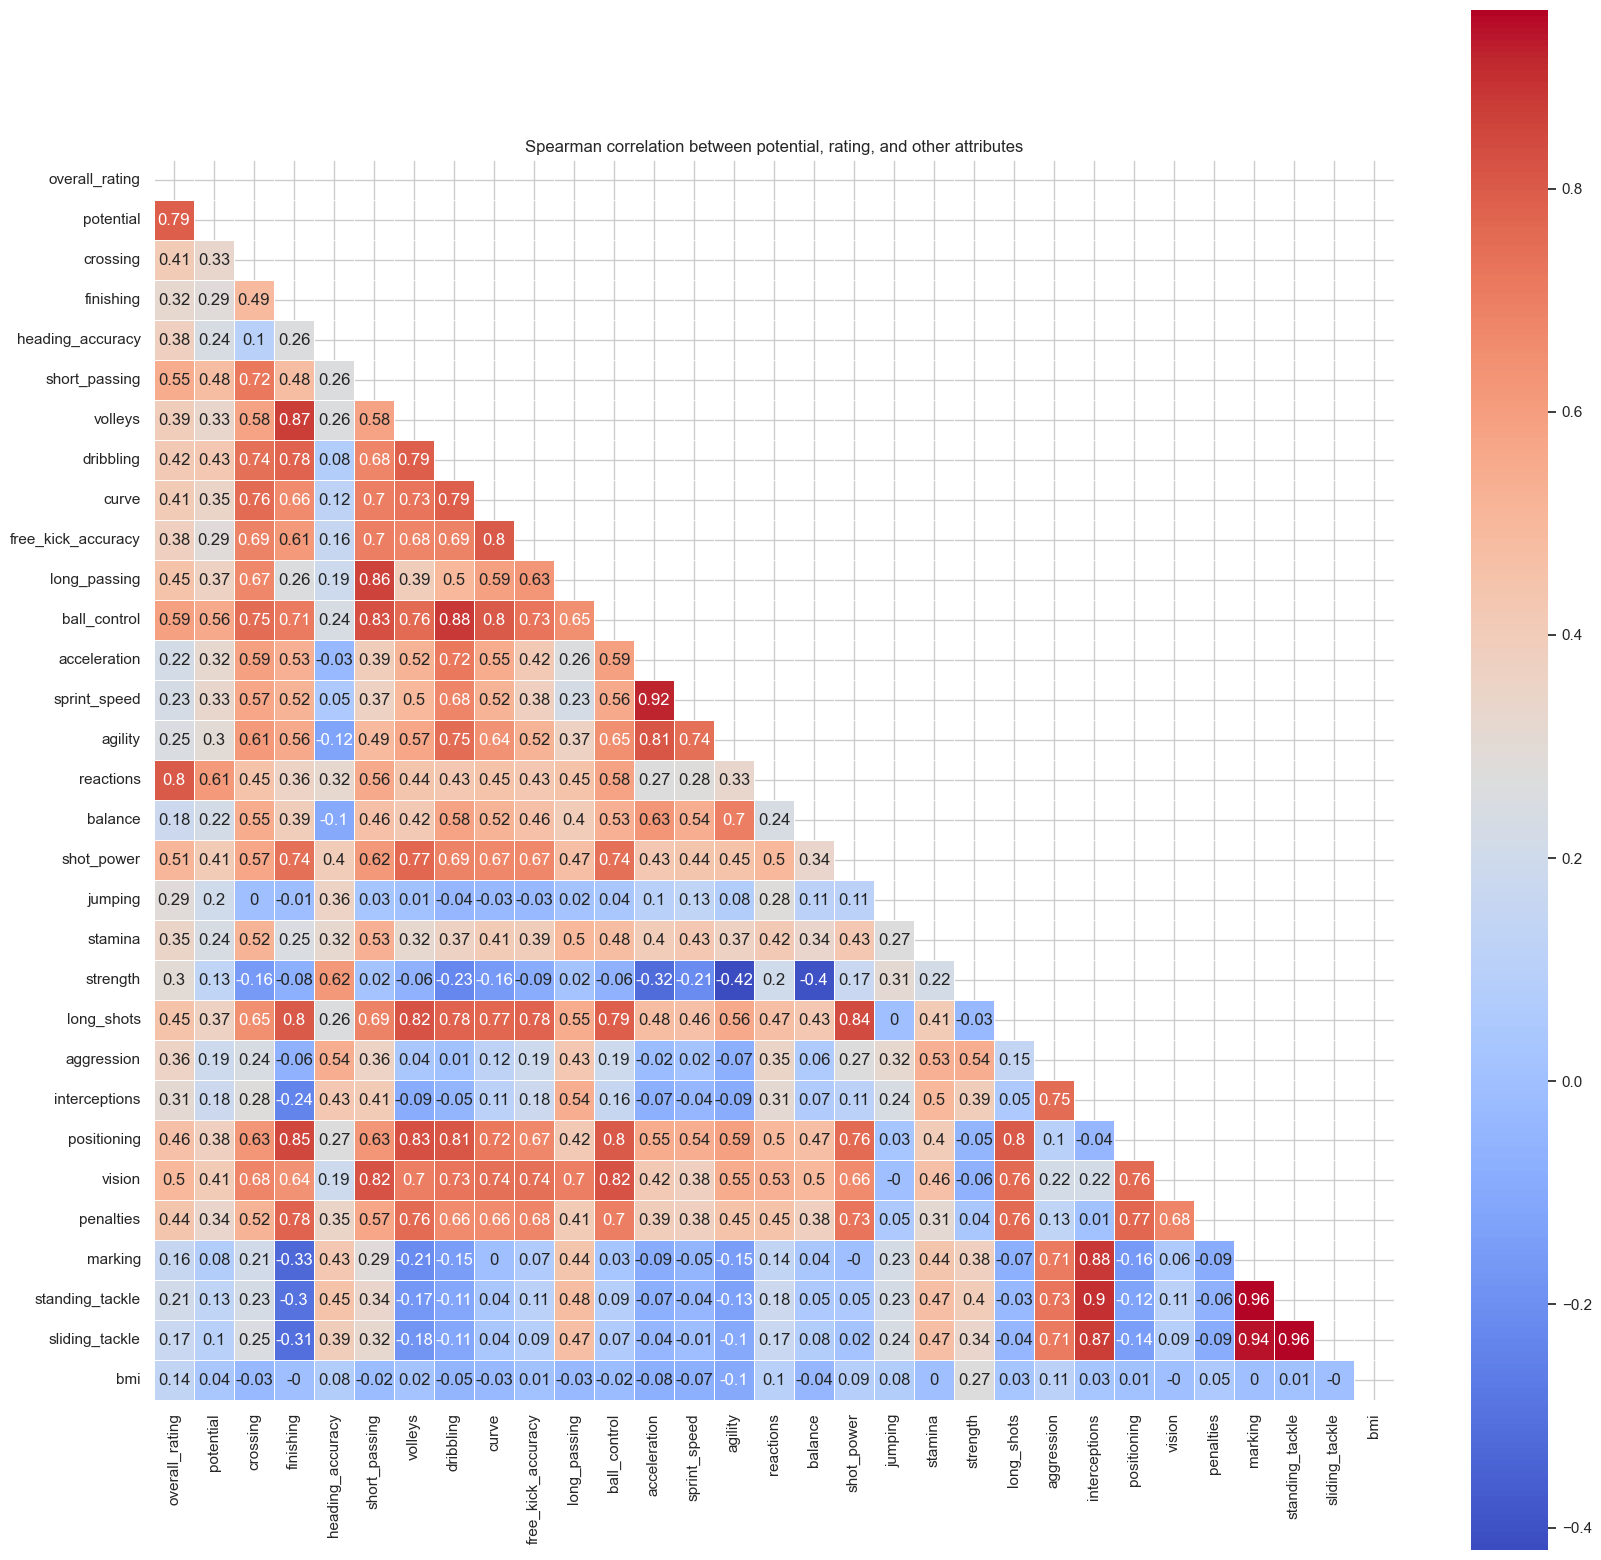

In [119]:
plt.figure(figsize=(20,20))
corr_matrix = player_attributes[pa_cols].select_dtypes(['number']).corr(method='spearman').round(decimals=2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
ax = sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', square=True, linewidths=0.5)
ax.set_title('Spearman correlation between potential, rating, and other attributes');

- Reactions, and ball controll seem to correlate strongest with rating.
- Seemingly, mental attributes correlate more strongly with potential and rating as opposed to purely physical ones.
- Other attributes have logical cross-correlations such as ball controll and dribbling, sprint speed and acceleration, marking and tackles etc.

# Positional

## Goalkeeper

There are about 1,5k rows for goalkeepers, a relatively small fraction.

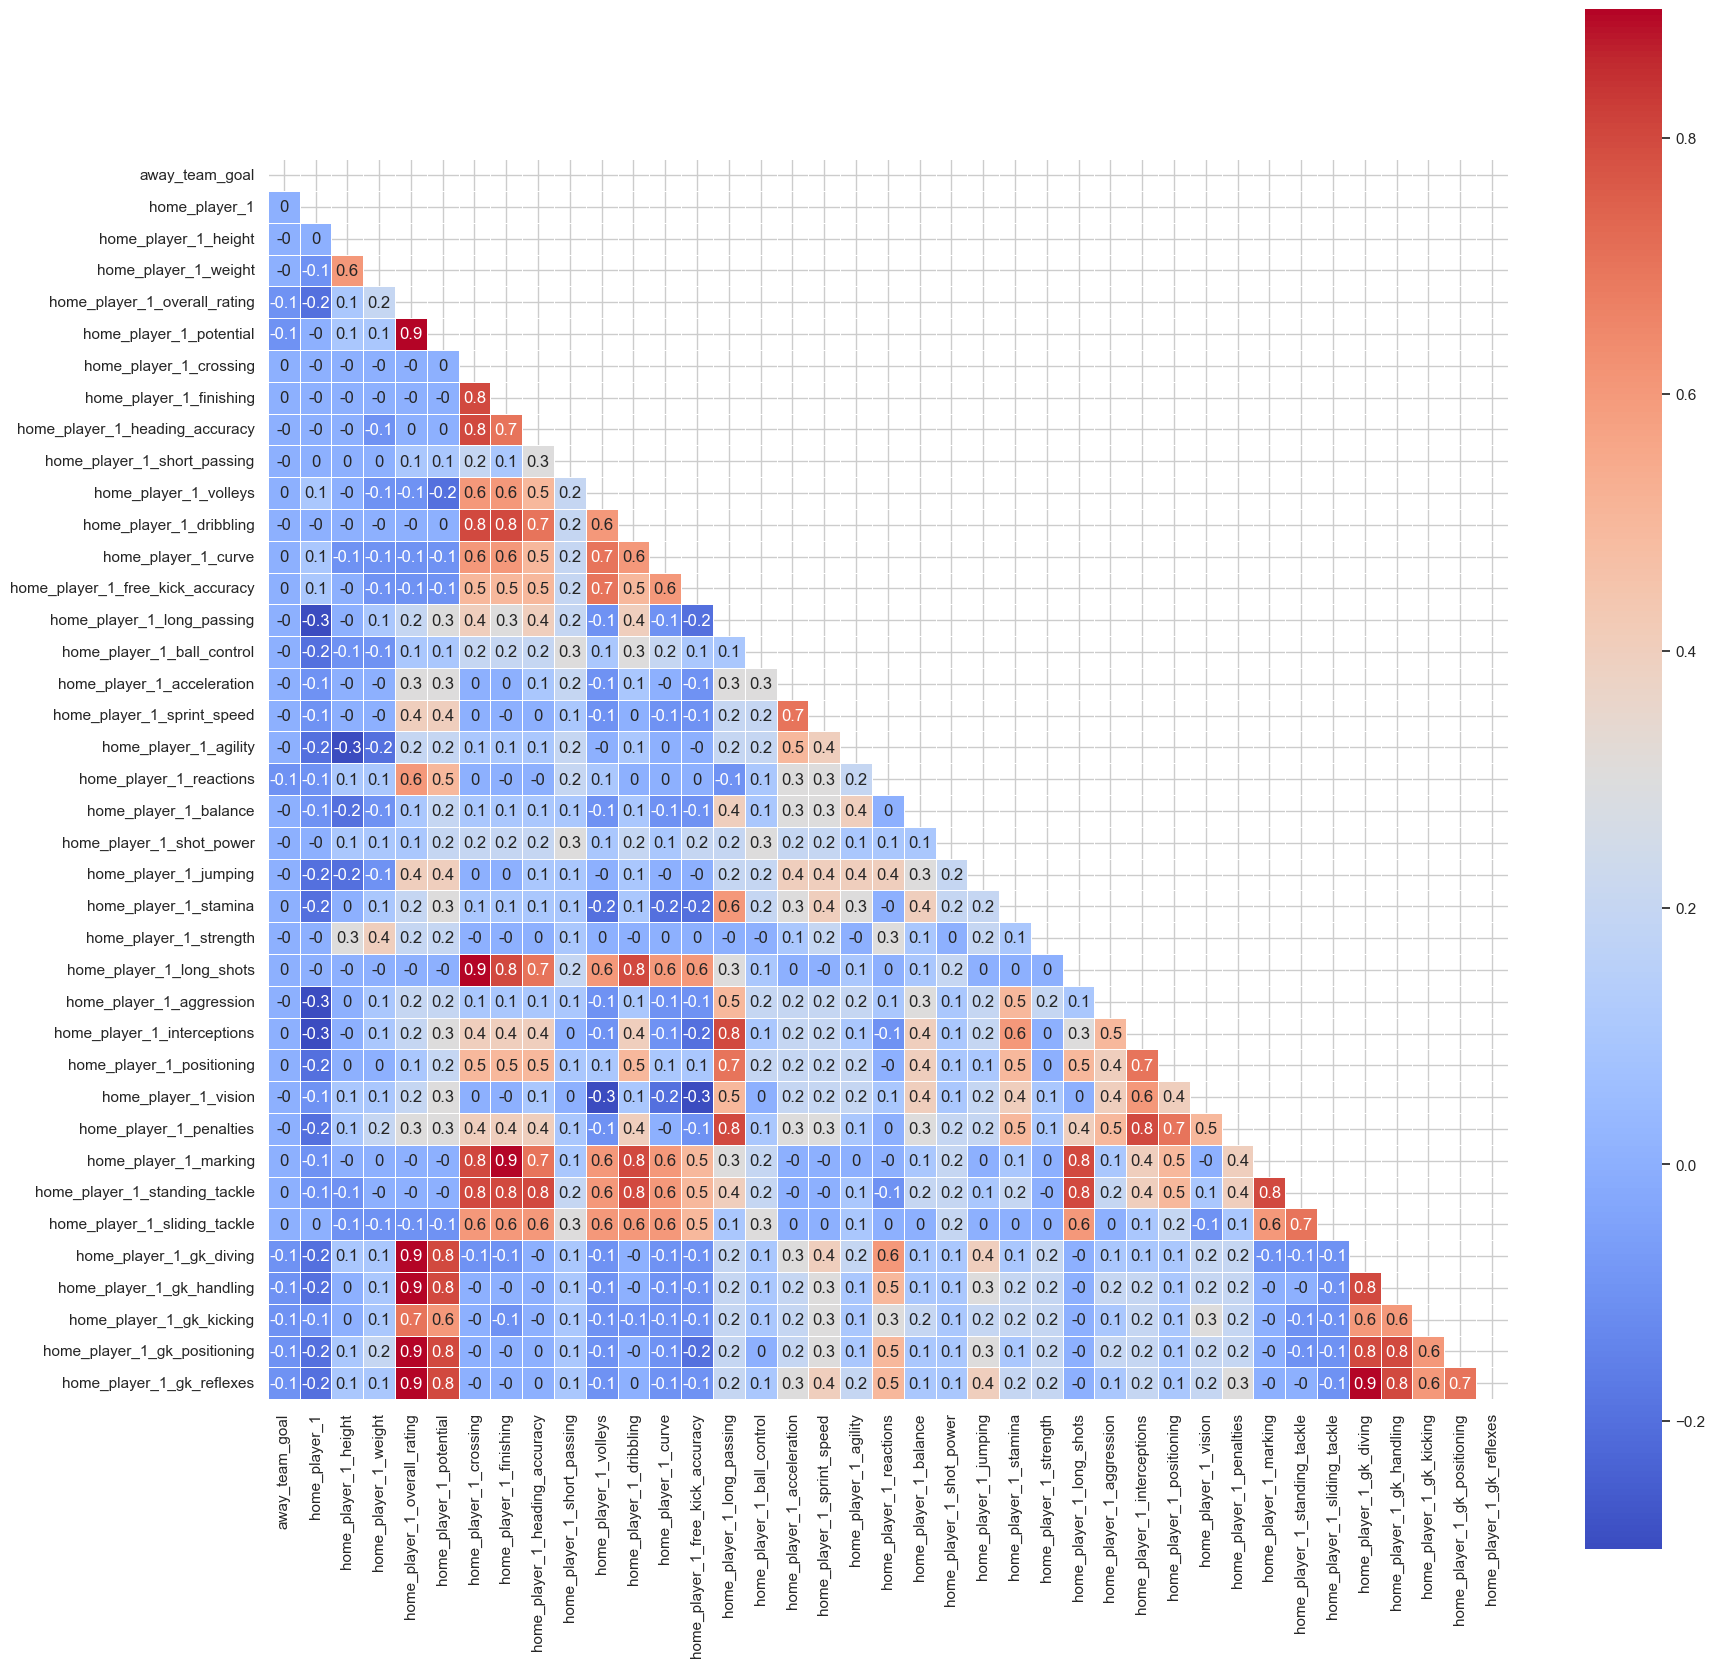

In [120]:
plt.figure(figsize=(20,20))
goal_keeper_cols = (np.r_[['away_team_goal'],
[i for i in df_wide.columns 
 if ('home_player_1' in i 
  and not 'home_player_11' in i 
  and not 'home_player_10' in i)]])

gk_corr_matrix = (df_wide[goal_keeper_cols]
                  .dropna()
                  .select_dtypes(['number'])
                  .corr()
                  .round(1))

gk_mask = np.triu(np.ones_like(gk_corr_matrix, dtype=bool))
sns.heatmap(gk_corr_matrix, annot=True, mask=gk_mask, cmap='coolwarm', square=True, linewidths=0.5);

- There is a slight negative association of goal keeper attributes and diving, handling, positioning and reflexes with the goals scored by the opposite team.
- The most important attributes for goalkeepers seem to be diving, handling, positioning and reflexes since they correlate very strongly with both the potential and overall rating.

# Team formations

In [121]:
home_df = df_wide[[i for i in df_wide.columns if (('X' in i or 'Y' in i) and 'home' in i)]]
away_df = df_wide[[i for i in df_wide.columns if (('X' in i or 'Y' in i) and 'away' in i)]]
home_df.columns = [i.replace('home_player_', '') for i in home_df.columns]
away_df.columns = [i.replace('away_player_', '') for i in away_df.columns]

In [122]:
home_away_df = pd.concat([home_df, away_df], ignore_index=False)

In [123]:
home_away_df.dropna(inplace=True)

In [124]:
form_count = (home_away_df
 .groupby(home_away_df.columns.tolist())
 .size()
 .reset_index(name='counts')
 .sort_values('counts', ascending=False)
)

We can now attempt to plot the most common formations to identify them.

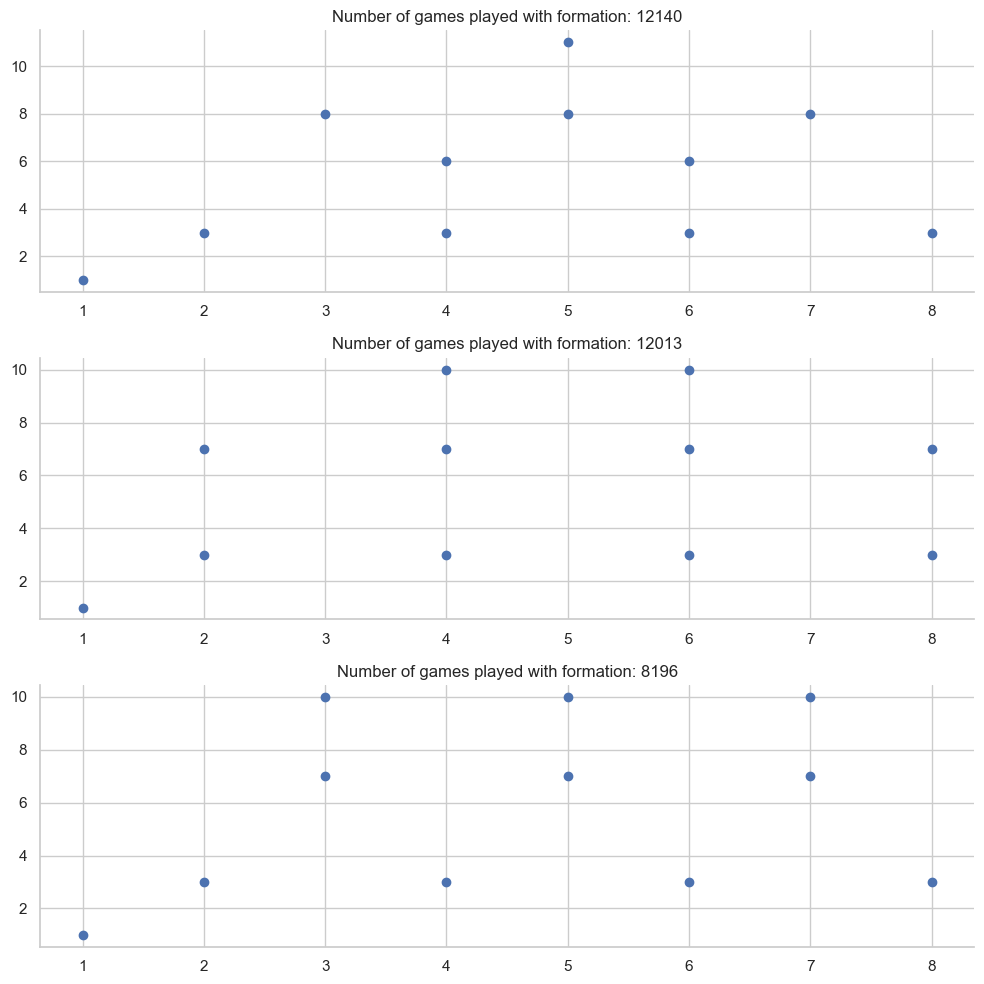

In [125]:
form_coords = form_count.drop('counts', axis=1).apply(lambda x: x.to_list(), axis=1).values
form_coords_3 = form_coords[:3]

fig, axs = plt.subplots(3, figsize=(10, 10))
for index, coords in enumerate(form_coords_3):
    axs[index].scatter(coords[:11], coords[11:])
    axs[index].set_title(
    f'Number of games played with formation: {form_count.reset_index()["counts"][index]}')
plt.tight_layout()

- The goalkeeper is placed somewhat arbitrarily.
- The most common formations are 4-2-3-1, 4-4-2 and 4-3-3.\
By counting how many distinct x coordinates we have for each y coordinate we can compute all of the formations computationally.

In [126]:
from itertools import groupby

def get_formation(row):
    return (''.join(
        [f'{row.count(i)}-' for i, _ in groupby(row)])
            .rstrip('-'))

In [127]:
home_away_df['formation'] = (home_away_df[[f'Y{i}' for i in range(2, 12)]]
                             .apply(lambda x: x.to_list(), axis=1)
                             .apply(get_formation)
                             )

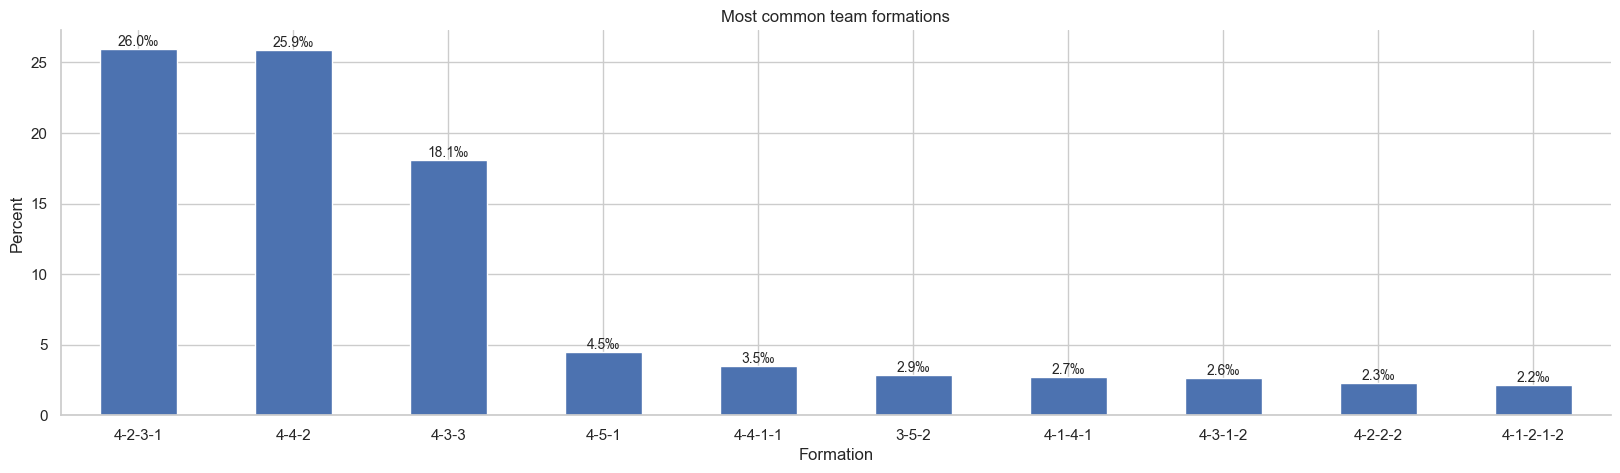

In [128]:
ax = (home_away_df['formation']
 .value_counts(normalize=True)
 .mul(100)
 .sort_values(ascending=False)
 .head(10)
 .plot(kind='bar', rot=0, figsize=(20,5), title='Most common team formations')
)
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:.1f}‰')
ax.set_ylabel('Percent')
ax.set_xlabel('Formation');

- General trend seems to be the preference for overall balanced formations.

## Formations for home vs. away

Do do teams prefer different formations when playing home vs away?

In [129]:
home_formation_cols = [f'home_player_Y{i}' for i in range(2, 12)]
away_formation_cols = [f'away_player_Y{i}' for i in range(2, 12)]

def process_formation(df, cols, column_name):
    df[column_name] = (
        df[cols]
        .apply(lambda x: x.to_list() if x.notna().any() else None, axis=1)
        .apply(lambda x: get_formation(x) if x else None))

process_formation(df_wide, home_formation_cols, 'home_formation')
process_formation(df_wide, away_formation_cols, 'away_formation')

In [130]:
home_form_df = pd.DataFrame({'formation': df_wide['home_formation']})
away_form_df = pd.DataFrame({'formation': df_wide['away_formation']})
home_form_df['home_away'] = 'home'
away_form_df['home_away'] = 'away'
home_away_form_df = pd.concat([home_form_df, away_form_df], ignore_index=True)
home_away_form_df.isna().sum()

formation    3653
home_away       0
dtype: int64

In [131]:
home_away_form_df.dropna(inplace=True)

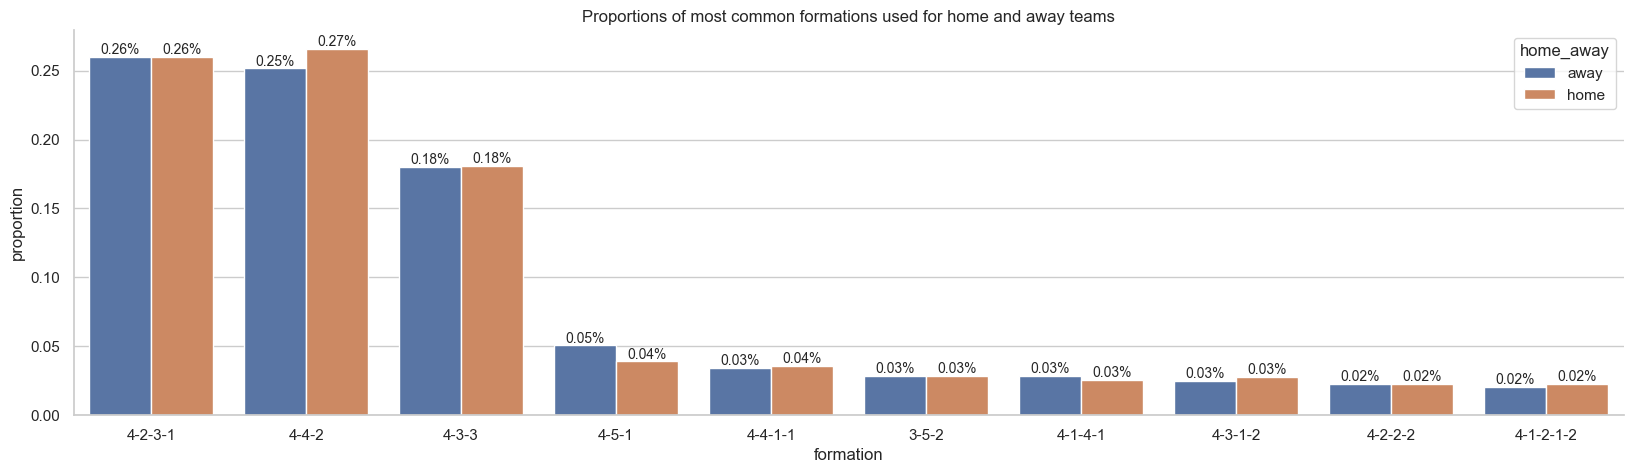

In [132]:
home_away_props = (
 home_away_form_df
 .groupby('home_away')
 .value_counts(normalize=True)
 .groupby('home_away')
 .nlargest(10)
 .droplevel(0)
 .reset_index()
)
plt.figure(figsize=(20,5))
ax = sns.barplot(home_away_props, x='formation', y='proportion', hue='home_away')
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:.2f}%')
ax.bar_label(ax.containers[1], fontsize=10, fmt='{:.2f}%')
ax.set_title('Proportions of most common formations used for home and away teams');

We see that home teams have a 2% higher preference on average for 4-4-2 formations as opposed to away teams.

## Association with winning/losing

We want to know if there is an association with winning or losing for certain formations.

In [133]:
top_formations_df = (df_wide[df_wide['home_formation']
                     .isin(home_away_props['formation'])]).copy()
top_formations_df.drop(top_formations_df[top_formations_df['home_formation'].isna()].index, axis='rows', inplace=True)
formation_outcomes = top_formations_df.groupby('home_formation')['match_result'].value_counts(normalize=True).mul(100).reset_index()

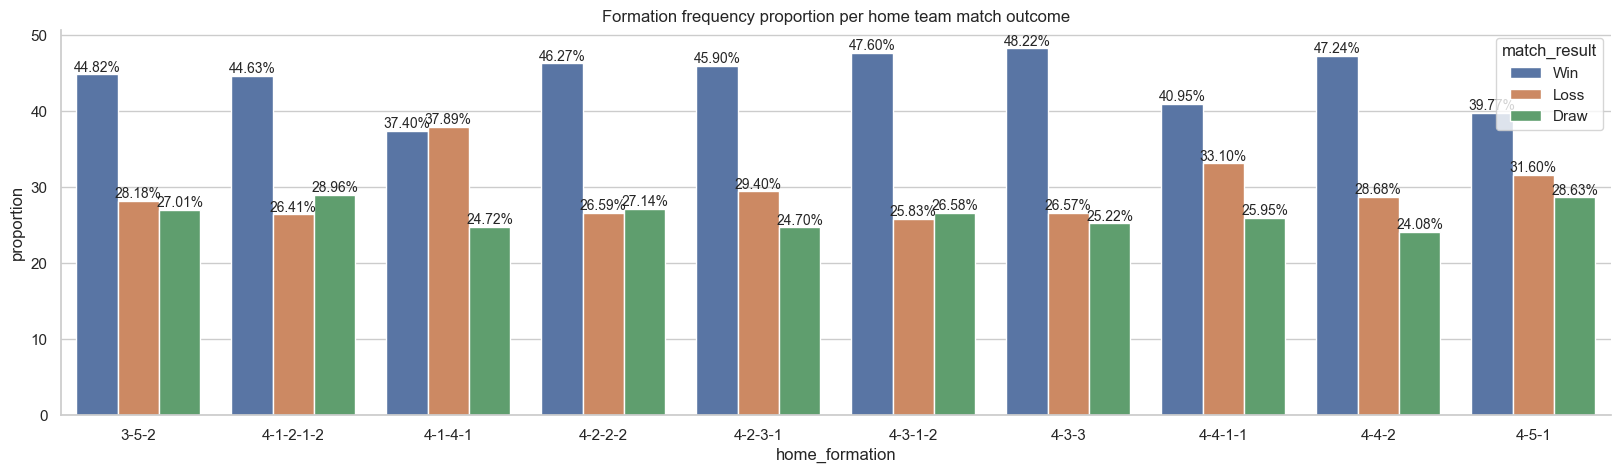

In [134]:
plt.figure(figsize=(20,5))
ax = sns.barplot(formation_outcomes, x='home_formation', y='proportion', hue='match_result')
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:.2f}%')
ax.bar_label(ax.containers[1], fontsize=10, fmt='{:.2f}%')
ax.bar_label(ax.containers[2], fontsize=10, fmt='{:.2f}%')
ax.set_title('Formation frequency proportion per home team match outcome');

- 4-3-3 formation seems to have the most association with home team wins while not having a high rate of losses. We saw earlier that only 18% of home games were played in this formation.
- The most common formations 4-4-2 and 4-2-3-1 both have higher associated loss rates than the less common 4-3-3.
- 4-1-4-1 seems to be the worst performing formation for home teams. However only 0.03% of home games were played in this formation. Therefore the validity of the association is unclear.

In [135]:
top_formations_df_away = (df_wide[df_wide['away_formation']
                     .isin(home_away_props['formation'])]).copy()
top_formations_df_away.drop(top_formations_df_away[top_formations_df_away['away_formation'].isna()].index, axis='rows', inplace=True)
formation_outcomes_away = top_formations_df_away.groupby('away_formation')['match_result'].value_counts(normalize=True).mul(100).reset_index()

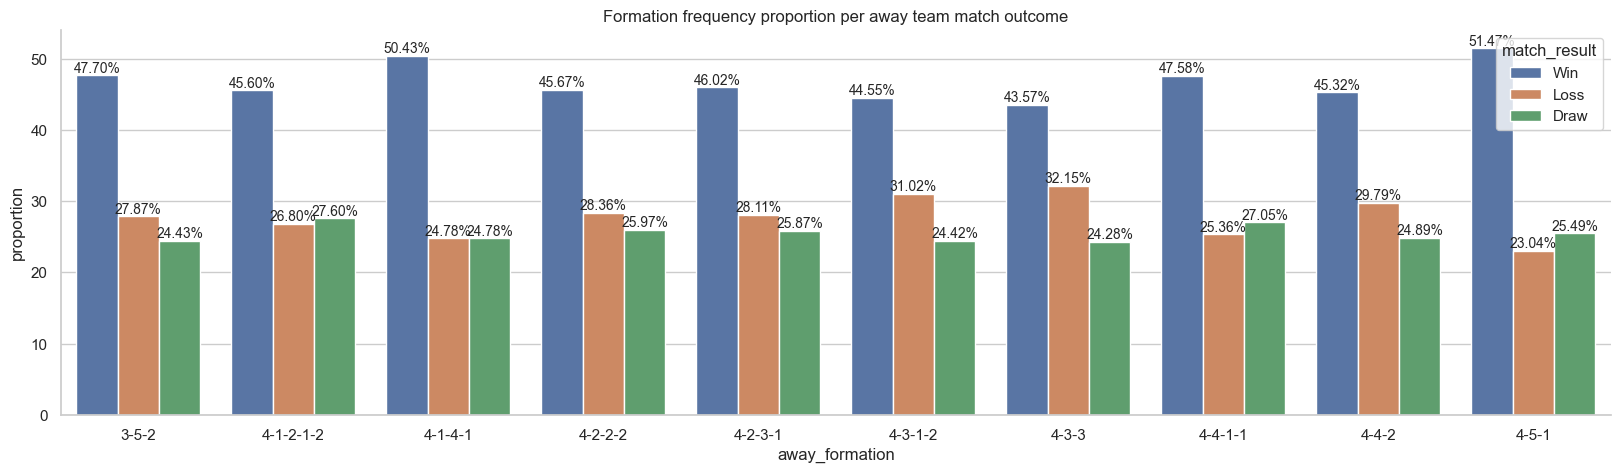

In [136]:
plt.figure(figsize=(20,5))
ax = sns.barplot(formation_outcomes_away, x='away_formation', y='proportion', hue='match_result')
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:.2f}%')
ax.bar_label(ax.containers[1], fontsize=10, fmt='{:.2f}%')
ax.bar_label(ax.containers[2], fontsize=10, fmt='{:.2f}%')
ax.set_title('Formation frequency proportion per away team match outcome');

- 4-5-1 formation seems to be the most optimal one for away teams, though, only 0.05% of away games were played so.
- 4-3-3 formation is associated with worse results for away teams.

## Pair-wise formations

The idea is to find out how the formations interract with each other. We will focus on common formations, bunching the less commonly used into a single category called 'Other'.

In [137]:
common_forms = ['4-2-3-1', '4-4-2', '4-3-3']

In [138]:
def bunch_formations(val):
    if val:
        if val in common_forms:
            return val
        return 'Other'
    return None

In [139]:
df_wide['home_formation_b'] = df_wide['home_formation'].apply(bunch_formations)
df_wide['away_formation_b'] = df_wide['away_formation'].apply(bunch_formations)

In [140]:
pw_forms = (df_wide
            .groupby(['home_formation_b', 'away_formation_b'])
            ['match_result']
            .value_counts(normalize=True)
            .mul(100)
            .reset_index()
           )

In [141]:
pw_wins = pw_forms[pw_forms['match_result'] == 'Win']

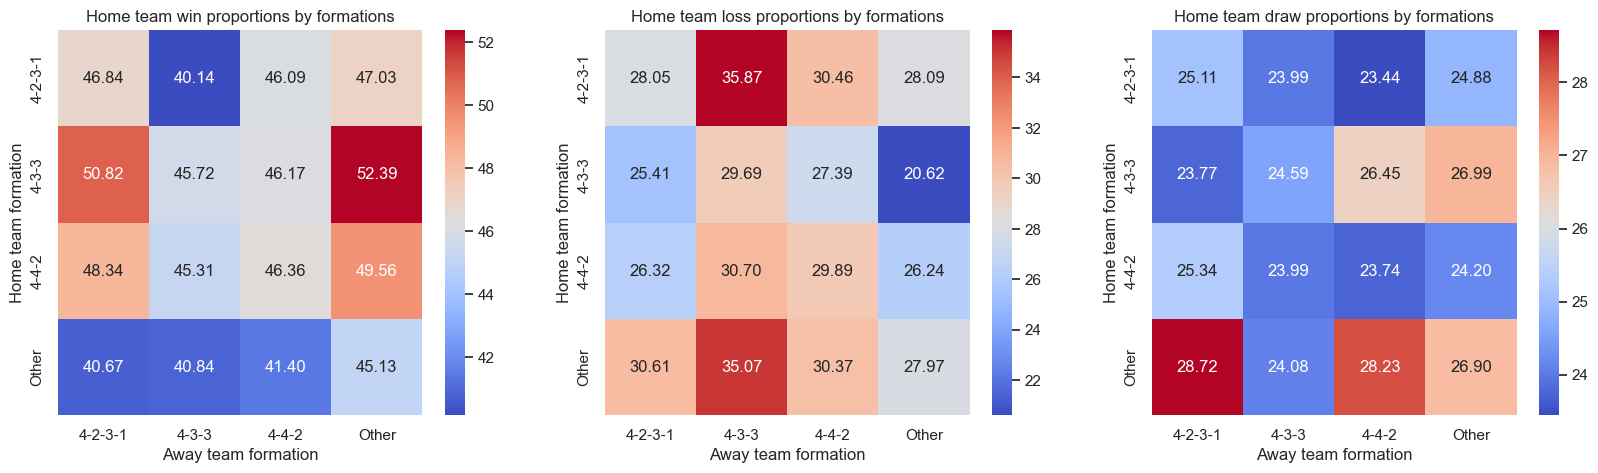

In [142]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
results = pw_forms['match_result'].unique()
for i in range(3):
    pw_result = pw_forms[pw_forms['match_result'] == results[i]]
    heatmap_data = pw_result.pivot(index="home_formation_b", columns="away_formation_b", values="proportion")
    sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar=True, ax=axs[i], fmt=".2f")
    axs[i].set_title(f'Home team {results[i].lower()} proportions by formations')
    axs[i].set_xlabel('Away team formation')
    axs[i].set_ylabel('Home team formation')

- 4-4-3 against 4-2-3-1 and other less common formations is associated with the largest proportion of won games for the home team.
- 4-2-3-1 and other less common formations are most associated with away team wins/home team losses.

# Inference

We saw that the aggregated odd errors pretty much don't differ among bookies. We want to conduct a statistical test to see if the distributions differ significantly while having some confidence in our procedure.

In [143]:
home_odds = df_wide[['B365H', 'BWH', 'IWH','LBH','WHH', 'SJH', 'VCH']]
home_odds.name = 'Home win odds'
draw_odds = df_wide[['B365D','BWD', 'IWD', 'LBD', 'WHD', 'SJD', 'VCD']]
draw_odds.name = 'Draw odds'
away_odds = df_wide[['B365A','BWA', 'IWA', 'LBA', 'WHA', 'SJA', 'VCA']]
away_odds.name = 'Away odds'

Exploring the distribution:

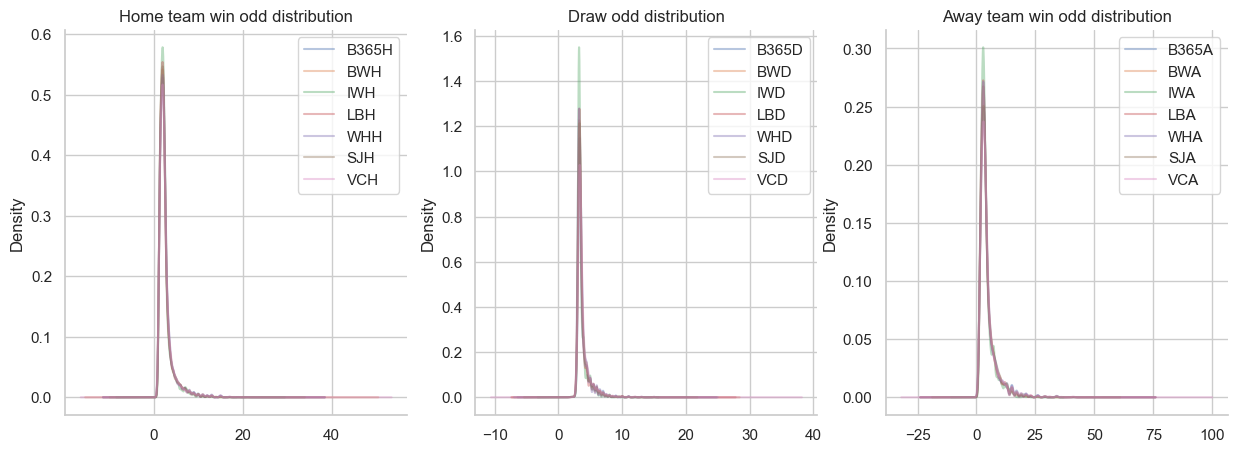

In [144]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
home_odds.plot(kind='kde', ax=ax1, alpha=0.4, title='Home team win odd distribution')
draw_odds.plot(kind='kde', ax=ax2, alpha=0.4, title='Draw odd distribution')
away_odds.plot(kind='kde', ax=ax3, alpha=0.4, title='Away team win odd distribution');

We have a right skewed distribution, therefore, we will need to employ a non parametric test.

**Populations**: Betting odds for home win, draw, and away win outcomes from european football games across Belgium's, England's, France's, Germany's, Italy's, Netherlands', Poland's, Portugal's, Scottland's, Spain's and Switzerland's leagues, seasons 2008/2009 to 2015/2016.\
**Home win, draw and away win outcomes will have separate tests**

We will test for the null hypothesis the data comes from the same distribution:
$$
H_0: F_1(x) = F_2(x) = \dots = F_k(x) \quad \text{at} \quad \alpha = 0.05
$$

Assumption checklist:

- Simple random sample ❌\
The selection of subjects was not random but influenced by the way data was scraped.
- Independence of Observations ❓\
It is not clear how much influence bookies have for each other when setting the odds.
- Scale of Measurement ✅\
The data is continuous.
- Identical Shape and Scale of Distribution ✅\
Distributions have similar shape.
-  Group Sizes ✅\
The differences of group sizes are not extreme. KW is relatively robust to differences in sample size.

In [145]:
from scipy.stats import kruskal

In [146]:
kruskal(*[home_odds[i] for i in home_odds.columns], nan_policy='omit')

KruskalResult(statistic=95.13971914701338, pvalue=2.5855934681318502e-18)

In [147]:
kruskal(*[draw_odds[i] for i in draw_odds.columns],  nan_policy='omit')

KruskalResult(statistic=2923.8344016543815, pvalue=0.0)

In [148]:
kruskal(*[away_odds[i] for i in away_odds.columns], nan_policy='omit')

KruskalResult(statistic=312.22121174775106, pvalue=1.9652776155042465e-64)

Based on our samples and our p-values, we reject the null hypothesis for all three tests. In this case, we conclude that there is a significant difference between the population betting odd distributions for at least two bookkeepers.

## Post-hoc test

Now we will perform Dunn's test to find individual pairs that fail to reject the null hypothesis.\
Some considerations:
- The assumptions are the same as for Kruskal - Wallis test.
- The output p-value will be adjusted with relatively conservative Bonferroni correction method.

In [149]:
import scikit_posthocs as sp

In [150]:
print('Is p < 0.05?')
print('\n')

for dataframe in [home_odds, draw_odds, away_odds]:
    
     stacked_data = dataframe.stack().reset_index()
     stacked_data.columns = ['Index', 'Group', 'Value']
     result = sp.posthoc_dunn(stacked_data, val_col='Value', group_col='Group', p_adjust='bonferroni')
    
     print(f'{dataframe.name}:\n')
     print(result < 0.05)
     print('_________________________________________________________')
     print('\n')

Is p < 0.05?


Home win odds:

       B365H    BWH    IWH    LBH    SJH    VCH    WHH
B365H  False  False   True   True  False  False  False
BWH    False  False   True  False  False   True  False
IWH     True   True  False  False  False   True   True
LBH     True  False  False  False  False   True   True
SJH    False  False  False  False  False   True  False
VCH    False   True   True   True   True  False  False
WHH    False  False   True   True  False  False  False
_________________________________________________________


Draw odds:

       B365D    BWD    IWD    LBD    SJD    VCD    WHD
B365D  False   True   True   True   True   True   True
BWD     True  False   True  False   True   True   True
IWD     True   True  False   True   True   True  False
LBD     True  False   True  False   True   True   True
SJD     True   True   True   True  False   True   True
VCD     True   True   True   True   True  False   True
WHD     True   True  False   True   True   True  False
_________________

- **Home Win Odds**: The matrix suggests that the odds offered by different bookmakers often do not significantly differ, with most entries being "False." However, there are notable exceptions where certain bookmakers do significantly differ, notably between IWH with several others, and between LBH with VCH and WHH, indicating significant variation in their offered odds for home wins.

- **Draw Odds**: The results show a higher degree of significant differences compared to home win odds. Most pairs of bookmakers exhibit statistically significant differences in the draw odds they offer. This implies a broader variation in how bookmakers are assessing the likelihood of a draw outcome compared to home wins.

- **Away Win Odds**: Similar to the draw odds, there are numerous significant differences across the bookmakers for away win odds. This indicates variance in the bookmakers' evaluations of the likelihood of away wins, which could be due to differing assessments of team performance or risk factors when teams play away from home.

Overall, the analysis indicates that while there are some consistencies in the odds offered by different bookmakers, significant variations do exist, particularly for draw and away win odds. This suggests that each bookmaker's odds calculation models may consider different factors or weigh common factors differently, leading to variations in their odds.

# Modeling

## Goal prediction

### Constructing a dataframe for modeling

In [151]:
home_win_odds = [i for i in df_wide.columns if i.endswith('H')]
draw_odds = [i for i in df_wide.columns if i.endswith('D')]
away_win_odds = [i for i in df_wide.columns if i.endswith('A')]

Since the betting odds dont differ greatly between bookmakers and there are a big chunk of odds missing, we chose to average the odds.

In [152]:
df_wide['agg_home_odds'] = df_wide[home_win_odds].mean(axis=1)
df_wide['agg_away_odds'] = df_wide[away_win_odds].mean(axis=1)
df_wide['agg_draw_odds'] = df_wide[draw_odds].mean(axis=1)

We saw before that buildup play passing defence aggresion were the variables that best helped explain home team scoring, through it was somewhat questionable wether it was these variables or a confounding variable.

In [153]:
team_attributes = ['home_buildUpPlayPassing',
                        'home_defencePressure',
                  'away_buildUpPlayPassing', 
                  'away_defencePressure']

In [154]:
attr_list = ['overall_rating',
 'potential', 'crossing',
 'finishing', 'heading_accuracy',
 'short_passing', 'volleys',
 'dribbling', 'curve',
 'free_kick_accuracy', 'long_passing',
 'ball_control', 'acceleration',
 'sprint_speed', 'agility',
 'reactions', 'balance',
 'shot_power', 'jumping',
 'stamina', 'strength',
 'long_shots', 'aggression',
 'interceptions', 'positioning',
 'vision', 'penalties',
 'marking', 'standing_tackle',
 'sliding_tackle', 'gk_diving',
 'gk_handling', 'gk_kicking',
 'gk_positioning', 'gk_reflexes']

In [155]:
player_attributes = [f'{k}_player_{j}_{i}' for k in ['home', 'away'] for j  in range(1, 11) for i in attr_list]

We will remove away odds as it will only introduce multicollinearity and redundant information into the model:

In [156]:
data_cols = np.r_[team_attributes,
['match_result'], player_attributes]

In [157]:
data = df_wide[data_cols].dropna()

### Processing the data

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor

Encoding the class labels:

In [159]:
le = LabelEncoder()
le.fit(data['match_result'])
data['match_result_encoded'] = le.transform(data['match_result'])
data.drop('match_result', inplace=True, axis=1)

Splitting into train and test:

In [160]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('match_result_encoded', axis=1), data['match_result_encoded'], test_size=0.2)

### Decomposing player attributes

Having all of the player attributes would result in over 700 features. We will try to use PCA to cast these features for each player position to 2 dimensions.

In [161]:
player_attribute_components_train = pd.DataFrame()
player_attribute_components_test = pd.DataFrame()
pca_list = list()

for k in ['home', 'away']:
    for j in range(1, 11):
        _pca = PCA(n_components=6)
        _std_scaler = StandardScaler()
        
        _data_train = X_train[[f'{k}_player_{j}_{i}' for i in attr_list]]
        _data_test = X_test[[f'{k}_player_{j}_{i}' for i in attr_list]]
        
        _std_scaler_fit = _std_scaler.fit(_data_train)
        _data_train_scaled = _std_scaler_fit.transform(_data_train)
        _data_test_scaled = _std_scaler_fit.transform(_data_test)

        
        _pca_fit = _pca.fit(_data_train_scaled)
        
        player_attribute_components_train[f'{k}_player_{j}_comp1'] = _pca_fit.transform(_data_train)[:, 0]

        player_attribute_components_test[f'{k}_player_{j}_comp1'] = _pca_fit.transform(_data_test)[:, 0]

Joining in the components and dropping player attributes:

In [162]:
X_train = X_train.reset_index(drop=True)
for col in player_attribute_components_train.columns:
    X_train[col] = player_attribute_components_train[col]

X_test = X_test.reset_index(drop=True)
for col in player_attribute_components_test.columns:
    X_test[col] = player_attribute_components_test[col]

filter_cols = [i for i in X_train.columns 
               if not (('home_player' in i or 'away_player' in i) 
                       and 'comp' not in i)]

X_train = X_train[filter_cols].copy()
X_test = X_test[filter_cols].copy()

Visualizing the distributions:

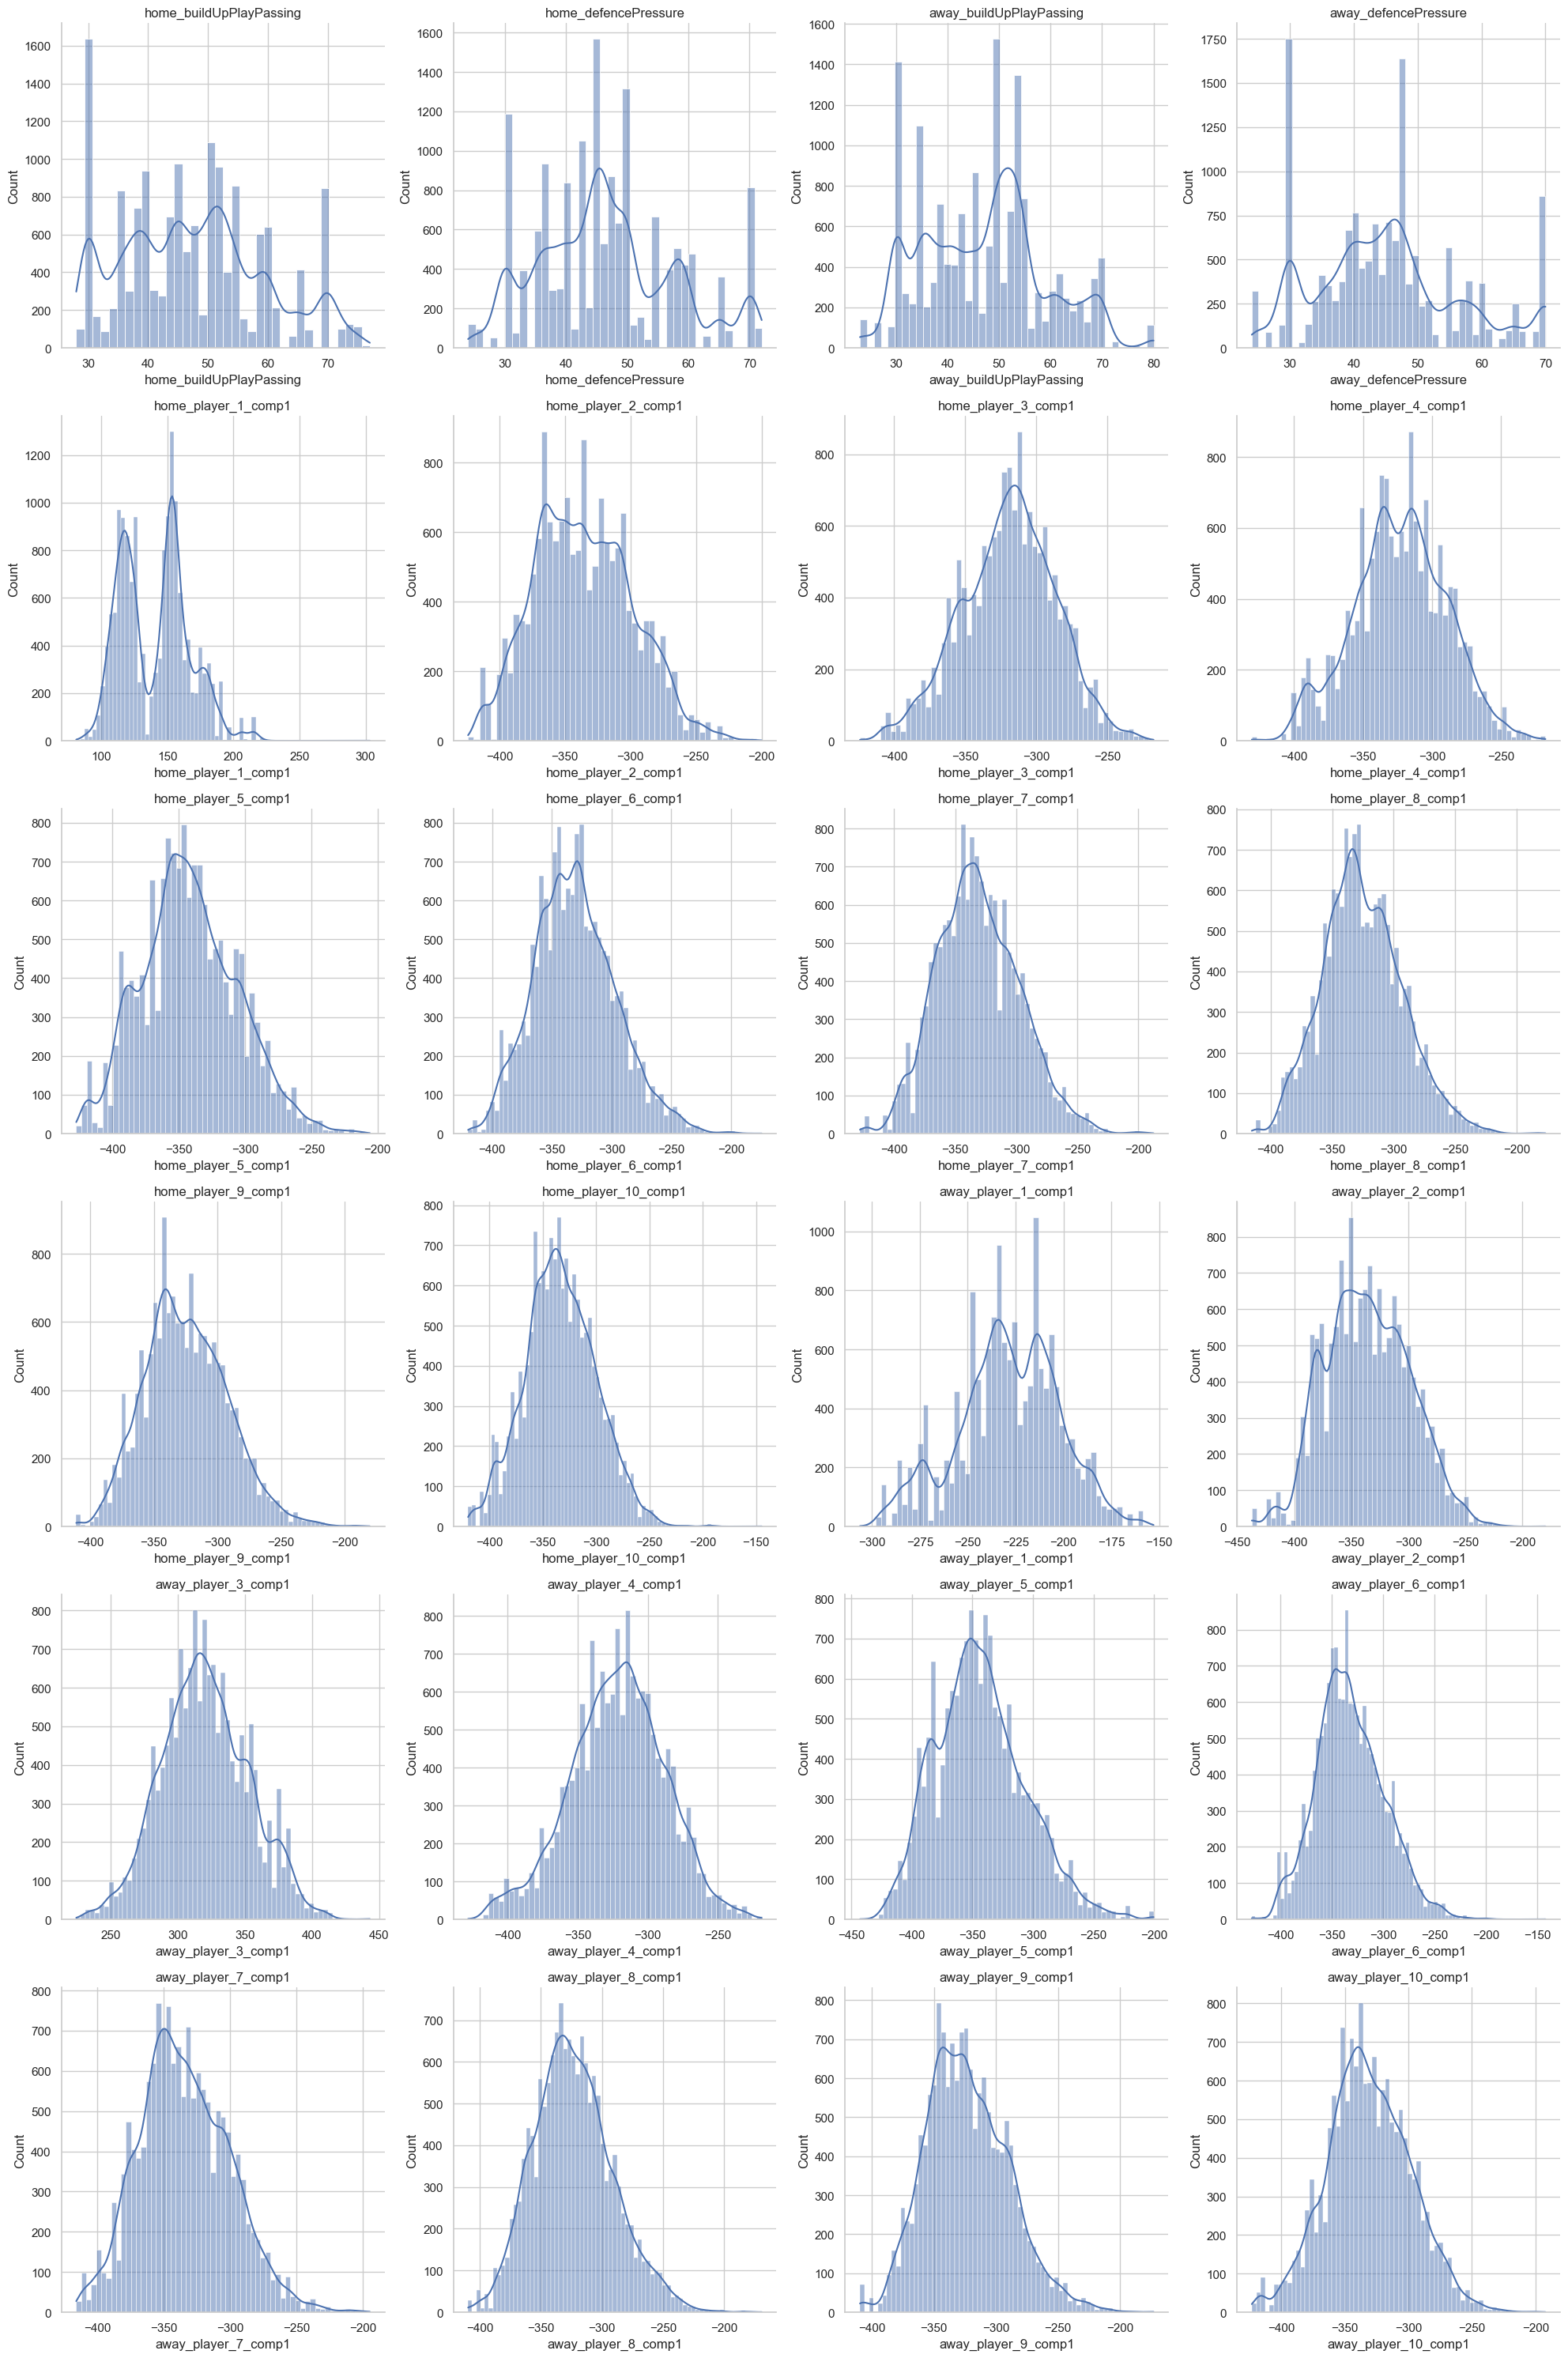

In [163]:
features = X_train.columns
num_features = len(features)

num_cols = 4
num_rows = (num_features + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(X_train[feature], kde=True, ax=axes[i])
    axes[i].set_title(feature)

for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.show()

- Messy distributions for team attributes.
- Bimodal distribution for the goalkeeper component 1.

Checking for outliers:

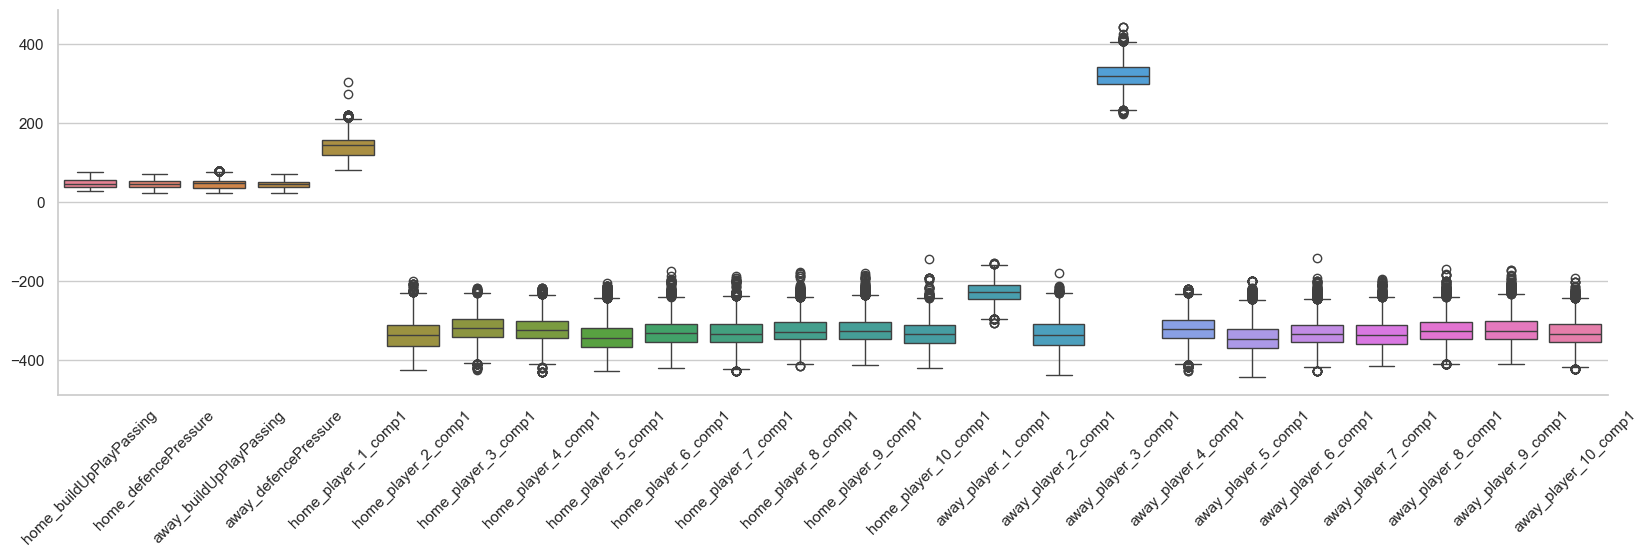

In [164]:
plt.figure(figsize=(20,5))
ax = sns.boxplot(X_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Given that the logistic regression model is sensitive to outliers, which can skew the decision boundary, we will remove these outliers to avoid undue influence on the model's fit.

In [165]:
find_outliers(X_train)

home_buildUpPlayPassing  home_defencePressure  away_buildUpPlayPassing  \
0                        41.0                  42.0                     65.0   
8198                     38.0                  59.0                     66.0   
14                       60.0                  40.0                     46.0   
8208                     37.0                  37.0                     35.0   
29                       50.0                  30.0                     38.0   
...                       ...                   ...                      ...   
8168                     36.0                  50.0                     50.0   
8169                     60.0                  40.0                     70.0   
8172                     51.0                  38.0                     26.0   
8178                     30.0                  70.0                     40.0   
8186                     55.0                  38.0                     70.0   

      away_defencePressure  home_player_1_comp1  home_player_2_comp1  \
0                     65.0               145.99              -366.57   
8198                  29.0               115.19              -310.12   
14                    47.0               111.64              -301.77   
8208                  50.0               152.17              -300.88   
29                    39.0               159.82              -310.24   
...                    ...                  ...                  ...   
8168                  30.0                95.06              -288.41   
8169                  50.0               106.97              -298.97   
8172                  51.0               183.20              -326.27   
8178                  30.0               116.67              -413.79   
8186                  60.0               125.28              -283.21   

      home_player_3_comp1  home_player_4_comp1  home_player_5_comp1  \
0                 -349.87              -337.86              -395.43   
8198              -319.06              -264.81              -230.38   
14                -291.85              -310.57              -304.97   
8208              -283.82              -304.65              -370.30   
29                -306.14              -290.69              -329.73   
...                   ...                  ...                  ...   
8168              -297.06              -292.81              -361.19   
8169              -285.04              -319.46              -343.20   
8172              -295.62              -348.50              -385.74   
8178              -409.03              -393.86              -354.03   
8186              -292.04              -267.93              -213.16   

      home_player_6_comp1  ...  away_player_1_comp1  away_player_2_comp1  \
0                 -373.83  ...              -234.63              -367.54   
8198              -310.60  ...              -213.79              -313.80   
14                -272.44  ...              -189.22              -270.47   
8208              -337.26  ...              -206.91              -364.89   
29                -323.52  ...              -214.91              -270.50   
...                   ...  ...                  ...                  ...   
8168              -294.21  ...              -174.43              -344.18   
8169              -297.07  ...              -221.19              -296.98   
8172              -317.75  ...              -267.17              -381.30   
8178              -393.40  ...              -244.74              -382.59   
8186              -304.35  ...              -236.51              -316.52   

      away_player_3_comp1  away_player_4_comp1  away_player_5_comp1  \
0                  285.51              -312.85              -311.28   
8198               296.97              -249.38              -304.06   
14                 271.88              -256.93              -222.11   
8208               373.85              -413.07              -393.68   
29                 295.13              -367.51             

Getting the goals prepared too:

In [166]:
y_train_ind = y_train.index

In [167]:
home_team_goals_test = df_wide.iloc[y_test.index]['home_team_goal']
home_team_goals_train = df_wide.iloc[y_train_ind]['home_team_goal']

In [169]:
outlier_ind = find_outliers(X_train).index

In [170]:
home_team_goals_train = home_team_goals_train.reset_index(drop=True)
home_team_goals_train.drop(outlier_ind, inplace=True)

In [171]:
y_train = y_train.reset_index(drop=True)

In [172]:
y_train.drop(outlier_ind, inplace=True)
X_train.drop(outlier_ind, inplace=True)

### Scaling and asessing numerical issues

Scaling the features:

In [173]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Calculating variance inflation factor to check for multicollinearity. The threshold will be VIF > 5:

In [174]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [175]:
X_train_scaled_indexed = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
vif1 = calc_vif(X_train_scaled_indexed)
vif1[vif1['VIF'] > 5]

Empty DataFrame
Columns: [variable, VIF]
Index: []

No apparent numerical issues.

### Fitting the model

- We will use the one versus all approach for applying Logistic regression to a multiclass problem
- As we saw from before, the classes are not balanced therefore we will apply the classweight parameter.

Fitting the OVR logistic regression model:

In [176]:
model = LogisticRegression(multi_class='ovr', class_weight='balanced', max_iter=10000)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

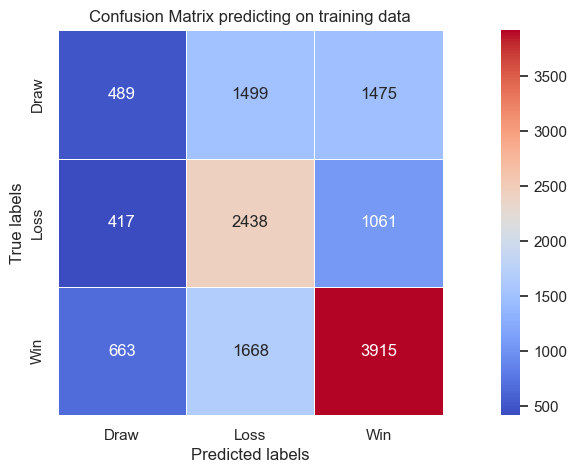

In [177]:
y_pred_fake = model.predict(X_train_scaled)
cm = confusion_matrix(y_train, y_pred_fake)

plt.figure(figsize=(15, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm', square=True,
            linewidths=0.5, xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix predicting on training data');

In [178]:
print('\n')

accuracy = accuracy_score(y_train, y_pred_fake)

print("Accuracy: {:.2f}%".format(accuracy * 100))

print('\n')

report = classification_report(y_train, y_pred_fake,
        target_names=le.classes_, zero_division=0)
print(report)



Accuracy: 50.22%


              precision    recall  f1-score   support

        Draw       0.31      0.14      0.19      3463
        Loss       0.43      0.62      0.51      3916
         Win       0.61      0.63      0.62      6246

    accuracy                           0.50     13625
   macro avg       0.45      0.46      0.44     13625
weighted avg       0.48      0.50      0.48     13625



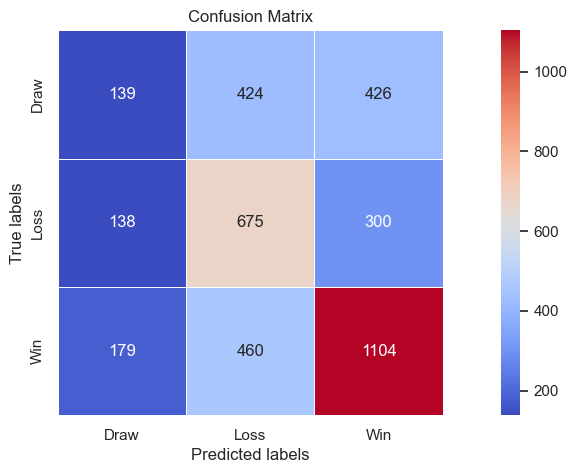

In [179]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm', square=True,
            linewidths=0.5, xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix');

In [180]:
print('\n')

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))

print('\n')

report = classification_report(y_test, y_pred,
        target_names=le.classes_, zero_division=0)
print(report)



Accuracy: 49.88%


              precision    recall  f1-score   support

        Draw       0.30      0.14      0.19       989
        Loss       0.43      0.61      0.51      1113
         Win       0.60      0.63      0.62      1743

    accuracy                           0.50      3845
   macro avg       0.45      0.46      0.44      3845
weighted avg       0.48      0.50      0.48      3845



- Around 50% accuracy (random guessing benchmark is 33.3%)
- Precision for winning predictions is around 60%
- Precision for identifying drawn games is very poor.
- We see nearly identical performance when predicting both the training set and the test set, which indicates that there is no overfitting.\
However, that also means that a large amount of variance is not explained by the model.

### Diagnostics

#### ROC, AUC

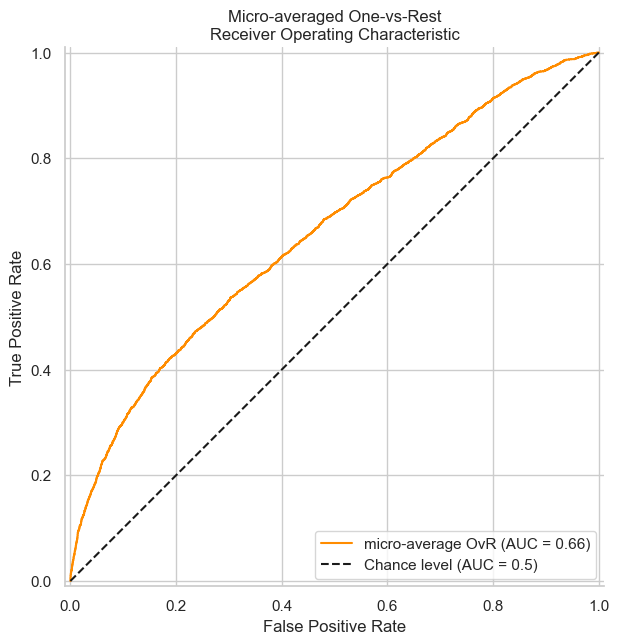

In [181]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(7,7))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_score = model.predict_proba(X_test_scaled)

display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

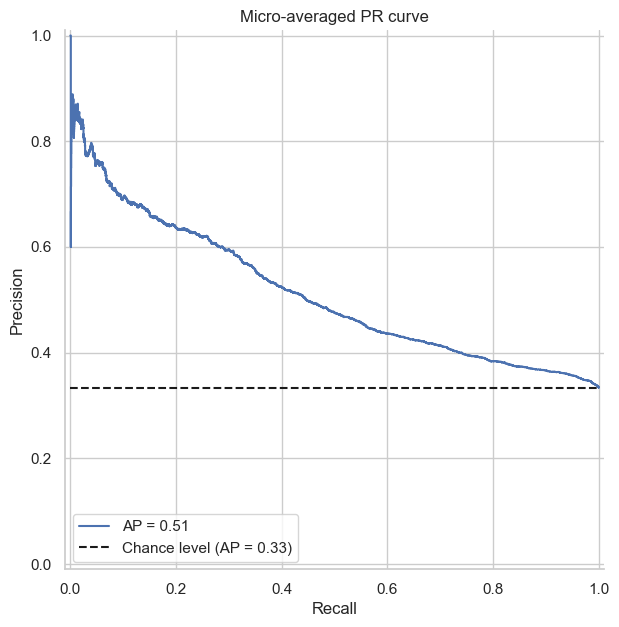

In [182]:
y_score = model.decision_function(X_test_scaled)

from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

precision = dict()
recall = dict()
average_precision = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_onehot_test[:, i], y_score[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_onehot_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_onehot_test, y_score, average="micro")

from collections import Counter

fig, ax = plt.subplots(figsize=(7,7))
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
    prevalence_pos_label=Counter(y_onehot_test.ravel())[1] / y_onehot_test.size
)
display.plot(plot_chance_level=True, ax=ax)
_ = display.ax_.set_title("Micro-averaged PR curve")

- Micro-averaged ROC AUC around 0.66 indicates relatively poor overall performance.

### Trying another approach

In [183]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_grid = RandomForestClassifier(class_weight='balanced')
gr_space = {
    'max_depth': [None, 5, 10],
    'n_estimators': [100, 200, 300],
    'max_features': [3, 4, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(rf_grid, gr_space, cv=3, scoring='accuracy', verbose=0)
model_grid = grid.fit(X_train_scaled, y_train)

In [184]:
model_grid.best_params_

{'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 1,
 'n_estimators': 300}

In [185]:
rf = RandomForestClassifier(class_weight='balanced', max_features=3, min_samples_leaf=1, n_estimators=300, max_depth=None)
rf.fit(X_train_scaled, y_train);

In [186]:
rf_y_pred = rf.predict(X_test_scaled)

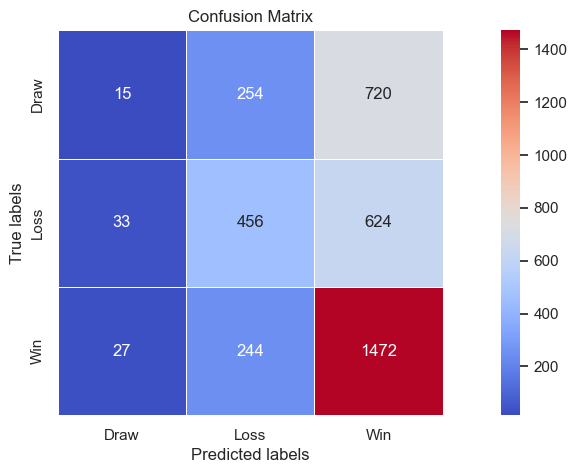

In [187]:
cm = confusion_matrix(y_test, rf_y_pred)

plt.figure(figsize=(15, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm', square=True,
            linewidths=0.5, xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix');

In [188]:
print('\n')

accuracy = accuracy_score(y_test, rf_y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))

print('\n')

report = classification_report(y_test, rf_y_pred,
        target_names=le.classes_, zero_division=0)
print(report)



Accuracy: 50.53%


              precision    recall  f1-score   support

        Draw       0.20      0.02      0.03       989
        Loss       0.48      0.41      0.44      1113
         Win       0.52      0.84      0.65      1743

    accuracy                           0.51      3845
   macro avg       0.40      0.42      0.37      3845
weighted avg       0.43      0.51      0.43      3845



- Overall better accuracy compared to OVR logit but almost no recall for drawn games. 
- It seems like this is a more 'honest' approach to modeling drawn games. Logistic regression 'doesn't have a choice' other than to fit the function through the data, producing 'artificial recall' just because of the mathematical properties of the model. In reality, it doesn't seem like there could be anything discernable in the data for the model to learn for predicting a drawn outcome.
- The class_weight parameter was put to balanced. However, it does seem like there are some problems with class inbalance.

#### Feature importances

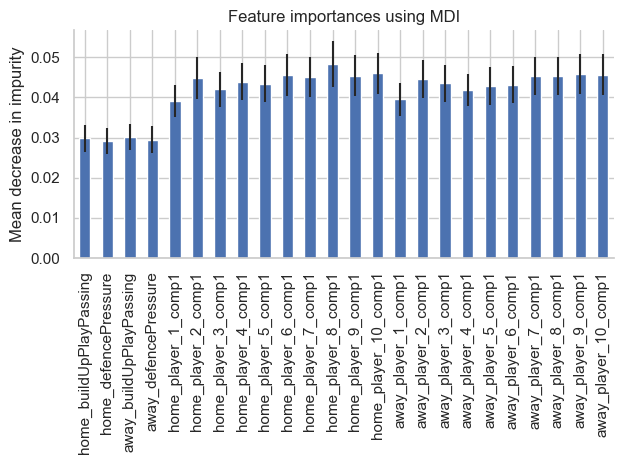

In [189]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We see that generally every feature helps very little to increase the entropy on average. 

# Modeling home goals

We split goals into three categories:
- No goals
- 1 goal
- 2 goals
- 3 and more goals

In [190]:
def get_goals_cat(val):
    if val == 0:
        return 'None'
    if val in (1, 2):
        return '1 or 2'
    else:
        return '3 and more'

In [191]:
le2 = LabelEncoder()
y_train_2 = le2.fit_transform(home_team_goals_train.apply(get_goals_cat))
y_test_2 = le2.transform(home_team_goals_test.apply(get_goals_cat))

In [192]:
model = LogisticRegression(multi_class='ovr', max_iter=10000, class_weight='balanced')
model.fit(X_train_scaled, y_train_2)
y_pred = model.predict(X_test_scaled)

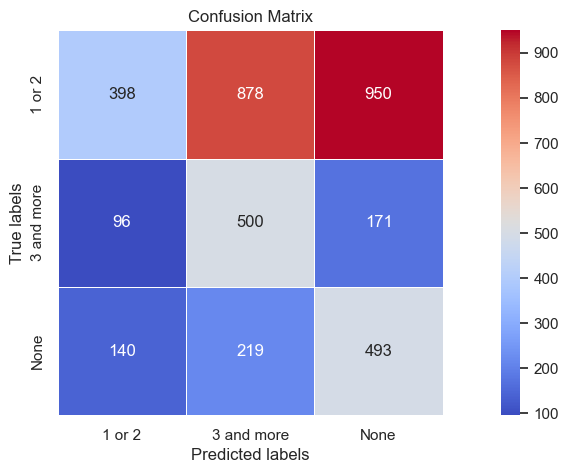

In [193]:
cm = confusion_matrix(y_test_2, y_pred)

plt.figure(figsize=(15, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm', square=True,
            linewidths=0.5, xticklabels=le2.classes_, yticklabels=le2.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix');

In [194]:
print('\n')

accuracy = accuracy_score(y_test_2, y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))

print('\n')

report = classification_report(y_test_2, y_pred,
        target_names=le2.classes_, zero_division=0)
print(report)



Accuracy: 36.18%


              precision    recall  f1-score   support

      1 or 2       0.63      0.18      0.28      2226
  3 and more       0.31      0.65      0.42       767
        None       0.31      0.58      0.40       852

    accuracy                           0.36      3845
   macro avg       0.42      0.47      0.37      3845
weighted avg       0.49      0.36      0.33      3845



Barely better accuracy compared to random guessing with the initial OVR logit model. We will move to another approach straight away.

In [195]:
rf_grid2 = RandomForestClassifier(class_weight='balanced')
gr_space = {
    'max_depth': [None, 5, 10],
    'n_estimators': [100, 200, 300],
    'max_features': [3, 4, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(rf_grid2, gr_space, cv=3, scoring='accuracy', verbose=0)
model_grid = grid.fit(X_train_scaled, y_train_2)

In [196]:
model_grid.best_params_

{'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 1,
 'n_estimators': 200}

In [197]:
rf2 = RandomForestClassifier(class_weight='balanced',
                             max_depth=None,
                             max_features=3,
                             min_samples_leaf=1,
                             n_estimators=300)

rf2.fit(X_train_scaled, y_train_2);

In [198]:
rf_y_pred_2 = rf2.predict(X_test_scaled)

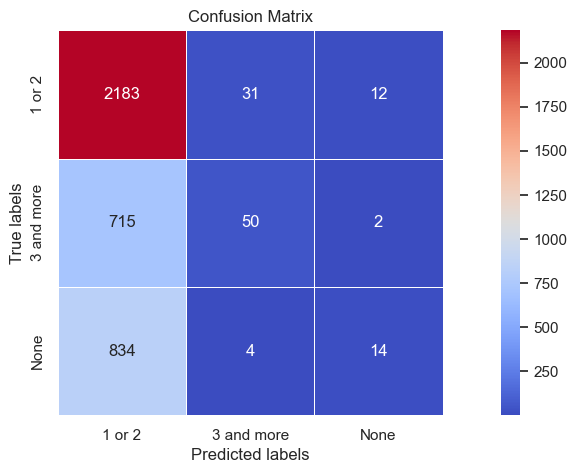

In [199]:
cm_rf_2 = confusion_matrix(y_test_2, rf_y_pred_2)

plt.figure(figsize=(15, 5))
sns.heatmap(cm_rf_2, annot=True, fmt='g', cmap='coolwarm', square=True,
            linewidths=0.5, xticklabels=le2.classes_, yticklabels=le2.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix');

In [200]:
print('\n')

accuracy = accuracy_score(y_test_2, rf_y_pred_2)

print("Accuracy: {:.2f}%".format(accuracy * 100))

print('\n')

report = classification_report(y_test_2, rf_y_pred_2,
        target_names=le2.classes_, zero_division=0)
print(report)



Accuracy: 58.44%


              precision    recall  f1-score   support

      1 or 2       0.58      0.98      0.73      2226
  3 and more       0.59      0.07      0.12       767
        None       0.50      0.02      0.03       852

    accuracy                           0.58      3845
   macro avg       0.56      0.35      0.29      3845
weighted avg       0.57      0.58      0.45      3845



It seems that the class_weight='balanced' setting is not doing it's job as the model seems to be completely biased in predicting the majority class.

## Adressing class inbalance

We will use SMOTE to adress inbalanced classes.

In [201]:
from imblearn.over_sampling import SMOTE

In [202]:
sm = SMOTE(sampling_strategy='all') # Creating synthetic data for all classes
X_res, y_res = sm.fit_resample(X_train_scaled, y_train_2)

Resulting shapes:

In [203]:
unique, counts = np.unique(y_res, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 7665]
 [   1 7665]
 [   2 7665]]


In [204]:
rf_grid3 = RandomForestClassifier()
gr_space = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 200, 300],
    'max_features': [3, 4, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid3 = GridSearchCV(rf_grid3, gr_space, cv=3, scoring='accuracy', verbose=0)
model_grid = grid3.fit(X_res, y_res)

In [205]:
grid3.best_params_

{'max_depth': 15,
 'max_features': 5,
 'min_samples_leaf': 1,
 'n_estimators': 300}

In [206]:
rf3 = RandomForestClassifier(class_weight='balanced',
                             max_depth=15,
                             max_features=5,
                             min_samples_leaf=1,
                             n_estimators=300)

rf3.fit(X_res, y_res);

In [207]:
rf_y_pred_3 = rf3.predict(X_test_scaled)

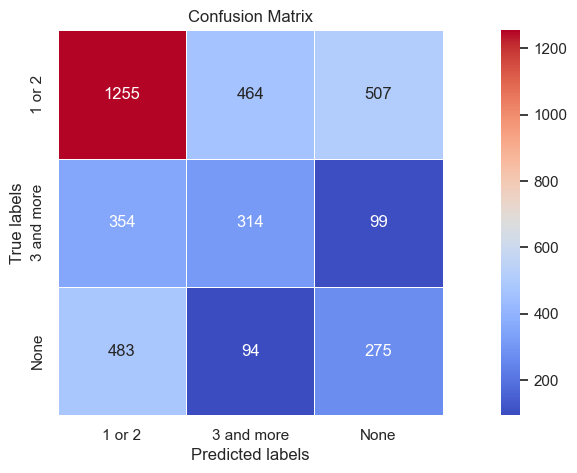

In [208]:
cm_rf_3 = confusion_matrix(y_test_2, rf_y_pred_3)

plt.figure(figsize=(15, 5))
sns.heatmap(cm_rf_3, annot=True, fmt='g', cmap='coolwarm', square=True,
            linewidths=0.5, xticklabels=le2.classes_, yticklabels=le2.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix');

In [209]:
print('\n')

accuracy = accuracy_score(y_test_2, rf_y_pred_3)

print("Accuracy: {:.2f}%".format(accuracy * 100))

print('\n')

report = classification_report(y_test_2, rf_y_pred_3,
        target_names=le2.classes_, zero_division=0)
print(report)



Accuracy: 47.96%


              precision    recall  f1-score   support

      1 or 2       0.60      0.56      0.58      2226
  3 and more       0.36      0.41      0.38       767
        None       0.31      0.32      0.32       852

    accuracy                           0.48      3845
   macro avg       0.42      0.43      0.43      3845
weighted avg       0.49      0.48      0.48      3845



- The model performs only a bit better than random guessing
- Even after oversampling, we still see strong differences in recall when compared to the majority class.
- We see that 3 and more goals often get missqualified as 1 or 2 but not as None.\
That might suggest that we need to redefine the categories.

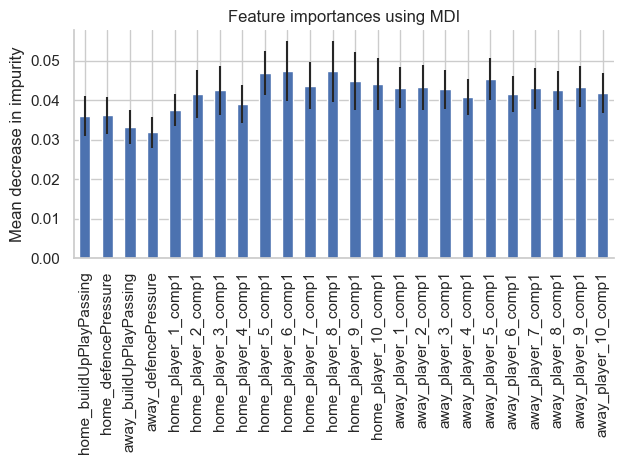

In [210]:
importances3 = rf3.feature_importances_
std3 = np.std([tree.feature_importances_ for tree in rf3.estimators_], axis=0)

forest_importances3 = pd.Series(importances3, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances3.plot.bar(yerr=std3, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

- All of the features help to reduce entropy measure relatively poorly.

# Suggestions

- Explore the option to model this data as a time series by analyzing the data, looking for autocorrelation and other patterns for engineering predictors that would sufficiently explain the variance.
- Incorporate more data, especially the readily available data like temperature and weather. Explore the potential for it to be used as features.
- Try including categorical features into the model as well.
- Experiment with feature transformations.
- Explore the remaining attributes such as shotons, shotoffs, cards and fouls.
- Try more modeling techniques as well as more granular models(ex. league specific models).